# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [1]:

import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

2024-08-25 12:58:07.931500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 12:58:08.073991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 12:58:08.140393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 12:58:08.140927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 12:58:08.244658: I tensorflow/core/platform/cpu_feature_gua

In [ ]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = 'config.yml'
model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train



    pathway_relation, ensemble_pathway_relation = return_threshold_pathways(config['pathways_network']['pathway_relation'], 
                                  config['pathways_network']['ensemble_pathway_relation'],  config['pathways_network']['h_thresh'],\
                                      config['pathways_network']['l_thresh'])

    if os.path.exists(config['pathways_network']['pathway_relation_updated']):
        os.remove(config['pathways_network']['pathway_relation_updated'])

    if os.path.exists(config['pathways_network']['ensemble_pathway_relation_updated']):
        os.remove(config['pathways_network']['ensemble_pathway_relation_updated'])

    pathway_relation.to_csv(config['pathways_network']['pathway_relation_updated'], sep = '\t', index = False, header= False)
    ensemble_pathway_relation.to_csv(config['pathways_network']['ensemble_pathway_relation_updated'], sep = '\t', index = False, header= False)




    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation_updated'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation_updated'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f'{config['model_output']['model_save_dir']}{date_string}')
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
    '''
    print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
    '''
    
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')


for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/train.csv', 'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/test.csv', 'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/val.csv', 'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/y_train.csv', 'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/y_test.csv', 'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/'}, 'train': {'epochs': 700, 'learning_rate': 0.0005, 'weight_decay': 0.01, 'batch_size': 200000}, 'gene_expression': {'highly_expressed_th

/home/anwer/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


...


  0%|▏                                                                                                                                                                         | 1/700 [00:08<1:41:38,  8.72s/it]

Epoch [1/700], Train Loss: 0.6927, Train_accuracy: 50.7661621057341, Val Loss: 0.6925, Val_accuracy: 50.97490959251389
Model saved.


  0%|▍                                                                                                                                                                         | 2/700 [00:17<1:42:18,  8.79s/it]

Epoch [2/700], Train Loss: 0.6909, Train_accuracy: 50.804066313722565, Val Loss: 0.6908, Val_accuracy: 51.0084628863289
Model saved.


  0%|▋                                                                                                                                                                         | 3/700 [00:26<1:42:35,  8.83s/it]

Epoch [3/700], Train Loss: 0.6882, Train_accuracy: 53.29393781224368, Val Loss: 0.6882, Val_accuracy: 53.263989859448984
Model saved.


  1%|▉                                                                                                                                                                         | 4/700 [00:35<1:42:12,  8.81s/it]

Epoch [4/700], Train Loss: 0.6864, Train_accuracy: 61.662068451271345, Val Loss: 0.6865, Val_accuracy: 61.62248816314357
Model saved.


  1%|█▏                                                                                                                                                                        | 5/700 [00:43<1:41:27,  8.76s/it]

Epoch [5/700], Train Loss: 0.6850, Train_accuracy: 59.52017000969354, Val Loss: 0.6851, Val_accuracy: 59.158185139618986


  1%|█▍                                                                                                                                                                        | 6/700 [00:52<1:41:19,  8.76s/it]

Epoch [6/700], Train Loss: 0.6832, Train_accuracy: 60.47274625307583, Val Loss: 0.6834, Val_accuracy: 60.10886179771092


  1%|█▋                                                                                                                                                                        | 7/700 [01:01<1:40:57,  8.74s/it]

Epoch [7/700], Train Loss: 0.6810, Train_accuracy: 63.39758407277608, Val Loss: 0.6812, Val_accuracy: 63.06714386906759
Model saved.


  1%|█▉                                                                                                                                                                        | 8/700 [01:10<1:40:52,  8.75s/it]

Epoch [8/700], Train Loss: 0.6789, Train_accuracy: 64.43156115626476, Val Loss: 0.6792, Val_accuracy: 64.32166424337322
Model saved.


  1%|██▏                                                                                                                                                                       | 9/700 [01:18<1:40:54,  8.76s/it]

Epoch [9/700], Train Loss: 0.6772, Train_accuracy: 63.51067531628265, Val Loss: 0.6774, Val_accuracy: 63.56671513253551


  1%|██▍                                                                                                                                                                      | 10/700 [01:27<1:40:50,  8.77s/it]

Epoch [10/700], Train Loss: 0.6755, Train_accuracy: 63.200606467327816, Val Loss: 0.6757, Val_accuracy: 63.206949259963466


  2%|██▋                                                                                                                                                                      | 11/700 [01:36<1:41:14,  8.82s/it]

Epoch [11/700], Train Loss: 0.6735, Train_accuracy: 64.07488877289786, Val Loss: 0.6738, Val_accuracy: 64.1427133430265


  2%|██▉                                                                                                                                                                      | 12/700 [01:45<1:41:06,  8.82s/it]

Epoch [12/700], Train Loss: 0.6714, Train_accuracy: 65.14801282529267, Val Loss: 0.6718, Val_accuracy: 65.13812772620513
Model saved.


  2%|███▏                                                                                                                                                                     | 13/700 [01:54<1:40:43,  8.80s/it]

Epoch [13/700], Train Loss: 0.6695, Train_accuracy: 65.62709715904855, Val Loss: 0.6699, Val_accuracy: 65.6153301271297
Model saved.


  2%|███▍                                                                                                                                                                     | 14/700 [02:03<1:41:25,  8.87s/it]

Epoch [14/700], Train Loss: 0.6677, Train_accuracy: 65.68115725896652, Val Loss: 0.6682, Val_accuracy: 65.55008761137829


  2%|███▌                                                                                                                                                                     | 15/700 [02:12<1:41:00,  8.85s/it]

Epoch [15/700], Train Loss: 0.6658, Train_accuracy: 65.82283200357915, Val Loss: 0.6664, Val_accuracy: 65.63583491779443
Model saved.


  2%|███▊                                                                                                                                                                     | 16/700 [02:20<1:40:54,  8.85s/it]

Epoch [16/700], Train Loss: 0.6638, Train_accuracy: 66.201252703005, Val Loss: 0.6644, Val_accuracy: 66.04406665921037
Model saved.


  2%|████                                                                                                                                                                     | 17/700 [02:29<1:41:05,  8.88s/it]

Epoch [17/700], Train Loss: 0.6618, Train_accuracy: 66.53679815077176, Val Loss: 0.6625, Val_accuracy: 66.52126906013495
Model saved.


  3%|████▎                                                                                                                                                                    | 18/700 [02:38<1:40:53,  8.88s/it]

Epoch [18/700], Train Loss: 0.6599, Train_accuracy: 66.74185370218477, Val Loss: 0.6606, Val_accuracy: 66.69089960108862
Model saved.


  3%|████▌                                                                                                                                                                    | 19/700 [02:47<1:40:23,  8.85s/it]

Epoch [19/700], Train Loss: 0.6580, Train_accuracy: 66.88601396863271, Val Loss: 0.6588, Val_accuracy: 66.74868582932558
Model saved.


  3%|████▊                                                                                                                                                                    | 20/700 [02:56<1:40:24,  8.86s/it]

Epoch [20/700], Train Loss: 0.6561, Train_accuracy: 67.16190689235205, Val Loss: 0.6569, Val_accuracy: 67.00592774857398
Model saved.


  3%|█████                                                                                                                                                                    | 21/700 [03:05<1:40:04,  8.84s/it]

Epoch [21/700], Train Loss: 0.6540, Train_accuracy: 67.50553028608357, Val Loss: 0.6549, Val_accuracy: 67.3917906274466
Model saved.


  3%|█████▎                                                                                                                                                                   | 22/700 [03:14<1:40:56,  8.93s/it]

Epoch [22/700], Train Loss: 0.6521, Train_accuracy: 67.86095990853279, Val Loss: 0.6530, Val_accuracy: 67.82425530328449
Model saved.


  3%|█████▌                                                                                                                                                                   | 23/700 [03:23<1:40:24,  8.90s/it]

Epoch [23/700], Train Loss: 0.6501, Train_accuracy: 68.19836949767604, Val Loss: 0.6511, Val_accuracy: 68.11691458822652
Model saved.


  3%|█████▊                                                                                                                                                                   | 24/700 [03:32<1:40:24,  8.91s/it]

Epoch [24/700], Train Loss: 0.6482, Train_accuracy: 68.46494171451296, Val Loss: 0.6492, Val_accuracy: 68.32009842299519
Model saved.


  4%|██████                                                                                                                                                                   | 25/700 [03:41<1:40:29,  8.93s/it]

Epoch [25/700], Train Loss: 0.6461, Train_accuracy: 68.73089255089106, Val Loss: 0.6472, Val_accuracy: 68.67240800805278
Model saved.


  4%|██████▎                                                                                                                                                                  | 26/700 [03:50<1:40:49,  8.98s/it]

Epoch [26/700], Train Loss: 0.6441, Train_accuracy: 68.9862799194691, Val Loss: 0.6453, Val_accuracy: 68.834582261492
Model saved.


  4%|██████▌                                                                                                                                                                  | 27/700 [03:59<1:41:12,  9.02s/it]

Epoch [27/700], Train Loss: 0.6422, Train_accuracy: 69.21059826510576, Val Loss: 0.6434, Val_accuracy: 69.0918241807404
Model saved.


  4%|██████▊                                                                                                                                                                  | 28/700 [04:08<1:41:19,  9.05s/it]

Epoch [28/700], Train Loss: 0.6402, Train_accuracy: 69.41068277284816, Val Loss: 0.6415, Val_accuracy: 69.24467807478656
Model saved.


  4%|███████                                                                                                                                                                  | 29/700 [04:17<1:40:42,  9.00s/it]

Epoch [29/700], Train Loss: 0.6383, Train_accuracy: 69.71205229537941, Val Loss: 0.6396, Val_accuracy: 69.5876673004511
Model saved.


  4%|███████▏                                                                                                                                                                 | 30/700 [04:26<1:40:10,  8.97s/it]

Epoch [30/700], Train Loss: 0.6363, Train_accuracy: 69.97862451221634, Val Loss: 0.6377, Val_accuracy: 69.86727808224285
Model saved.


  4%|███████▍                                                                                                                                                                 | 31/700 [04:35<1:39:59,  8.97s/it]

Epoch [31/700], Train Loss: 0.6344, Train_accuracy: 70.1892724877588, Val Loss: 0.6359, Val_accuracy: 69.9884427543526
Model saved.


  5%|███████▋                                                                                                                                                                 | 32/700 [04:44<1:40:48,  9.05s/it]

Epoch [32/700], Train Loss: 0.6325, Train_accuracy: 70.32908309099496, Val Loss: 0.6340, Val_accuracy: 70.10587928270515
Model saved.


  5%|███████▉                                                                                                                                                                 | 33/700 [04:53<1:40:23,  9.03s/it]

Epoch [33/700], Train Loss: 0.6306, Train_accuracy: 70.40551288743072, Val Loss: 0.6322, Val_accuracy: 70.28110203929464
Model saved.


  5%|████████▏                                                                                                                                                                | 34/700 [05:02<1:39:54,  9.00s/it]

Epoch [34/700], Train Loss: 0.6288, Train_accuracy: 70.57701389406706, Val Loss: 0.6304, Val_accuracy: 70.3724415613466
Model saved.


  5%|████████▍                                                                                                                                                                | 35/700 [05:11<1:39:22,  8.97s/it]

Epoch [35/700], Train Loss: 0.6269, Train_accuracy: 70.62672433077324, Val Loss: 0.6286, Val_accuracy: 70.37430563322522
Model saved.


  5%|████████▋                                                                                                                                                                | 36/700 [05:20<1:39:27,  8.99s/it]

Epoch [36/700], Train Loss: 0.6251, Train_accuracy: 70.76839907538587, Val Loss: 0.6268, Val_accuracy: 70.47869365842747
Model saved.


  5%|████████▉                                                                                                                                                                | 37/700 [05:29<1:39:43,  9.02s/it]

Epoch [37/700], Train Loss: 0.6232, Train_accuracy: 70.893917928069, Val Loss: 0.6250, Val_accuracy: 70.63527569623085
Model saved.


  5%|█████████▏                                                                                                                                                               | 38/700 [05:38<1:39:36,  9.03s/it]

Epoch [38/700], Train Loss: 0.6214, Train_accuracy: 70.99706708423433, Val Loss: 0.6233, Val_accuracy: 70.68933378071058
Model saved.


  6%|█████████▍                                                                                                                                                               | 39/700 [05:47<1:39:08,  9.00s/it]

Epoch [39/700], Train Loss: 0.6197, Train_accuracy: 71.06541893470533, Val Loss: 0.6216, Val_accuracy: 70.77508108712672
Model saved.


  6%|█████████▋                                                                                                                                                               | 40/700 [05:56<1:38:56,  8.99s/it]

Epoch [40/700], Train Loss: 0.6179, Train_accuracy: 71.16483980811772, Val Loss: 0.6199, Val_accuracy: 70.79931402154867
Model saved.


  6%|█████████▉                                                                                                                                                               | 41/700 [06:05<1:38:35,  8.98s/it]

Epoch [41/700], Train Loss: 0.6161, Train_accuracy: 71.23194889767106, Val Loss: 0.6182, Val_accuracy: 70.87201282481452
Model saved.


  6%|██████████▏                                                                                                                                                              | 42/700 [06:14<1:39:34,  9.08s/it]

Epoch [42/700], Train Loss: 0.6144, Train_accuracy: 71.27109586657718, Val Loss: 0.6165, Val_accuracy: 71.0267307907393
Model saved.


  6%|██████████▍                                                                                                                                                              | 43/700 [06:23<1:39:23,  9.08s/it]

Epoch [43/700], Train Loss: 0.6126, Train_accuracy: 71.33447667337758, Val Loss: 0.6148, Val_accuracy: 71.09010923461209
Model saved.


  6%|██████████▌                                                                                                                                                              | 44/700 [06:32<1:39:24,  9.09s/it]

Epoch [44/700], Train Loss: 0.6109, Train_accuracy: 71.46310242835483, Val Loss: 0.6132, Val_accuracy: 71.09570145024792
Model saved.


  6%|██████████▊                                                                                                                                                              | 45/700 [06:41<1:38:27,  9.02s/it]

Epoch [45/700], Train Loss: 0.6092, Train_accuracy: 71.54947431213184, Val Loss: 0.6116, Val_accuracy: 71.1404391753346
Model saved.


  7%|███████████                                                                                                                                                              | 46/700 [06:50<1:38:13,  9.01s/it]

Epoch [46/700], Train Loss: 0.6076, Train_accuracy: 71.64392414187358, Val Loss: 0.6100, Val_accuracy: 71.23923498490102
Model saved.


  7%|███████████▎                                                                                                                                                             | 47/700 [06:59<1:38:15,  9.03s/it]

Epoch [47/700], Train Loss: 0.6059, Train_accuracy: 71.68307111077971, Val Loss: 0.6084, Val_accuracy: 71.29702121313798
Model saved.


  7%|███████████▌                                                                                                                                                             | 48/700 [07:08<1:37:51,  9.01s/it]

Epoch [48/700], Train Loss: 0.6043, Train_accuracy: 71.73402430840355, Val Loss: 0.6068, Val_accuracy: 71.32684636319577
Model saved.


  7%|███████████▊                                                                                                                                                             | 49/700 [07:17<1:37:22,  8.97s/it]

Epoch [49/700], Train Loss: 0.6027, Train_accuracy: 71.80921134392166, Val Loss: 0.6053, Val_accuracy: 71.40140923834024
Model saved.


  7%|████████████                                                                                                                                                             | 50/700 [07:26<1:37:04,  8.96s/it]

Epoch [50/700], Train Loss: 0.6011, Train_accuracy: 71.86824248751026, Val Loss: 0.6038, Val_accuracy: 71.50393319166388
Model saved.


  7%|████████████▎                                                                                                                                                            | 51/700 [07:35<1:36:36,  8.93s/it]

Epoch [51/700], Train Loss: 0.5995, Train_accuracy: 71.96766336092263, Val Loss: 0.6023, Val_accuracy: 71.53748648547888
Model saved.


  7%|████████████▌                                                                                                                                                            | 52/700 [07:44<1:37:14,  9.00s/it]

Epoch [52/700], Train Loss: 0.5979, Train_accuracy: 72.0173737976288, Val Loss: 0.6008, Val_accuracy: 71.58968049808
Model saved.


  8%|████████████▊                                                                                                                                                            | 53/700 [07:53<1:36:38,  8.96s/it]

Epoch [53/700], Train Loss: 0.5964, Train_accuracy: 72.09131807222927, Val Loss: 0.5993, Val_accuracy: 71.66983558886031
Model saved.


  8%|█████████████                                                                                                                                                            | 54/700 [08:02<1:36:32,  8.97s/it]

Epoch [54/700], Train Loss: 0.5949, Train_accuracy: 72.1261153779236, Val Loss: 0.5979, Val_accuracy: 71.78727211721284
Model saved.


  8%|█████████████▎                                                                                                                                                           | 55/700 [08:11<1:36:02,  8.93s/it]

Epoch [55/700], Train Loss: 0.5934, Train_accuracy: 72.18390376059453, Val Loss: 0.5965, Val_accuracy: 71.8282816985423
Model saved.


  8%|█████████████▌                                                                                                                                                           | 56/700 [08:20<1:35:56,  8.94s/it]

Epoch [56/700], Train Loss: 0.5919, Train_accuracy: 72.31750055924242, Val Loss: 0.5951, Val_accuracy: 71.89538828617232
Model saved.


  8%|█████████████▊                                                                                                                                                           | 57/700 [08:29<1:36:23,  8.99s/it]

Epoch [57/700], Train Loss: 0.5904, Train_accuracy: 72.39703725797231, Val Loss: 0.5937, Val_accuracy: 71.93266972374455
Model saved.


  8%|██████████████                                                                                                                                                           | 58/700 [08:38<1:36:51,  9.05s/it]

Epoch [58/700], Train Loss: 0.5890, Train_accuracy: 72.47160291303159, Val Loss: 0.5923, Val_accuracy: 72.03892182082541
Model saved.


  8%|██████████████▏                                                                                                                                                          | 59/700 [08:47<1:36:51,  9.07s/it]

Epoch [59/700], Train Loss: 0.5876, Train_accuracy: 72.56418860139686, Val Loss: 0.5910, Val_accuracy: 72.12280505536293
Model saved.


  9%|██████████████▍                                                                                                                                                          | 60/700 [08:56<1:36:57,  9.09s/it]

Epoch [60/700], Train Loss: 0.5861, Train_accuracy: 72.6126562771854, Val Loss: 0.5897, Val_accuracy: 72.1805912835999
Model saved.


  9%|██████████████▋                                                                                                                                                          | 61/700 [09:05<1:36:51,  9.09s/it]

Epoch [61/700], Train Loss: 0.5848, Train_accuracy: 72.68225088857406, Val Loss: 0.5884, Val_accuracy: 72.20668828990046
Model saved.


  9%|██████████████▉                                                                                                                                                          | 62/700 [09:15<1:37:44,  9.19s/it]

Epoch [62/700], Train Loss: 0.5834, Train_accuracy: 72.75184549996271, Val Loss: 0.5871, Val_accuracy: 72.29802781195242
Model saved.


  9%|███████████████▏                                                                                                                                                         | 63/700 [09:24<1:37:10,  9.15s/it]

Epoch [63/700], Train Loss: 0.5820, Train_accuracy: 72.84505256878681, Val Loss: 0.5858, Val_accuracy: 72.32971703388883
Model saved.


  9%|███████████████▍                                                                                                                                                         | 64/700 [09:33<1:37:08,  9.16s/it]

Epoch [64/700], Train Loss: 0.5807, Train_accuracy: 72.94509482265802, Val Loss: 0.5846, Val_accuracy: 72.39495954964023
Model saved.


  9%|███████████████▋                                                                                                                                                         | 65/700 [09:42<1:36:39,  9.13s/it]

Epoch [65/700], Train Loss: 0.5794, Train_accuracy: 73.03395222827032, Val Loss: 0.5833, Val_accuracy: 72.43410505909108
Model saved.


  9%|███████████████▉                                                                                                                                                         | 66/700 [09:51<1:36:39,  9.15s/it]

Epoch [66/700], Train Loss: 0.5781, Train_accuracy: 73.09919717644719, Val Loss: 0.5821, Val_accuracy: 72.5030757185997
Model saved.


 10%|████████████████▏                                                                                                                                                        | 67/700 [10:01<1:37:04,  9.20s/it]

Epoch [67/700], Train Loss: 0.5768, Train_accuracy: 73.16133522232992, Val Loss: 0.5809, Val_accuracy: 72.57018230622973
Model saved.


 10%|████████████████▍                                                                                                                                                        | 68/700 [10:10<1:36:59,  9.21s/it]

Epoch [68/700], Train Loss: 0.5755, Train_accuracy: 73.25329953023638, Val Loss: 0.5797, Val_accuracy: 72.63728889385975
Model saved.


 10%|████████████████▋                                                                                                                                                        | 69/700 [10:19<1:36:28,  9.17s/it]

Epoch [69/700], Train Loss: 0.5743, Train_accuracy: 73.32351552208387, Val Loss: 0.5786, Val_accuracy: 72.71371584088283
Model saved.


 10%|████████████████▉                                                                                                                                                        | 70/700 [10:28<1:36:20,  9.18s/it]

Epoch [70/700], Train Loss: 0.5730, Train_accuracy: 73.36017696915468, Val Loss: 0.5774, Val_accuracy: 72.79200685978451
Model saved.


 10%|█████████████████▏                                                                                                                                                       | 71/700 [10:37<1:36:04,  9.16s/it]

Epoch [71/700], Train Loss: 0.5718, Train_accuracy: 73.4198294932021, Val Loss: 0.5763, Val_accuracy: 72.8870745255937
Model saved.


 10%|█████████████████▍                                                                                                                                                       | 72/700 [10:47<1:36:44,  9.24s/it]

Epoch [72/700], Train Loss: 0.5706, Train_accuracy: 73.45338403797878, Val Loss: 0.5752, Val_accuracy: 72.92994817880178
Model saved.


 10%|█████████████████▌                                                                                                                                                       | 73/700 [10:56<1:36:11,  9.20s/it]

Epoch [73/700], Train Loss: 0.5694, Train_accuracy: 73.50495861606144, Val Loss: 0.5741, Val_accuracy: 72.95604518510234
Model saved.


 11%|█████████████████▊                                                                                                                                                       | 74/700 [11:05<1:35:56,  9.20s/it]

Epoch [74/700], Train Loss: 0.5683, Train_accuracy: 73.57828151020307, Val Loss: 0.5730, Val_accuracy: 73.00823919770346
Model saved.


 11%|██████████████████                                                                                                                                                       | 75/700 [11:14<1:35:23,  9.16s/it]

Epoch [75/700], Train Loss: 0.5671, Train_accuracy: 73.63296299057987, Val Loss: 0.5720, Val_accuracy: 73.05111285091154
Model saved.


 11%|██████████████████▎                                                                                                                                                      | 76/700 [11:23<1:35:15,  9.16s/it]

Epoch [76/700], Train Loss: 0.5660, Train_accuracy: 73.6857803295802, Val Loss: 0.5709, Val_accuracy: 73.10703500726989
Model saved.


 11%|██████████████████▌                                                                                                                                                      | 77/700 [11:32<1:35:31,  9.20s/it]

Epoch [77/700], Train Loss: 0.5648, Train_accuracy: 73.740461809957, Val Loss: 0.5699, Val_accuracy: 73.12008351042016
Model saved.


 11%|██████████████████▊                                                                                                                                                      | 78/700 [11:42<1:35:17,  9.19s/it]

Epoch [78/700], Train Loss: 0.5637, Train_accuracy: 73.80073571446326, Val Loss: 0.5688, Val_accuracy: 73.16482123550684
Model saved.


 11%|███████████████████                                                                                                                                                      | 79/700 [11:51<1:34:48,  9.16s/it]

Epoch [79/700], Train Loss: 0.5626, Train_accuracy: 73.8585240971342, Val Loss: 0.5678, Val_accuracy: 73.21515117622936
Model saved.


 11%|███████████████████▎                                                                                                                                                     | 80/700 [12:00<1:34:38,  9.16s/it]

Epoch [80/700], Train Loss: 0.5616, Train_accuracy: 73.92439042576989, Val Loss: 0.5668, Val_accuracy: 73.24497632628714
Model saved.


 12%|███████████████████▌                                                                                                                                                     | 81/700 [12:09<1:34:16,  9.14s/it]

Epoch [81/700], Train Loss: 0.5605, Train_accuracy: 73.9859070911938, Val Loss: 0.5659, Val_accuracy: 73.31394698579577
Model saved.


 12%|███████████████████▊                                                                                                                                                     | 82/700 [12:18<1:34:51,  9.21s/it]

Epoch [82/700], Train Loss: 0.5594, Train_accuracy: 74.01884025551165, Val Loss: 0.5649, Val_accuracy: 73.37359728591134
Model saved.


 12%|████████████████████                                                                                                                                                     | 83/700 [12:27<1:34:18,  9.17s/it]

Epoch [83/700], Train Loss: 0.5584, Train_accuracy: 74.07414311634727, Val Loss: 0.5640, Val_accuracy: 73.41833501099802
Model saved.


 12%|████████████████████▎                                                                                                                                                    | 84/700 [12:37<1:34:14,  9.18s/it]

Epoch [84/700], Train Loss: 0.5574, Train_accuracy: 74.11888250938284, Val Loss: 0.5630, Val_accuracy: 73.45375237669164
Model saved.


 12%|████████████████████▌                                                                                                                                                    | 85/700 [12:46<1:33:48,  9.15s/it]

Epoch [85/700], Train Loss: 0.5563, Train_accuracy: 74.18102055526558, Val Loss: 0.5621, Val_accuracy: 73.45934459232748
Model saved.


 12%|████████████████████▊                                                                                                                                                    | 86/700 [12:55<1:33:46,  9.16s/it]

Epoch [86/700], Train Loss: 0.5553, Train_accuracy: 74.22513856784232, Val Loss: 0.5612, Val_accuracy: 73.50967453304999
Model saved.


 12%|█████████████████████                                                                                                                                                    | 87/700 [13:04<1:34:04,  9.21s/it]

Epoch [87/700], Train Loss: 0.5544, Train_accuracy: 74.28044142867795, Val Loss: 0.5603, Val_accuracy: 73.58423740819445
Model saved.


 13%|█████████████████████▏                                                                                                                                                   | 88/700 [13:13<1:33:58,  9.21s/it]

Epoch [88/700], Train Loss: 0.5534, Train_accuracy: 74.32828772400765, Val Loss: 0.5594, Val_accuracy: 73.63083920515975
Model saved.


 13%|█████████████████████▍                                                                                                                                                   | 89/700 [13:22<1:33:26,  9.18s/it]

Epoch [89/700], Train Loss: 0.5524, Train_accuracy: 74.37054159520791, Val Loss: 0.5585, Val_accuracy: 73.67557693024644
Model saved.


 13%|█████████████████████▋                                                                                                                                                   | 90/700 [13:32<1:33:20,  9.18s/it]

Epoch [90/700], Train Loss: 0.5515, Train_accuracy: 74.42522307558473, Val Loss: 0.5577, Val_accuracy: 73.71472243969727
Model saved.


 13%|█████████████████████▉                                                                                                                                                   | 91/700 [13:41<1:32:56,  9.16s/it]

Epoch [91/700], Train Loss: 0.5505, Train_accuracy: 74.47804041458504, Val Loss: 0.5568, Val_accuracy: 73.76318830854117
Model saved.


 13%|██████████████████████▏                                                                                                                                                  | 92/700 [13:50<1:33:32,  9.23s/it]

Epoch [92/700], Train Loss: 0.5496, Train_accuracy: 74.50786667660876, Val Loss: 0.5560, Val_accuracy: 73.82470268053537
Model saved.


 13%|██████████████████████▍                                                                                                                                                  | 93/700 [13:59<1:33:01,  9.19s/it]

Epoch [93/700], Train Loss: 0.5487, Train_accuracy: 74.56876196157383, Val Loss: 0.5552, Val_accuracy: 73.8787607650151
Model saved.


 13%|██████████████████████▋                                                                                                                                                  | 94/700 [14:08<1:32:52,  9.20s/it]

Epoch [94/700], Train Loss: 0.5478, Train_accuracy: 74.61722963736237, Val Loss: 0.5543, Val_accuracy: 73.91977034634455
Model saved.


 14%|██████████████████████▉                                                                                                                                                  | 95/700 [14:18<1:32:24,  9.16s/it]

Epoch [95/700], Train Loss: 0.5469, Train_accuracy: 74.65824074764497, Val Loss: 0.5535, Val_accuracy: 73.9421392088879
Model saved.


 14%|███████████████████████▏                                                                                                                                                 | 96/700 [14:27<1:32:19,  9.17s/it]

Epoch [96/700], Train Loss: 0.5460, Train_accuracy: 74.70732980389232, Val Loss: 0.5527, Val_accuracy: 73.97196435894568
Model saved.


 14%|███████████████████████▍                                                                                                                                                 | 97/700 [14:36<1:32:35,  9.21s/it]

Epoch [97/700], Train Loss: 0.5451, Train_accuracy: 74.73467054408073, Val Loss: 0.5519, Val_accuracy: 74.02043022778959
Model saved.


 14%|███████████████████████▋                                                                                                                                                 | 98/700 [14:45<1:32:21,  9.21s/it]

Epoch [98/700], Train Loss: 0.5442, Train_accuracy: 74.77630303482216, Val Loss: 0.5512, Val_accuracy: 74.05584759348321
Model saved.


 14%|███████████████████████▉                                                                                                                                                 | 99/700 [14:54<1:31:57,  9.18s/it]

Epoch [99/700], Train Loss: 0.5434, Train_accuracy: 74.81234310143415, Val Loss: 0.5504, Val_accuracy: 74.08380867166238
Model saved.


 14%|████████████████████████                                                                                                                                                | 100/700 [15:04<1:31:49,  9.18s/it]

Epoch [100/700], Train Loss: 0.5425, Train_accuracy: 74.8477617875873, Val Loss: 0.5496, Val_accuracy: 74.1024493904485
Model saved.


 14%|████████████████████████▏                                                                                                                                               | 101/700 [15:13<1:31:27,  9.16s/it]

Epoch [101/700], Train Loss: 0.5417, Train_accuracy: 74.90492878979941, Val Loss: 0.5489, Val_accuracy: 74.17514819371435
Model saved.


 15%|████████████████████████▍                                                                                                                                               | 102/700 [15:22<1:32:03,  9.24s/it]

Epoch [102/700], Train Loss: 0.5409, Train_accuracy: 74.94221161732906, Val Loss: 0.5482, Val_accuracy: 74.20683741565075
Model saved.


 15%|████████████████████████▋                                                                                                                                               | 103/700 [15:31<1:31:35,  9.21s/it]

Epoch [103/700], Train Loss: 0.5400, Train_accuracy: 74.99254343449407, Val Loss: 0.5474, Val_accuracy: 74.22734220631547
Model saved.


 15%|████████████████████████▉                                                                                                                                               | 104/700 [15:40<1:31:27,  9.21s/it]

Epoch [104/700], Train Loss: 0.5392, Train_accuracy: 75.02547659881192, Val Loss: 0.5467, Val_accuracy: 74.25903142825187
Model saved.


 15%|█████████████████████████▏                                                                                                                                              | 105/700 [15:49<1:30:57,  9.17s/it]

Epoch [105/700], Train Loss: 0.5384, Train_accuracy: 75.08015807918872, Val Loss: 0.5460, Val_accuracy: 74.29817693770272
Model saved.


 15%|█████████████████████████▍                                                                                                                                              | 106/700 [15:59<1:31:00,  9.19s/it]

Epoch [106/700], Train Loss: 0.5376, Train_accuracy: 75.10998434121244, Val Loss: 0.5453, Val_accuracy: 74.32986615963911
Model saved.


 15%|█████████████████████████▋                                                                                                                                              | 107/700 [16:08<1:31:04,  9.22s/it]

Epoch [107/700], Train Loss: 0.5369, Train_accuracy: 75.15845201700097, Val Loss: 0.5446, Val_accuracy: 74.3913805316333
Model saved.


 15%|█████████████████████████▉                                                                                                                                              | 108/700 [16:17<1:30:24,  9.16s/it]

Epoch [108/700], Train Loss: 0.5361, Train_accuracy: 75.20816245370716, Val Loss: 0.5439, Val_accuracy: 74.43239011296275
Model saved.


 16%|██████████████████████████▏                                                                                                                                             | 109/700 [16:26<1:29:42,  9.11s/it]

Epoch [109/700], Train Loss: 0.5353, Train_accuracy: 75.2274252479308, Val Loss: 0.5432, Val_accuracy: 74.45662304738471
Model saved.


 16%|██████████████████████████▍                                                                                                                                             | 110/700 [16:35<1:29:38,  9.12s/it]

Epoch [110/700], Train Loss: 0.5346, Train_accuracy: 75.25787289041334, Val Loss: 0.5426, Val_accuracy: 74.49949670059277
Model saved.


 16%|██████████████████████████▋                                                                                                                                             | 111/700 [16:44<1:29:22,  9.10s/it]

Epoch [111/700], Train Loss: 0.5338, Train_accuracy: 75.29142743519002, Val Loss: 0.5419, Val_accuracy: 74.50508891622862
Model saved.


 16%|██████████████████████████▉                                                                                                                                             | 112/700 [16:54<1:29:44,  9.16s/it]

Epoch [112/700], Train Loss: 0.5331, Train_accuracy: 75.32808888226083, Val Loss: 0.5413, Val_accuracy: 74.51627334750027
Model saved.


 16%|███████████████████████████                                                                                                                                             | 113/700 [17:03<1:29:31,  9.15s/it]

Epoch [113/700], Train Loss: 0.5324, Train_accuracy: 75.3684786120846, Val Loss: 0.5406, Val_accuracy: 74.54609849755806
Model saved.


 16%|███████████████████████████▎                                                                                                                                            | 114/700 [17:12<1:29:10,  9.13s/it]

Epoch [114/700], Train Loss: 0.5316, Train_accuracy: 75.40576143961425, Val Loss: 0.5400, Val_accuracy: 74.57592364761585
Model saved.


 16%|███████████████████████████▌                                                                                                                                            | 115/700 [17:21<1:28:40,  9.09s/it]

Epoch [115/700], Train Loss: 0.5309, Train_accuracy: 75.46044291999105, Val Loss: 0.5393, Val_accuracy: 74.61693322894531
Model saved.


 17%|███████████████████████████▊                                                                                                                                            | 116/700 [17:30<1:28:52,  9.13s/it]

Epoch [116/700], Train Loss: 0.5302, Train_accuracy: 75.49772574752069, Val Loss: 0.5387, Val_accuracy: 74.63557394773143
Model saved.


 17%|████████████████████████████                                                                                                                                            | 117/700 [17:39<1:28:54,  9.15s/it]

Epoch [117/700], Train Loss: 0.5295, Train_accuracy: 75.52630924862675, Val Loss: 0.5381, Val_accuracy: 74.70454460724005
Model saved.


 17%|████████████████████████████▎                                                                                                                                           | 118/700 [17:48<1:28:39,  9.14s/it]

Epoch [118/700], Train Loss: 0.5288, Train_accuracy: 75.56172793477991, Val Loss: 0.5375, Val_accuracy: 74.73064161354061
Model saved.


 17%|████████████████████████████▌                                                                                                                                           | 119/700 [17:57<1:28:10,  9.11s/it]

Epoch [119/700], Train Loss: 0.5281, Train_accuracy: 75.61143837148609, Val Loss: 0.5369, Val_accuracy: 74.74555418856951
Model saved.


 17%|████████████████████████████▊                                                                                                                                           | 120/700 [18:06<1:28:00,  9.10s/it]

Epoch [120/700], Train Loss: 0.5274, Train_accuracy: 75.64499291626277, Val Loss: 0.5363, Val_accuracy: 74.75301047608396
Model saved.


 17%|█████████████████████████████                                                                                                                                           | 121/700 [18:15<1:27:36,  9.08s/it]

Epoch [121/700], Train Loss: 0.5268, Train_accuracy: 75.67171227599235, Val Loss: 0.5357, Val_accuracy: 74.7921559855348
Model saved.


 17%|█████████████████████████████▎                                                                                                                                          | 122/700 [18:25<1:28:21,  9.17s/it]

Epoch [122/700], Train Loss: 0.5261, Train_accuracy: 75.70961648398081, Val Loss: 0.5351, Val_accuracy: 74.82011706371398
Model saved.


 18%|█████████████████████████████▌                                                                                                                                          | 123/700 [18:34<1:28:15,  9.18s/it]

Epoch [123/700], Train Loss: 0.5255, Train_accuracy: 75.7549772574752, Val Loss: 0.5345, Val_accuracy: 74.84062185437871
Model saved.


 18%|█████████████████████████████▊                                                                                                                                          | 124/700 [18:43<1:28:21,  9.20s/it]

Epoch [124/700], Train Loss: 0.5248, Train_accuracy: 75.78231799766361, Val Loss: 0.5340, Val_accuracy: 74.86112664504343
Model saved.


 18%|██████████████████████████████                                                                                                                                          | 125/700 [18:52<1:28:03,  9.19s/it]

Epoch [125/700], Train Loss: 0.5242, Train_accuracy: 75.81960082519325, Val Loss: 0.5334, Val_accuracy: 74.9040002982515
Model saved.


 18%|██████████████████████████████▏                                                                                                                                         | 126/700 [19:01<1:27:27,  9.14s/it]

Epoch [126/700], Train Loss: 0.5235, Train_accuracy: 75.83948499987572, Val Loss: 0.5329, Val_accuracy: 74.9506020952168
Model saved.


 18%|██████████████████████████████▍                                                                                                                                         | 127/700 [19:11<1:27:16,  9.14s/it]

Epoch [127/700], Train Loss: 0.5229, Train_accuracy: 75.86682574006413, Val Loss: 0.5323, Val_accuracy: 74.97483502963874
Model saved.


 18%|██████████████████████████████▋                                                                                                                                         | 128/700 [19:20<1:26:46,  9.10s/it]

Epoch [128/700], Train Loss: 0.5223, Train_accuracy: 75.89727338254667, Val Loss: 0.5318, Val_accuracy: 74.99533982030347
Model saved.


 18%|██████████████████████████████▉                                                                                                                                         | 129/700 [19:29<1:26:10,  9.06s/it]

Epoch [129/700], Train Loss: 0.5216, Train_accuracy: 75.9184003181468, Val Loss: 0.5312, Val_accuracy: 75.01770868284682
Model saved.


 19%|███████████████████████████████▏                                                                                                                                        | 130/700 [19:38<1:25:52,  9.04s/it]

Epoch [130/700], Train Loss: 0.5210, Train_accuracy: 75.93890587328809, Val Loss: 0.5307, Val_accuracy: 75.02330089848265
Model saved.


 19%|███████████████████████████████▍                                                                                                                                        | 131/700 [19:46<1:25:22,  9.00s/it]

Epoch [131/700], Train Loss: 0.5204, Train_accuracy: 75.96873213531181, Val Loss: 0.5302, Val_accuracy: 75.06058233605488
Model saved.


 19%|███████████████████████████████▋                                                                                                                                        | 132/700 [19:56<1:25:58,  9.08s/it]

Epoch [132/700], Train Loss: 0.5198, Train_accuracy: 76.01533566972385, Val Loss: 0.5296, Val_accuracy: 75.08854341423405
Model saved.


 19%|███████████████████████████████▉                                                                                                                                        | 133/700 [20:05<1:25:21,  9.03s/it]

Epoch [133/700], Train Loss: 0.5192, Train_accuracy: 76.04391917082991, Val Loss: 0.5291, Val_accuracy: 75.08667934235544


 19%|████████████████████████████████▏                                                                                                                                       | 134/700 [20:14<1:25:19,  9.04s/it]

Epoch [134/700], Train Loss: 0.5186, Train_accuracy: 76.068774389183, Val Loss: 0.5286, Val_accuracy: 75.10532006114155
Model saved.


 19%|████████████████████████████████▍                                                                                                                                       | 135/700 [20:23<1:25:28,  9.08s/it]

Epoch [135/700], Train Loss: 0.5181, Train_accuracy: 76.09052270524197, Val Loss: 0.5281, Val_accuracy: 75.14632964247102
Model saved.


 19%|████████████████████████████████▋                                                                                                                                       | 136/700 [20:32<1:25:10,  9.06s/it]

Epoch [136/700], Train Loss: 0.5175, Train_accuracy: 76.12283448910098, Val Loss: 0.5276, Val_accuracy: 75.1612422174999
Model saved.


 20%|████████████████████████████████▉                                                                                                                                       | 137/700 [20:41<1:24:38,  9.02s/it]

Epoch [137/700], Train Loss: 0.5169, Train_accuracy: 76.1433400442423, Val Loss: 0.5271, Val_accuracy: 75.19852365507214
Model saved.


 20%|█████████████████████████████████                                                                                                                                       | 138/700 [20:50<1:24:40,  9.04s/it]

Epoch [138/700], Train Loss: 0.5163, Train_accuracy: 76.18186563268958, Val Loss: 0.5266, Val_accuracy: 75.21530030197964
Model saved.


 20%|█████████████████████████████████▎                                                                                                                                      | 139/700 [20:59<1:24:13,  9.01s/it]

Epoch [139/700], Train Loss: 0.5158, Train_accuracy: 76.22039122113688, Val Loss: 0.5261, Val_accuracy: 75.22648473325131
Model saved.


 20%|█████████████████████████████████▌                                                                                                                                      | 140/700 [21:08<1:24:48,  9.09s/it]

Epoch [140/700], Train Loss: 0.5152, Train_accuracy: 76.25332438545473, Val Loss: 0.5256, Val_accuracy: 75.25817395518771
Model saved.


 20%|█████████████████████████████████▊                                                                                                                                      | 141/700 [21:17<1:24:18,  9.05s/it]

Epoch [141/700], Train Loss: 0.5147, Train_accuracy: 76.28128650610195, Val Loss: 0.5252, Val_accuracy: 75.30104760839578
Model saved.


 20%|██████████████████████████████████                                                                                                                                      | 142/700 [21:26<1:24:06,  9.04s/it]

Epoch [142/700], Train Loss: 0.5141, Train_accuracy: 76.31484105087863, Val Loss: 0.5247, Val_accuracy: 75.31782425530328
Model saved.


 20%|██████████████████████████████████▎                                                                                                                                     | 143/700 [21:35<1:23:37,  9.01s/it]

Epoch [143/700], Train Loss: 0.5136, Train_accuracy: 76.33721074739641, Val Loss: 0.5242, Val_accuracy: 75.34392126160385
Model saved.


 21%|██████████████████████████████████▌                                                                                                                                     | 144/700 [21:44<1:23:34,  9.02s/it]

Epoch [144/700], Train Loss: 0.5130, Train_accuracy: 76.3800859990555, Val Loss: 0.5238, Val_accuracy: 75.38306677105469
Model saved.


 21%|██████████████████████████████████▊                                                                                                                                     | 145/700 [21:53<1:23:48,  9.06s/it]

Epoch [145/700], Train Loss: 0.5125, Train_accuracy: 76.40431983694977, Val Loss: 0.5233, Val_accuracy: 75.37561048354024


 21%|███████████████████████████████████                                                                                                                                     | 146/700 [22:02<1:23:37,  9.06s/it]

Epoch [146/700], Train Loss: 0.5120, Train_accuracy: 76.43290333805582, Val Loss: 0.5229, Val_accuracy: 75.40729970547665
Model saved.


 21%|███████████████████████████████████▎                                                                                                                                    | 147/700 [22:11<1:23:10,  9.02s/it]

Epoch [147/700], Train Loss: 0.5115, Train_accuracy: 76.45527303457361, Val Loss: 0.5224, Val_accuracy: 75.42407635238415
Model saved.


 21%|███████████████████████████████████▌                                                                                                                                    | 148/700 [22:20<1:23:39,  9.09s/it]

Epoch [148/700], Train Loss: 0.5109, Train_accuracy: 76.48323515522084, Val Loss: 0.5220, Val_accuracy: 75.45390150244194
Model saved.


 21%|███████████████████████████████████▊                                                                                                                                    | 149/700 [22:29<1:23:07,  9.05s/it]

Epoch [149/700], Train Loss: 0.5104, Train_accuracy: 76.50125518852683, Val Loss: 0.5215, Val_accuracy: 75.46508593371361
Model saved.


 21%|████████████████████████████████████                                                                                                                                    | 150/700 [22:39<1:23:03,  9.06s/it]

Epoch [150/700], Train Loss: 0.5099, Train_accuracy: 76.51927522183283, Val Loss: 0.5211, Val_accuracy: 75.48186258062111
Model saved.


 22%|████████████████████████████████████▏                                                                                                                                   | 151/700 [22:48<1:22:46,  9.05s/it]

Epoch [151/700], Train Loss: 0.5094, Train_accuracy: 76.53294559192703, Val Loss: 0.5207, Val_accuracy: 75.48745479625694
Model saved.


 22%|████████████████████████████████████▍                                                                                                                                   | 152/700 [22:57<1:22:53,  9.08s/it]

Epoch [152/700], Train Loss: 0.5089, Train_accuracy: 76.5708497999155, Val Loss: 0.5202, Val_accuracy: 75.51914401819334
Model saved.


 22%|████████████████████████████████████▋                                                                                                                                   | 153/700 [23:06<1:23:30,  9.16s/it]

Epoch [153/700], Train Loss: 0.5084, Train_accuracy: 76.59259811597445, Val Loss: 0.5198, Val_accuracy: 75.53592066510085
Model saved.


 22%|████████████████████████████████████▉                                                                                                                                   | 154/700 [23:15<1:23:39,  9.19s/it]

Epoch [154/700], Train Loss: 0.5079, Train_accuracy: 76.62366713891582, Val Loss: 0.5194, Val_accuracy: 75.54896916825113
Model saved.


 22%|█████████████████████████████████████▏                                                                                                                                  | 155/700 [23:25<1:23:31,  9.20s/it]

Epoch [155/700], Train Loss: 0.5074, Train_accuracy: 76.63795888946885, Val Loss: 0.5190, Val_accuracy: 75.57320210267308
Model saved.


 22%|█████████████████████████████████████▍                                                                                                                                  | 156/700 [23:34<1:23:38,  9.22s/it]

Epoch [156/700], Train Loss: 0.5069, Train_accuracy: 76.65784306415132, Val Loss: 0.5186, Val_accuracy: 75.58065839018752
Model saved.


 22%|█████████████████████████████████████▋                                                                                                                                  | 157/700 [23:43<1:23:21,  9.21s/it]

Epoch [157/700], Train Loss: 0.5065, Train_accuracy: 76.67710585837497, Val Loss: 0.5182, Val_accuracy: 75.58065839018752


 23%|█████████████████████████████████████▉                                                                                                                                  | 158/700 [23:52<1:23:40,  9.26s/it]

Epoch [158/700], Train Loss: 0.5060, Train_accuracy: 76.70941764223399, Val Loss: 0.5178, Val_accuracy: 75.6253961152742
Model saved.


 23%|██████████████████████████████████████▏                                                                                                                                 | 159/700 [24:01<1:23:09,  9.22s/it]

Epoch [159/700], Train Loss: 0.5055, Train_accuracy: 76.73365148012826, Val Loss: 0.5174, Val_accuracy: 75.66640569660366
Model saved.


 23%|██████████████████████████████████████▍                                                                                                                                 | 160/700 [24:11<1:23:14,  9.25s/it]

Epoch [160/700], Train Loss: 0.5050, Train_accuracy: 76.76472050306963, Val Loss: 0.5170, Val_accuracy: 75.69623084666145
Model saved.


 23%|██████████████████████████████████████▋                                                                                                                                 | 161/700 [24:20<1:22:43,  9.21s/it]

Epoch [161/700], Train Loss: 0.5046, Train_accuracy: 76.7846046777521, Val Loss: 0.5166, Val_accuracy: 75.70927934981172
Model saved.


 23%|██████████████████████████████████████▉                                                                                                                                 | 162/700 [24:29<1:22:38,  9.22s/it]

Epoch [162/700], Train Loss: 0.5041, Train_accuracy: 76.82126612482291, Val Loss: 0.5162, Val_accuracy: 75.75774521865563
Model saved.


 23%|███████████████████████████████████████                                                                                                                                 | 163/700 [24:39<1:22:53,  9.26s/it]

Epoch [163/700], Train Loss: 0.5037, Train_accuracy: 76.84984962592897, Val Loss: 0.5158, Val_accuracy: 75.78197815307759
Model saved.


 23%|███████████████████████████████████████▎                                                                                                                                | 164/700 [24:48<1:22:41,  9.26s/it]

Epoch [164/700], Train Loss: 0.5032, Train_accuracy: 76.8802972684115, Val Loss: 0.5154, Val_accuracy: 75.8024829437423
Model saved.


 24%|███████████████████████████████████████▌                                                                                                                                | 165/700 [24:57<1:22:16,  9.23s/it]

Epoch [165/700], Train Loss: 0.5028, Train_accuracy: 76.92068699823528, Val Loss: 0.5150, Val_accuracy: 75.8024829437423


 24%|███████████████████████████████████████▊                                                                                                                                | 166/700 [25:06<1:22:07,  9.23s/it]

Epoch [166/700], Train Loss: 0.5023, Train_accuracy: 76.94057117291776, Val Loss: 0.5147, Val_accuracy: 75.82671587816426
Model saved.


 24%|████████████████████████████████████████                                                                                                                                | 167/700 [25:15<1:21:45,  9.20s/it]

Epoch [167/700], Train Loss: 0.5019, Train_accuracy: 76.95237740163547, Val Loss: 0.5143, Val_accuracy: 75.8173955187712


 24%|████████████████████████████████████████▎                                                                                                                               | 168/700 [25:25<1:22:17,  9.28s/it]

Epoch [168/700], Train Loss: 0.5014, Train_accuracy: 76.9759898590709, Val Loss: 0.5139, Val_accuracy: 75.82112366252842


 24%|████████████████████████████████████████▌                                                                                                                               | 169/700 [25:34<1:21:47,  9.24s/it]

Epoch [169/700], Train Loss: 0.5010, Train_accuracy: 76.99898093604752, Val Loss: 0.5136, Val_accuracy: 75.81925959064982


 24%|████████████████████████████████████████▊                                                                                                                               | 170/700 [25:43<1:21:36,  9.24s/it]

Epoch [170/700], Train Loss: 0.5006, Train_accuracy: 77.0257002957771, Val Loss: 0.5132, Val_accuracy: 75.83417216567871
Model saved.


 24%|█████████████████████████████████████████                                                                                                                               | 171/700 [25:52<1:21:11,  9.21s/it]

Epoch [171/700], Train Loss: 0.5001, Train_accuracy: 77.04061342678895, Val Loss: 0.5128, Val_accuracy: 75.85094881258621
Model saved.


 25%|█████████████████████████████████████████▎                                                                                                                              | 172/700 [26:02<1:21:07,  9.22s/it]

Epoch [172/700], Train Loss: 0.4997, Train_accuracy: 77.06111898193025, Val Loss: 0.5125, Val_accuracy: 75.86958953137233
Model saved.


 25%|█████████████████████████████████████████▌                                                                                                                              | 173/700 [26:11<1:20:52,  9.21s/it]

Epoch [173/700], Train Loss: 0.4993, Train_accuracy: 77.08100315661274, Val Loss: 0.5121, Val_accuracy: 75.87704581888677
Model saved.


 25%|█████████████████████████████████████████▊                                                                                                                              | 174/700 [26:20<1:20:46,  9.21s/it]

Epoch [174/700], Train Loss: 0.4989, Train_accuracy: 77.11331494047175, Val Loss: 0.5118, Val_accuracy: 75.90314282518735
Model saved.


 25%|██████████████████████████████████████████                                                                                                                              | 175/700 [26:29<1:20:30,  9.20s/it]

Epoch [175/700], Train Loss: 0.4984, Train_accuracy: 77.14065568066016, Val Loss: 0.5114, Val_accuracy: 75.92551168773068
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                             | 176/700 [26:39<1:21:04,  9.28s/it]

Epoch [176/700], Train Loss: 0.4980, Train_accuracy: 77.1462481047896, Val Loss: 0.5111, Val_accuracy: 75.92737575960929
Model saved.


 25%|██████████████████████████████████████████▍                                                                                                                             | 177/700 [26:48<1:20:34,  9.24s/it]

Epoch [177/700], Train Loss: 0.4976, Train_accuracy: 77.16302537717795, Val Loss: 0.5107, Val_accuracy: 75.94974462215264
Model saved.


 25%|██████████████████████████████████████████▋                                                                                                                             | 178/700 [26:57<1:20:30,  9.25s/it]

Epoch [178/700], Train Loss: 0.4972, Train_accuracy: 77.18415231277807, Val Loss: 0.5104, Val_accuracy: 75.99448234723931
Model saved.


 26%|██████████████████████████████████████████▉                                                                                                                             | 179/700 [27:06<1:20:07,  9.23s/it]

Epoch [179/700], Train Loss: 0.4968, Train_accuracy: 77.19471578057814, Val Loss: 0.5101, Val_accuracy: 76.02989971293293
Model saved.


 26%|███████████████████████████████████████████▏                                                                                                                            | 180/700 [27:15<1:20:01,  9.23s/it]

Epoch [180/700], Train Loss: 0.4964, Train_accuracy: 77.21087167250764, Val Loss: 0.5097, Val_accuracy: 76.04854043171905
Model saved.


 26%|███████████████████████████████████████████▍                                                                                                                            | 181/700 [27:25<1:20:17,  9.28s/it]

Epoch [181/700], Train Loss: 0.4960, Train_accuracy: 77.22081375984888, Val Loss: 0.5094, Val_accuracy: 76.06158893486933
Model saved.


 26%|███████████████████████████████████████████▋                                                                                                                            | 182/700 [27:34<1:20:06,  9.28s/it]

Epoch [182/700], Train Loss: 0.4956, Train_accuracy: 77.24256207590784, Val Loss: 0.5091, Val_accuracy: 76.08955001304851
Model saved.


 26%|███████████████████████████████████████████▉                                                                                                                            | 183/700 [27:43<1:19:42,  9.25s/it]

Epoch [183/700], Train Loss: 0.4952, Train_accuracy: 77.2711455770139, Val Loss: 0.5088, Val_accuracy: 76.07650150989822


 26%|████████████████████████████████████████████▏                                                                                                                           | 184/700 [27:52<1:19:08,  9.20s/it]

Epoch [184/700], Train Loss: 0.4948, Train_accuracy: 77.28730146894341, Val Loss: 0.5084, Val_accuracy: 76.10259851619878
Model saved.


 26%|████████████████████████████████████████████▍                                                                                                                           | 185/700 [28:01<1:18:20,  9.13s/it]

Epoch [185/700], Train Loss: 0.4944, Train_accuracy: 77.30718564362589, Val Loss: 0.5081, Val_accuracy: 76.11564701934907
Model saved.


 27%|████████████████████████████████████████████▋                                                                                                                           | 186/700 [28:11<1:18:35,  9.17s/it]

Epoch [186/700], Train Loss: 0.4940, Train_accuracy: 77.34260432977904, Val Loss: 0.5078, Val_accuracy: 76.12310330686351
Model saved.


 27%|████████████████████████████████████████████▉                                                                                                                           | 187/700 [28:20<1:17:56,  9.12s/it]

Epoch [187/700], Train Loss: 0.4937, Train_accuracy: 77.37056645042627, Val Loss: 0.5075, Val_accuracy: 76.1380158818924
Model saved.


 27%|█████████████████████████████████████████████                                                                                                                           | 188/700 [28:29<1:17:41,  9.10s/it]

Epoch [188/700], Train Loss: 0.4933, Train_accuracy: 77.3985285710735, Val Loss: 0.5072, Val_accuracy: 76.15106438504269
Model saved.


 27%|█████████████████████████████████████████████▎                                                                                                                          | 189/700 [28:38<1:17:10,  9.06s/it]

Epoch [189/700], Train Loss: 0.4929, Train_accuracy: 77.41344170208535, Val Loss: 0.5069, Val_accuracy: 76.17343324758603
Model saved.


 27%|█████████████████████████████████████████████▌                                                                                                                          | 190/700 [28:47<1:16:59,  9.06s/it]

Epoch [190/700], Train Loss: 0.4925, Train_accuracy: 77.44264658365024, Val Loss: 0.5066, Val_accuracy: 76.20325839764381
Model saved.


 27%|█████████████████████████████████████████████▊                                                                                                                          | 191/700 [28:56<1:17:10,  9.10s/it]

Epoch [191/700], Train Loss: 0.4921, Train_accuracy: 77.45818109512092, Val Loss: 0.5063, Val_accuracy: 76.22749133206577
Model saved.


 27%|██████████████████████████████████████████████                                                                                                                          | 192/700 [29:05<1:17:01,  9.10s/it]

Epoch [192/700], Train Loss: 0.4918, Train_accuracy: 77.47557974796808, Val Loss: 0.5060, Val_accuracy: 76.24613205085188
Model saved.


 28%|██████████████████████████████████████████████▎                                                                                                                         | 193/700 [29:14<1:16:37,  9.07s/it]

Epoch [193/700], Train Loss: 0.4914, Train_accuracy: 77.47868665026222, Val Loss: 0.5057, Val_accuracy: 76.25731648212356
Model saved.


 28%|██████████████████████████████████████████████▌                                                                                                                         | 194/700 [29:23<1:16:24,  9.06s/it]

Epoch [194/700], Train Loss: 0.4910, Train_accuracy: 77.49359978127409, Val Loss: 0.5054, Val_accuracy: 76.24613205085188


 28%|██████████████████████████████████████████████▊                                                                                                                         | 195/700 [29:32<1:16:01,  9.03s/it]

Epoch [195/700], Train Loss: 0.4907, Train_accuracy: 77.52404742375661, Val Loss: 0.5051, Val_accuracy: 76.25545241024494


 28%|███████████████████████████████████████████████                                                                                                                         | 196/700 [29:41<1:15:56,  9.04s/it]

Epoch [196/700], Train Loss: 0.4903, Train_accuracy: 77.52901846742724, Val Loss: 0.5048, Val_accuracy: 76.27222905715244
Model saved.


 28%|███████████████████████████████████████████████▎                                                                                                                        | 197/700 [29:50<1:15:39,  9.02s/it]

Epoch [197/700], Train Loss: 0.4900, Train_accuracy: 77.54890264210971, Val Loss: 0.5045, Val_accuracy: 76.28527756030273
Model saved.


 28%|███████████████████████████████████████████████▌                                                                                                                        | 198/700 [29:59<1:15:39,  9.04s/it]

Epoch [198/700], Train Loss: 0.4896, Train_accuracy: 77.56754405587454, Val Loss: 0.5042, Val_accuracy: 76.29646199157439
Model saved.


 28%|███████████████████████████████████████████████▊                                                                                                                        | 199/700 [30:08<1:15:14,  9.01s/it]

Epoch [199/700], Train Loss: 0.4892, Train_accuracy: 77.58804961101583, Val Loss: 0.5039, Val_accuracy: 76.30764642284606
Model saved.


 29%|████████████████████████████████████████████████                                                                                                                        | 200/700 [30:17<1:15:16,  9.03s/it]

Epoch [200/700], Train Loss: 0.4889, Train_accuracy: 77.60855516615713, Val Loss: 0.5036, Val_accuracy: 76.34306378853968
Model saved.


 29%|████████████████████████████████████████████████▏                                                                                                                       | 201/700 [30:26<1:15:36,  9.09s/it]

Epoch [201/700], Train Loss: 0.4885, Train_accuracy: 77.63465314542788, Val Loss: 0.5033, Val_accuracy: 76.36543265108303
Model saved.


 29%|████████████████████████████████████████████████▍                                                                                                                       | 202/700 [30:35<1:15:23,  9.08s/it]

Epoch [202/700], Train Loss: 0.4882, Train_accuracy: 77.64956627643974, Val Loss: 0.5031, Val_accuracy: 76.37848115423331
Model saved.


 29%|████████████████████████████████████████████████▋                                                                                                                       | 203/700 [30:44<1:15:01,  9.06s/it]

Epoch [203/700], Train Loss: 0.4879, Train_accuracy: 77.66075112469863, Val Loss: 0.5028, Val_accuracy: 76.40457816053387
Model saved.


 29%|████████████████████████████████████████████████▉                                                                                                                       | 204/700 [30:54<1:15:04,  9.08s/it]

Epoch [204/700], Train Loss: 0.4875, Train_accuracy: 77.67131459249869, Val Loss: 0.5025, Val_accuracy: 76.41762666368415
Model saved.


 29%|█████████████████████████████████████████████████▏                                                                                                                      | 205/700 [31:03<1:15:09,  9.11s/it]

Epoch [205/700], Train Loss: 0.4872, Train_accuracy: 77.69430566947531, Val Loss: 0.5022, Val_accuracy: 76.42881109495582
Model saved.


 29%|█████████████████████████████████████████████████▍                                                                                                                      | 206/700 [31:12<1:15:41,  9.19s/it]

Epoch [206/700], Train Loss: 0.4868, Train_accuracy: 77.71108294186365, Val Loss: 0.5020, Val_accuracy: 76.43067516683443
Model saved.


 30%|█████████████████████████████████████████████████▋                                                                                                                      | 207/700 [31:21<1:15:16,  9.16s/it]

Epoch [207/700], Train Loss: 0.4865, Train_accuracy: 77.73655954067557, Val Loss: 0.5017, Val_accuracy: 76.44558774186332
Model saved.


 30%|█████████████████████████████████████████████████▉                                                                                                                      | 208/700 [31:30<1:14:51,  9.13s/it]

Epoch [208/700], Train Loss: 0.4862, Train_accuracy: 77.74588024755798, Val Loss: 0.5014, Val_accuracy: 76.46050031689222
Model saved.


 30%|██████████████████████████████████████████████████▏                                                                                                                     | 209/700 [31:39<1:14:25,  9.09s/it]

Epoch [209/700], Train Loss: 0.4858, Train_accuracy: 77.76824994407576, Val Loss: 0.5012, Val_accuracy: 76.4716847481639
Model saved.


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 210/700 [31:48<1:14:24,  9.11s/it]

Epoch [210/700], Train Loss: 0.4855, Train_accuracy: 77.78254169462879, Val Loss: 0.5009, Val_accuracy: 76.46609253252805


 30%|██████████████████████████████████████████████████▋                                                                                                                     | 211/700 [31:58<1:15:00,  9.20s/it]

Epoch [211/700], Train Loss: 0.4852, Train_accuracy: 77.80615415206422, Val Loss: 0.5006, Val_accuracy: 76.46795660440667


 30%|██████████████████████████████████████████████████▉                                                                                                                     | 212/700 [32:07<1:14:57,  9.22s/it]

Epoch [212/700], Train Loss: 0.4848, Train_accuracy: 77.82231004399374, Val Loss: 0.5004, Val_accuracy: 76.47541289192111
Model saved.


 30%|███████████████████████████████████████████████████                                                                                                                     | 213/700 [32:16<1:14:08,  9.13s/it]

Epoch [213/700], Train Loss: 0.4845, Train_accuracy: 77.83411627271146, Val Loss: 0.5001, Val_accuracy: 76.49778175446446
Model saved.


 31%|███████████████████████████████████████████████████▎                                                                                                                    | 214/700 [32:25<1:14:20,  9.18s/it]

Epoch [214/700], Train Loss: 0.4842, Train_accuracy: 77.846543881888, Val Loss: 0.4999, Val_accuracy: 76.50896618573613
Model saved.


 31%|███████████████████████████████████████████████████▌                                                                                                                    | 215/700 [32:34<1:14:05,  9.17s/it]

Epoch [215/700], Train Loss: 0.4839, Train_accuracy: 77.85835011060573, Val Loss: 0.4996, Val_accuracy: 76.51269432949334
Model saved.


 31%|███████████████████████████████████████████████████▊                                                                                                                    | 216/700 [32:44<1:14:00,  9.17s/it]

Epoch [216/700], Train Loss: 0.4835, Train_accuracy: 77.8738846220764, Val Loss: 0.4994, Val_accuracy: 76.5220146888864
Model saved.


 31%|████████████████████████████████████████████████████                                                                                                                    | 217/700 [32:53<1:13:24,  9.12s/it]

Epoch [217/700], Train Loss: 0.4832, Train_accuracy: 77.88569085079412, Val Loss: 0.4991, Val_accuracy: 76.55556798270142
Model saved.


 31%|████████████████████████████████████████████████████▎                                                                                                                   | 218/700 [33:02<1:13:16,  9.12s/it]

Epoch [218/700], Train Loss: 0.4829, Train_accuracy: 77.89314741630005, Val Loss: 0.4989, Val_accuracy: 76.57420870148754
Model saved.


 31%|████████████████████████████████████████████████████▌                                                                                                                   | 219/700 [33:11<1:13:21,  9.15s/it]

Epoch [219/700], Train Loss: 0.4826, Train_accuracy: 77.91116744960604, Val Loss: 0.4986, Val_accuracy: 76.57793684524475
Model saved.


 31%|████████████████████████████████████████████████████▊                                                                                                                   | 220/700 [33:20<1:12:57,  9.12s/it]

Epoch [220/700], Train Loss: 0.4823, Train_accuracy: 77.94099371162976, Val Loss: 0.4984, Val_accuracy: 76.59844163590948
Model saved.


 32%|█████████████████████████████████████████████████████                                                                                                                   | 221/700 [33:29<1:12:41,  9.11s/it]

Epoch [221/700], Train Loss: 0.4820, Train_accuracy: 77.9670916909005, Val Loss: 0.4981, Val_accuracy: 76.6170823546956
Model saved.


 32%|█████████████████████████████████████████████████████▎                                                                                                                  | 222/700 [33:38<1:12:52,  9.15s/it]

Epoch [222/700], Train Loss: 0.4817, Train_accuracy: 77.9826262023712, Val Loss: 0.4979, Val_accuracy: 76.65249972038922
Model saved.


 32%|█████████████████████████████████████████████████████▌                                                                                                                  | 223/700 [33:48<1:12:54,  9.17s/it]

Epoch [223/700], Train Loss: 0.4814, Train_accuracy: 77.98635448512415, Val Loss: 0.4976, Val_accuracy: 76.67300451105395
Model saved.


 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 224/700 [33:57<1:13:06,  9.22s/it]

Epoch [224/700], Train Loss: 0.4811, Train_accuracy: 77.99753933338305, Val Loss: 0.4974, Val_accuracy: 76.67300451105395


 32%|██████████████████████████████████████████████████████                                                                                                                  | 225/700 [34:06<1:12:54,  9.21s/it]

Epoch [225/700], Train Loss: 0.4808, Train_accuracy: 78.00686004026545, Val Loss: 0.4972, Val_accuracy: 76.6991015173545
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                 | 226/700 [34:15<1:12:52,  9.22s/it]

Epoch [226/700], Train Loss: 0.4805, Train_accuracy: 78.019287649442, Val Loss: 0.4969, Val_accuracy: 76.70282966111174
Model saved.


 32%|██████████████████████████████████████████████████████▍                                                                                                                 | 227/700 [34:25<1:12:59,  9.26s/it]

Epoch [227/700], Train Loss: 0.4802, Train_accuracy: 78.0261228344891, Val Loss: 0.4967, Val_accuracy: 76.72519852365507
Model saved.


 33%|██████████████████████████████████████████████████████▋                                                                                                                 | 228/700 [34:34<1:12:56,  9.27s/it]

Epoch [228/700], Train Loss: 0.4799, Train_accuracy: 78.0397932045833, Val Loss: 0.4965, Val_accuracy: 76.73451888304812
Model saved.


 33%|██████████████████████████████████████████████████████▉                                                                                                                 | 229/700 [34:43<1:12:41,  9.26s/it]

Epoch [229/700], Train Loss: 0.4796, Train_accuracy: 78.07894017348943, Val Loss: 0.4963, Val_accuracy: 76.73824702680535
Model saved.


 33%|███████████████████████████████████████████████████████▏                                                                                                                | 230/700 [34:52<1:12:30,  9.26s/it]

Epoch [230/700], Train Loss: 0.4793, Train_accuracy: 78.0602987597246, Val Loss: 0.4960, Val_accuracy: 76.70655780486895


 33%|███████████████████████████████████████████████████████▍                                                                                                                | 231/700 [35:02<1:12:11,  9.24s/it]

Epoch [231/700], Train Loss: 0.4791, Train_accuracy: 78.10690229413666, Val Loss: 0.4959, Val_accuracy: 76.74197517056258
Model saved.


 33%|███████████████████████████████████████████████████████▋                                                                                                                | 232/700 [35:11<1:12:06,  9.24s/it]

Epoch [232/700], Train Loss: 0.4790, Train_accuracy: 78.06092014018343, Val Loss: 0.4958, Val_accuracy: 76.67300451105395


 33%|███████████████████████████████████████████████████████▉                                                                                                                | 233/700 [35:20<1:11:50,  9.23s/it]

Epoch [233/700], Train Loss: 0.4788, Train_accuracy: 78.13734993661919, Val Loss: 0.4958, Val_accuracy: 76.80721768631399
Model saved.


 33%|████████████████████████████████████████████████████████▏                                                                                                               | 234/700 [35:29<1:11:46,  9.24s/it]

Epoch [234/700], Train Loss: 0.4784, Train_accuracy: 78.07707603211294, Val Loss: 0.4953, Val_accuracy: 76.70282966111174


 34%|████████████████████████████████████████████████████████▍                                                                                                               | 235/700 [35:39<1:11:57,  9.29s/it]

Epoch [235/700], Train Loss: 0.4779, Train_accuracy: 78.14169959983099, Val Loss: 0.4949, Val_accuracy: 76.80535361443538


 34%|████████████████████████████████████████████████████████▋                                                                                                               | 236/700 [35:48<1:11:47,  9.28s/it]

Epoch [236/700], Train Loss: 0.4777, Train_accuracy: 78.15971963313697, Val Loss: 0.4948, Val_accuracy: 76.80535361443538


 34%|████████████████████████████████████████████████████████▉                                                                                                               | 237/700 [35:57<1:11:24,  9.25s/it]

Epoch [237/700], Train Loss: 0.4775, Train_accuracy: 78.1261650883603, Val Loss: 0.4947, Val_accuracy: 76.72333445177647


 34%|█████████████████████████████████████████████████████████                                                                                                               | 238/700 [36:07<1:11:21,  9.27s/it]

Epoch [238/700], Train Loss: 0.4772, Train_accuracy: 78.18830313424303, Val Loss: 0.4944, Val_accuracy: 76.82399433322149
Model saved.


 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 239/700 [36:16<1:11:04,  9.25s/it]

Epoch [239/700], Train Loss: 0.4768, Train_accuracy: 78.20632316754903, Val Loss: 0.4941, Val_accuracy: 76.86500391455094
Model saved.


 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 240/700 [36:25<1:11:02,  9.27s/it]

Epoch [240/700], Train Loss: 0.4766, Train_accuracy: 78.19141003653718, Val Loss: 0.4940, Val_accuracy: 76.77180032062036


 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 241/700 [36:34<1:10:41,  9.24s/it]

Epoch [241/700], Train Loss: 0.4764, Train_accuracy: 78.2218576790197, Val Loss: 0.4939, Val_accuracy: 76.840770980129


 35%|██████████████████████████████████████████████████████████                                                                                                              | 242/700 [36:44<1:10:39,  9.26s/it]

Epoch [242/700], Train Loss: 0.4760, Train_accuracy: 78.24981979966694, Val Loss: 0.4935, Val_accuracy: 76.85009133952205


 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 243/700 [36:53<1:10:19,  9.23s/it]

Epoch [243/700], Train Loss: 0.4757, Train_accuracy: 78.25851912609052, Val Loss: 0.4933, Val_accuracy: 76.85941169891511


 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 244/700 [37:02<1:10:21,  9.26s/it]

Epoch [244/700], Train Loss: 0.4756, Train_accuracy: 78.25292670196107, Val Loss: 0.4932, Val_accuracy: 76.874324273944
Model saved.


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 245/700 [37:11<1:10:08,  9.25s/it]

Epoch [245/700], Train Loss: 0.4753, Train_accuracy: 78.28275296398479, Val Loss: 0.4930, Val_accuracy: 76.87059613018678


 35%|███████████████████████████████████████████████████████████                                                                                                             | 246/700 [37:21<1:10:40,  9.34s/it]

Epoch [246/700], Train Loss: 0.4750, Train_accuracy: 78.29828747545547, Val Loss: 0.4927, Val_accuracy: 76.92651828654513
Model saved.


 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 247/700 [37:30<1:10:17,  9.31s/it]

Epoch [247/700], Train Loss: 0.4748, Train_accuracy: 78.2989088559143, Val Loss: 0.4926, Val_accuracy: 76.95261529284569
Model saved.


 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 248/700 [37:39<1:10:13,  9.32s/it]

Epoch [248/700], Train Loss: 0.4745, Train_accuracy: 78.31692888922029, Val Loss: 0.4924, Val_accuracy: 76.89669313648734


 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 249/700 [37:49<1:09:51,  9.29s/it]

Epoch [249/700], Train Loss: 0.4742, Train_accuracy: 78.33432754206746, Val Loss: 0.4922, Val_accuracy: 77.00480930544681
Model saved.


 36%|████████████████████████████████████████████████████████████                                                                                                            | 250/700 [37:58<1:09:46,  9.30s/it]

Epoch [250/700], Train Loss: 0.4740, Train_accuracy: 78.33122063977332, Val Loss: 0.4920, Val_accuracy: 76.9861685866607


 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 251/700 [38:07<1:09:56,  9.35s/it]

Epoch [251/700], Train Loss: 0.4738, Train_accuracy: 78.35856137996173, Val Loss: 0.4918, Val_accuracy: 76.91906199903069


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 252/700 [38:17<1:09:43,  9.34s/it]

Epoch [252/700], Train Loss: 0.4735, Train_accuracy: 78.36850346730296, Val Loss: 0.4916, Val_accuracy: 77.0010811616896


 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 253/700 [38:26<1:09:18,  9.30s/it]

Epoch [253/700], Train Loss: 0.4732, Train_accuracy: 78.38279521785599, Val Loss: 0.4914, Val_accuracy: 77.02717816799016
Model saved.


 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 254/700 [38:35<1:09:05,  9.30s/it]

Epoch [254/700], Train Loss: 0.4730, Train_accuracy: 78.40081525116199, Val Loss: 0.4913, Val_accuracy: 76.96379972411737


 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 255/700 [38:44<1:08:45,  9.27s/it]

Epoch [255/700], Train Loss: 0.4728, Train_accuracy: 78.38403797877365, Val Loss: 0.4911, Val_accuracy: 76.99548894605375


 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 256/700 [38:54<1:08:43,  9.29s/it]

Epoch [256/700], Train Loss: 0.4725, Train_accuracy: 78.42815599135038, Val Loss: 0.4909, Val_accuracy: 77.04395481489766
Model saved.


 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 257/700 [39:03<1:08:23,  9.26s/it]

Epoch [257/700], Train Loss: 0.4723, Train_accuracy: 78.43064151318569, Val Loss: 0.4907, Val_accuracy: 77.00294523356821


 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 258/700 [39:12<1:08:20,  9.28s/it]

Epoch [258/700], Train Loss: 0.4720, Train_accuracy: 78.42567046951507, Val Loss: 0.4906, Val_accuracy: 77.04395481489766


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 259/700 [39:21<1:08:03,  9.26s/it]

Epoch [259/700], Train Loss: 0.4718, Train_accuracy: 78.46481743842119, Val Loss: 0.4903, Val_accuracy: 77.04581888677627
Model saved.


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 260/700 [39:31<1:08:00,  9.27s/it]

Epoch [260/700], Train Loss: 0.4715, Train_accuracy: 78.48470161310367, Val Loss: 0.4902, Val_accuracy: 77.06259553368378
Model saved.


 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 261/700 [39:40<1:07:51,  9.27s/it]

Epoch [261/700], Train Loss: 0.4713, Train_accuracy: 78.46668157979768, Val Loss: 0.4900, Val_accuracy: 77.09242068374157
Model saved.


 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 262/700 [39:49<1:07:53,  9.30s/it]

Epoch [262/700], Train Loss: 0.4711, Train_accuracy: 78.50334302686849, Val Loss: 0.4898, Val_accuracy: 77.07005182119822


 38%|███████████████████████████████████████████████████████████████                                                                                                         | 263/700 [39:59<1:07:28,  9.26s/it]

Epoch [263/700], Train Loss: 0.4708, Train_accuracy: 78.51017821191559, Val Loss: 0.4897, Val_accuracy: 77.07005182119822


 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 264/700 [40:08<1:07:24,  9.28s/it]

Epoch [264/700], Train Loss: 0.4706, Train_accuracy: 78.51639201650387, Val Loss: 0.4895, Val_accuracy: 77.09242068374157


 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 265/700 [40:17<1:07:05,  9.25s/it]

Epoch [265/700], Train Loss: 0.4704, Train_accuracy: 78.53441204980986, Val Loss: 0.4893, Val_accuracy: 77.09055661186295


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 266/700 [40:26<1:07:08,  9.28s/it]

Epoch [266/700], Train Loss: 0.4702, Train_accuracy: 78.55553898540998, Val Loss: 0.4892, Val_accuracy: 77.1129254744063
Model saved.


 38%|████████████████████████████████████████████████████████████████                                                                                                        | 267/700 [40:36<1:06:54,  9.27s/it]

Epoch [267/700], Train Loss: 0.4699, Train_accuracy: 78.56113140953943, Val Loss: 0.4890, Val_accuracy: 77.12410990567797
Model saved.


 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 268/700 [40:45<1:07:19,  9.35s/it]

Epoch [268/700], Train Loss: 0.4697, Train_accuracy: 78.57355901871598, Val Loss: 0.4888, Val_accuracy: 77.12038176192074


 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 269/700 [40:54<1:06:54,  9.32s/it]

Epoch [269/700], Train Loss: 0.4695, Train_accuracy: 78.5716948773395, Val Loss: 0.4887, Val_accuracy: 77.15393505573574
Model saved.


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 270/700 [41:04<1:06:44,  9.31s/it]

Epoch [270/700], Train Loss: 0.4692, Train_accuracy: 78.5853652474337, Val Loss: 0.4885, Val_accuracy: 77.13715840882824


 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 271/700 [41:13<1:06:52,  9.35s/it]

Epoch [271/700], Train Loss: 0.4690, Train_accuracy: 78.59530733477493, Val Loss: 0.4883, Val_accuracy: 77.17071170264326
Model saved.


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 272/700 [41:23<1:06:38,  9.34s/it]

Epoch [272/700], Train Loss: 0.4688, Train_accuracy: 78.6102204657868, Val Loss: 0.4882, Val_accuracy: 77.16884763076465


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 273/700 [41:32<1:06:13,  9.31s/it]

Epoch [273/700], Train Loss: 0.4686, Train_accuracy: 78.60711356349266, Val Loss: 0.4880, Val_accuracy: 77.16884763076465


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 274/700 [41:41<1:06:35,  9.38s/it]

Epoch [274/700], Train Loss: 0.4683, Train_accuracy: 78.62948326001045, Val Loss: 0.4878, Val_accuracy: 77.19121649330798
Model saved.


 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 275/700 [41:51<1:06:09,  9.34s/it]

Epoch [275/700], Train Loss: 0.4681, Train_accuracy: 78.6400467278105, Val Loss: 0.4877, Val_accuracy: 77.20799314021549
Model saved.


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 276/700 [42:00<1:05:59,  9.34s/it]

Epoch [276/700], Train Loss: 0.4679, Train_accuracy: 78.64501777148112, Val Loss: 0.4875, Val_accuracy: 77.19121649330798


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 277/700 [42:09<1:05:37,  9.31s/it]

Epoch [277/700], Train Loss: 0.4677, Train_accuracy: 78.66241642432828, Val Loss: 0.4874, Val_accuracy: 77.22663385900161
Model saved.


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 278/700 [42:18<1:05:30,  9.31s/it]

Epoch [278/700], Train Loss: 0.4675, Train_accuracy: 78.65868814157533, Val Loss: 0.4872, Val_accuracy: 77.18562427767215


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 279/700 [42:28<1:05:38,  9.35s/it]

Epoch [279/700], Train Loss: 0.4672, Train_accuracy: 78.66552332662242, Val Loss: 0.4870, Val_accuracy: 77.20426499645826


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 280/700 [42:37<1:05:27,  9.35s/it]

Epoch [280/700], Train Loss: 0.4670, Train_accuracy: 78.69597096910496, Val Loss: 0.4869, Val_accuracy: 77.2415464340305
Model saved.


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 281/700 [42:46<1:05:04,  9.32s/it]

Epoch [281/700], Train Loss: 0.4668, Train_accuracy: 78.69597096910496, Val Loss: 0.4867, Val_accuracy: 77.21358535585132


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 282/700 [42:56<1:05:27,  9.40s/it]

Epoch [282/700], Train Loss: 0.4666, Train_accuracy: 78.72020480699923, Val Loss: 0.4866, Val_accuracy: 77.22849793088021


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 283/700 [43:05<1:04:58,  9.35s/it]

Epoch [283/700], Train Loss: 0.4664, Train_accuracy: 78.73449655755226, Val Loss: 0.4864, Val_accuracy: 77.23222607463744


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 284/700 [43:15<1:04:47,  9.35s/it]

Epoch [284/700], Train Loss: 0.4662, Train_accuracy: 78.73511793801109, Val Loss: 0.4863, Val_accuracy: 77.22290571524438


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 285/700 [43:24<1:04:26,  9.32s/it]

Epoch [285/700], Train Loss: 0.4660, Train_accuracy: 78.76680834141128, Val Loss: 0.4861, Val_accuracy: 77.23781829027327


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 286/700 [43:33<1:04:22,  9.33s/it]

Epoch [286/700], Train Loss: 0.4657, Train_accuracy: 78.76556558049363, Val Loss: 0.4860, Val_accuracy: 77.25273086530217
Model saved.


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 287/700 [43:42<1:04:01,  9.30s/it]

Epoch [287/700], Train Loss: 0.4655, Train_accuracy: 78.78172147242313, Val Loss: 0.4858, Val_accuracy: 77.24713864966633


 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 288/700 [43:52<1:04:27,  9.39s/it]

Epoch [288/700], Train Loss: 0.4653, Train_accuracy: 78.80222702756444, Val Loss: 0.4857, Val_accuracy: 77.25645900905938
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 289/700 [44:01<1:04:04,  9.35s/it]

Epoch [289/700], Train Loss: 0.4651, Train_accuracy: 78.8103049735292, Val Loss: 0.4855, Val_accuracy: 77.2732356559669
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 290/700 [44:11<1:03:54,  9.35s/it]

Epoch [290/700], Train Loss: 0.4649, Train_accuracy: 78.83702433325877, Val Loss: 0.4854, Val_accuracy: 77.26950751220967


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 291/700 [44:20<1:03:32,  9.32s/it]

Epoch [291/700], Train Loss: 0.4647, Train_accuracy: 78.84572365968235, Val Loss: 0.4852, Val_accuracy: 77.30119673414607
Model saved.


 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 292/700 [44:29<1:03:29,  9.34s/it]

Epoch [292/700], Train Loss: 0.4645, Train_accuracy: 78.8606367906942, Val Loss: 0.4851, Val_accuracy: 77.30492487790329
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 293/700 [44:39<1:03:40,  9.39s/it]

Epoch [293/700], Train Loss: 0.4643, Train_accuracy: 78.88052096537668, Val Loss: 0.4849, Val_accuracy: 77.3067889497819
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 294/700 [44:48<1:03:42,  9.42s/it]

Epoch [294/700], Train Loss: 0.4641, Train_accuracy: 78.8743071607884, Val Loss: 0.4848, Val_accuracy: 77.3235655966894
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 295/700 [44:58<1:03:17,  9.38s/it]

Epoch [295/700], Train Loss: 0.4639, Train_accuracy: 78.89605547684737, Val Loss: 0.4846, Val_accuracy: 77.30119673414607


 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 296/700 [45:07<1:03:07,  9.37s/it]

Epoch [296/700], Train Loss: 0.4637, Train_accuracy: 78.89667685730619, Val Loss: 0.4845, Val_accuracy: 77.33102188420385
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 297/700 [45:16<1:02:40,  9.33s/it]

Epoch [297/700], Train Loss: 0.4635, Train_accuracy: 78.91158998831804, Val Loss: 0.4844, Val_accuracy: 77.31983745293219


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 298/700 [45:26<1:02:59,  9.40s/it]

Epoch [298/700], Train Loss: 0.4633, Train_accuracy: 78.91158998831804, Val Loss: 0.4842, Val_accuracy: 77.3235655966894


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 299/700 [45:35<1:02:36,  9.37s/it]

Epoch [299/700], Train Loss: 0.4631, Train_accuracy: 78.92961002162404, Val Loss: 0.4841, Val_accuracy: 77.35152667486858
Model saved.


 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 300/700 [45:44<1:02:28,  9.37s/it]

Epoch [300/700], Train Loss: 0.4628, Train_accuracy: 78.9470086744712, Val Loss: 0.4839, Val_accuracy: 77.37575960929054
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 301/700 [45:54<1:02:31,  9.40s/it]

Epoch [301/700], Train Loss: 0.4626, Train_accuracy: 78.94825143538885, Val Loss: 0.4838, Val_accuracy: 77.36084703426164


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 302/700 [46:03<1:02:19,  9.40s/it]

Epoch [302/700], Train Loss: 0.4624, Train_accuracy: 78.96440732731837, Val Loss: 0.4837, Val_accuracy: 77.38135182492637
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 303/700 [46:13<1:01:51,  9.35s/it]

Epoch [303/700], Train Loss: 0.4622, Train_accuracy: 78.96440732731837, Val Loss: 0.4835, Val_accuracy: 77.37389553741193


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 304/700 [46:22<1:02:07,  9.41s/it]

Epoch [304/700], Train Loss: 0.4620, Train_accuracy: 78.97807769741257, Val Loss: 0.4834, Val_accuracy: 77.37762368116914


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 305/700 [46:31<1:01:40,  9.37s/it]

Epoch [305/700], Train Loss: 0.4619, Train_accuracy: 78.99485496980091, Val Loss: 0.4832, Val_accuracy: 77.39626439995526
Model saved.


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 306/700 [46:41<1:01:25,  9.35s/it]

Epoch [306/700], Train Loss: 0.4617, Train_accuracy: 78.98615564337733, Val Loss: 0.4831, Val_accuracy: 77.3850799686836


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 307/700 [46:50<1:01:30,  9.39s/it]

Epoch [307/700], Train Loss: 0.4615, Train_accuracy: 79.00728257897745, Val Loss: 0.4830, Val_accuracy: 77.38880811244081


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 308/700 [46:59<1:01:15,  9.38s/it]

Epoch [308/700], Train Loss: 0.4613, Train_accuracy: 79.00106877438918, Val Loss: 0.4828, Val_accuracy: 77.37948775304775


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 309/700 [47:09<1:00:54,  9.35s/it]

Epoch [309/700], Train Loss: 0.4611, Train_accuracy: 79.03524469962468, Val Loss: 0.4827, Val_accuracy: 77.4018566155911
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 310/700 [47:18<1:00:44,  9.34s/it]

Epoch [310/700], Train Loss: 0.4609, Train_accuracy: 79.03959436283648, Val Loss: 0.4826, Val_accuracy: 77.38321589680498


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 311/700 [47:27<1:00:19,  9.31s/it]

Epoch [311/700], Train Loss: 0.4607, Train_accuracy: 79.05512887430716, Val Loss: 0.4824, Val_accuracy: 77.38880811244081


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 312/700 [47:37<1:00:12,  9.31s/it]

Epoch [312/700], Train Loss: 0.4605, Train_accuracy: 79.07252752715432, Val Loss: 0.4823, Val_accuracy: 77.41304104686277
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████                                                                                              | 313/700 [47:46<59:53,  9.29s/it]

Epoch [313/700], Train Loss: 0.4603, Train_accuracy: 79.07687719036612, Val Loss: 0.4822, Val_accuracy: 77.41304104686277


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                             | 314/700 [47:55<59:55,  9.32s/it]

Epoch [314/700], Train Loss: 0.4601, Train_accuracy: 79.09303308229563, Val Loss: 0.4820, Val_accuracy: 77.4186332624986
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 315/700 [48:05<59:43,  9.31s/it]

Epoch [315/700], Train Loss: 0.4599, Train_accuracy: 79.10173240871922, Val Loss: 0.4819, Val_accuracy: 77.43354583752749
Model saved.


 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 316/700 [48:14<1:00:03,  9.38s/it]

Epoch [316/700], Train Loss: 0.4597, Train_accuracy: 79.12223796386051, Val Loss: 0.4818, Val_accuracy: 77.44100212504195
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                             | 317/700 [48:23<59:43,  9.36s/it]

Epoch [317/700], Train Loss: 0.4595, Train_accuracy: 79.12720900753114, Val Loss: 0.4817, Val_accuracy: 77.45591470007084
Model saved.


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 318/700 [48:33<59:37,  9.37s/it]

Epoch [318/700], Train Loss: 0.4593, Train_accuracy: 79.14522904083712, Val Loss: 0.4815, Val_accuracy: 77.46150691570666
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 319/700 [48:42<59:14,  9.33s/it]

Epoch [319/700], Train Loss: 0.4591, Train_accuracy: 79.14274351900181, Val Loss: 0.4814, Val_accuracy: 77.4652350594639
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 320/700 [48:51<59:09,  9.34s/it]

Epoch [320/700], Train Loss: 0.4589, Train_accuracy: 79.16014217184897, Val Loss: 0.4813, Val_accuracy: 77.47082727509972
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                            | 321/700 [49:01<59:17,  9.39s/it]

Epoch [321/700], Train Loss: 0.4588, Train_accuracy: 79.16759873735491, Val Loss: 0.4811, Val_accuracy: 77.47082727509972


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 322/700 [49:10<59:05,  9.38s/it]

Epoch [322/700], Train Loss: 0.4586, Train_accuracy: 79.17754082469615, Val Loss: 0.4810, Val_accuracy: 77.48573985012862
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                           | 323/700 [49:20<58:46,  9.35s/it]

Epoch [323/700], Train Loss: 0.4584, Train_accuracy: 79.19121119479034, Val Loss: 0.4809, Val_accuracy: 77.48946799388584
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                           | 324/700 [49:29<59:05,  9.43s/it]

Epoch [324/700], Train Loss: 0.4582, Train_accuracy: 79.18996843387269, Val Loss: 0.4808, Val_accuracy: 77.50251649703613
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                           | 325/700 [49:38<58:39,  9.39s/it]

Epoch [325/700], Train Loss: 0.4580, Train_accuracy: 79.20736708671986, Val Loss: 0.4806, Val_accuracy: 77.50065242515751


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                          | 326/700 [49:48<58:27,  9.38s/it]

Epoch [326/700], Train Loss: 0.4578, Train_accuracy: 79.21793055451992, Val Loss: 0.4805, Val_accuracy: 77.49506020952168


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 327/700 [49:57<58:34,  9.42s/it]

Epoch [327/700], Train Loss: 0.4576, Train_accuracy: 79.22911540277882, Val Loss: 0.4804, Val_accuracy: 77.50624464079335
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                          | 328/700 [50:07<58:22,  9.42s/it]

Epoch [328/700], Train Loss: 0.4575, Train_accuracy: 79.24092163149653, Val Loss: 0.4803, Val_accuracy: 77.50997278455057
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 329/700 [50:16<58:00,  9.38s/it]

Epoch [329/700], Train Loss: 0.4573, Train_accuracy: 79.24402853379067, Val Loss: 0.4801, Val_accuracy: 77.51929314394363
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 330/700 [50:25<57:47,  9.37s/it]

Epoch [330/700], Train Loss: 0.4571, Train_accuracy: 79.25645614296721, Val Loss: 0.4800, Val_accuracy: 77.52674943145807
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 331/700 [50:35<57:26,  9.34s/it]

Epoch [331/700], Train Loss: 0.4569, Train_accuracy: 79.25956304526136, Val Loss: 0.4799, Val_accuracy: 77.51929314394363


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 332/700 [50:44<57:44,  9.41s/it]

Epoch [332/700], Train Loss: 0.4567, Train_accuracy: 79.26142718663783, Val Loss: 0.4798, Val_accuracy: 77.52115721582224


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 333/700 [50:54<57:23,  9.38s/it]

Epoch [333/700], Train Loss: 0.4565, Train_accuracy: 79.28503964407328, Val Loss: 0.4797, Val_accuracy: 77.5304775752153
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 334/700 [51:03<57:14,  9.38s/it]

Epoch [334/700], Train Loss: 0.4564, Train_accuracy: 79.2924962095792, Val Loss: 0.4796, Val_accuracy: 77.54352607836559
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 335/700 [51:12<57:21,  9.43s/it]

Epoch [335/700], Train Loss: 0.4562, Train_accuracy: 79.30678796013223, Val Loss: 0.4794, Val_accuracy: 77.52302128770086


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 336/700 [51:22<57:10,  9.42s/it]

Epoch [336/700], Train Loss: 0.4560, Train_accuracy: 79.31797280839112, Val Loss: 0.4793, Val_accuracy: 77.5472542221228
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 337/700 [51:31<56:49,  9.39s/it]

Epoch [337/700], Train Loss: 0.4558, Train_accuracy: 79.33909974399126, Val Loss: 0.4792, Val_accuracy: 77.53420571897253


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                        | 338/700 [51:41<57:05,  9.46s/it]

Epoch [338/700], Train Loss: 0.4557, Train_accuracy: 79.34966321179131, Val Loss: 0.4791, Val_accuracy: 77.55284643775865
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 339/700 [51:50<56:38,  9.41s/it]

Epoch [339/700], Train Loss: 0.4555, Train_accuracy: 79.35277011408546, Val Loss: 0.4790, Val_accuracy: 77.54166200648697


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 340/700 [52:00<56:30,  9.42s/it]

Epoch [340/700], Train Loss: 0.4554, Train_accuracy: 79.3857032784033, Val Loss: 0.4790, Val_accuracy: 77.55657458151586
Model saved.


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 341/700 [52:09<56:32,  9.45s/it]

Epoch [341/700], Train Loss: 0.4553, Train_accuracy: 79.34220664628539, Val Loss: 0.4789, Val_accuracy: 77.53979793460836


 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                       | 342/700 [52:18<56:17,  9.43s/it]

Epoch [342/700], Train Loss: 0.4553, Train_accuracy: 79.38694603932096, Val Loss: 0.4790, Val_accuracy: 77.61436080975282
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 343/700 [52:28<55:52,  9.39s/it]

Epoch [343/700], Train Loss: 0.4553, Train_accuracy: 79.29311759003802, Val Loss: 0.4790, Val_accuracy: 77.58453565969504


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 344/700 [52:37<56:03,  9.45s/it]

Epoch [344/700], Train Loss: 0.4551, Train_accuracy: 79.3900529416151, Val Loss: 0.4790, Val_accuracy: 77.58080751593782


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 345/700 [52:47<55:38,  9.41s/it]

Epoch [345/700], Train Loss: 0.4547, Train_accuracy: 79.38259637610916, Val Loss: 0.4785, Val_accuracy: 77.60504045035977


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                      | 346/700 [52:56<55:27,  9.40s/it]

Epoch [346/700], Train Loss: 0.4543, Train_accuracy: 79.42485024730942, Val Loss: 0.4782, Val_accuracy: 77.59012787533088


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 347/700 [53:05<55:03,  9.36s/it]

Epoch [347/700], Train Loss: 0.4542, Train_accuracy: 79.47518206447444, Val Loss: 0.4782, Val_accuracy: 77.59572009096671


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 348/700 [53:15<54:56,  9.37s/it]

Epoch [348/700], Train Loss: 0.4542, Train_accuracy: 79.40558745308577, Val Loss: 0.4782, Val_accuracy: 77.63113745666033
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 349/700 [53:24<54:37,  9.34s/it]

Epoch [349/700], Train Loss: 0.4540, Train_accuracy: 79.46089031392141, Val Loss: 0.4781, Val_accuracy: 77.6255452410245


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 350/700 [53:34<54:57,  9.42s/it]

Epoch [350/700], Train Loss: 0.4536, Train_accuracy: 79.45094822658017, Val Loss: 0.4778, Val_accuracy: 77.62181709726727


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 351/700 [53:43<54:37,  9.39s/it]

Epoch [351/700], Train Loss: 0.4535, Train_accuracy: 79.45094822658017, Val Loss: 0.4777, Val_accuracy: 77.63300152853894
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 352/700 [53:52<54:28,  9.39s/it]

Epoch [352/700], Train Loss: 0.4535, Train_accuracy: 79.51184351154525, Val Loss: 0.4778, Val_accuracy: 77.65164224732506
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 353/700 [54:02<54:32,  9.43s/it]

Epoch [353/700], Train Loss: 0.4532, Train_accuracy: 79.47518206447444, Val Loss: 0.4776, Val_accuracy: 77.64418595981061


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 354/700 [54:11<54:17,  9.42s/it]

Epoch [354/700], Train Loss: 0.4530, Train_accuracy: 79.5037655655805, Val Loss: 0.4773, Val_accuracy: 77.62368116914588


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 355/700 [54:20<53:55,  9.38s/it]

Epoch [355/700], Train Loss: 0.4528, Train_accuracy: 79.52986354485124, Val Loss: 0.4773, Val_accuracy: 77.60504045035977


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 356/700 [54:30<53:45,  9.38s/it]

Epoch [356/700], Train Loss: 0.4528, Train_accuracy: 79.4882310541098, Val Loss: 0.4772, Val_accuracy: 77.64977817544644


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 357/700 [54:39<53:27,  9.35s/it]

Epoch [357/700], Train Loss: 0.4525, Train_accuracy: 79.54353391494544, Val Loss: 0.4771, Val_accuracy: 77.64418595981061


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 358/700 [54:49<53:23,  9.37s/it]

Epoch [358/700], Train Loss: 0.4523, Train_accuracy: 79.52551388163945, Val Loss: 0.4769, Val_accuracy: 77.66841889423256
Model saved.


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 359/700 [54:58<53:09,  9.35s/it]

Epoch [359/700], Train Loss: 0.4522, Train_accuracy: 79.54788357815724, Val Loss: 0.4769, Val_accuracy: 77.69451590053312
Model saved.


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 360/700 [55:07<53:05,  9.37s/it]

Epoch [360/700], Train Loss: 0.4521, Train_accuracy: 79.5721174160515, Val Loss: 0.4768, Val_accuracy: 77.65350631920367


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 361/700 [55:17<52:48,  9.35s/it]

Epoch [361/700], Train Loss: 0.4519, Train_accuracy: 79.55036909999254, Val Loss: 0.4766, Val_accuracy: 77.66096260671812


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 362/700 [55:26<53:05,  9.42s/it]

Epoch [362/700], Train Loss: 0.4517, Train_accuracy: 79.55906842641613, Val Loss: 0.4765, Val_accuracy: 77.66469075047534


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 363/700 [55:35<52:42,  9.39s/it]

Epoch [363/700], Train Loss: 0.4516, Train_accuracy: 79.58205950339274, Val Loss: 0.4765, Val_accuracy: 77.68146739738285


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 364/700 [55:45<52:34,  9.39s/it]

Epoch [364/700], Train Loss: 0.4514, Train_accuracy: 79.57957398155743, Val Loss: 0.4764, Val_accuracy: 77.7075644036834
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 365/700 [55:54<52:11,  9.35s/it]

Epoch [365/700], Train Loss: 0.4512, Train_accuracy: 79.5857877861457, Val Loss: 0.4762, Val_accuracy: 77.69265182865452


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 366/700 [56:04<52:17,  9.39s/it]

Epoch [366/700], Train Loss: 0.4511, Train_accuracy: 79.5951084930281, Val Loss: 0.4762, Val_accuracy: 77.69637997241173


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 367/700 [56:13<52:04,  9.38s/it]

Epoch [367/700], Train Loss: 0.4510, Train_accuracy: 79.60194367807522, Val Loss: 0.4761, Val_accuracy: 77.73366140998397
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 368/700 [56:22<51:59,  9.40s/it]

Epoch [368/700], Train Loss: 0.4508, Train_accuracy: 79.63674098376954, Val Loss: 0.4760, Val_accuracy: 77.70383625992618


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 369/700 [56:32<51:45,  9.38s/it]

Epoch [369/700], Train Loss: 0.4506, Train_accuracy: 79.61872095046355, Val Loss: 0.4758, Val_accuracy: 77.71315661931924


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 370/700 [56:41<51:38,  9.39s/it]

Epoch [370/700], Train Loss: 0.4505, Train_accuracy: 79.63052717918127, Val Loss: 0.4758, Val_accuracy: 77.72806919434814


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 371/700 [56:50<51:20,  9.36s/it]

Epoch [371/700], Train Loss: 0.4503, Train_accuracy: 79.64916859294608, Val Loss: 0.4757, Val_accuracy: 77.72434105059091


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 372/700 [57:00<51:18,  9.38s/it]

Epoch [372/700], Train Loss: 0.4502, Train_accuracy: 79.64419754927548, Val Loss: 0.4756, Val_accuracy: 77.72806919434814


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 373/700 [57:09<51:01,  9.36s/it]

Epoch [373/700], Train Loss: 0.4500, Train_accuracy: 79.64668307111079, Val Loss: 0.4755, Val_accuracy: 77.76162248816314
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 374/700 [57:19<51:00,  9.39s/it]

Epoch [374/700], Train Loss: 0.4499, Train_accuracy: 79.66035344120498, Val Loss: 0.4754, Val_accuracy: 77.76348656004176
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                               | 375/700 [57:28<50:46,  9.37s/it]

Epoch [375/700], Train Loss: 0.4497, Train_accuracy: 79.68023761588745, Val Loss: 0.4753, Val_accuracy: 77.76348656004176


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 376/700 [57:37<50:41,  9.39s/it]

Epoch [376/700], Train Loss: 0.4496, Train_accuracy: 79.68210175726394, Val Loss: 0.4752, Val_accuracy: 77.7541662006487


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 377/700 [57:47<50:51,  9.45s/it]

Epoch [377/700], Train Loss: 0.4494, Train_accuracy: 79.68396589864042, Val Loss: 0.4751, Val_accuracy: 77.78212727882787
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 378/700 [57:56<50:40,  9.44s/it]

Epoch [378/700], Train Loss: 0.4493, Train_accuracy: 79.69887902965228, Val Loss: 0.4750, Val_accuracy: 77.76535063192037


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 379/700 [58:06<50:20,  9.41s/it]

Epoch [379/700], Train Loss: 0.4491, Train_accuracy: 79.71254939974648, Val Loss: 0.4749, Val_accuracy: 77.77467099131343


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 380/700 [58:15<50:35,  9.49s/it]

Epoch [380/700], Train Loss: 0.4490, Train_accuracy: 79.7131707802053, Val Loss: 0.4748, Val_accuracy: 77.77467099131343


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 381/700 [58:25<50:14,  9.45s/it]

Epoch [381/700], Train Loss: 0.4488, Train_accuracy: 79.70571421469937, Val Loss: 0.4747, Val_accuracy: 77.79703985385676
Model saved.


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 382/700 [58:34<49:47,  9.39s/it]

Epoch [382/700], Train Loss: 0.4487, Train_accuracy: 79.71441354112297, Val Loss: 0.4746, Val_accuracy: 77.81008835700705
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 383/700 [58:43<49:35,  9.39s/it]

Epoch [383/700], Train Loss: 0.4485, Train_accuracy: 79.74113290085253, Val Loss: 0.4745, Val_accuracy: 77.82500093203593
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 384/700 [58:53<49:10,  9.34s/it]

Epoch [384/700], Train Loss: 0.4484, Train_accuracy: 79.72373424800537, Val Loss: 0.4745, Val_accuracy: 77.79331171009954


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 385/700 [59:02<48:42,  9.28s/it]

Epoch [385/700], Train Loss: 0.4482, Train_accuracy: 79.74921084681729, Val Loss: 0.4743, Val_accuracy: 77.8194087164001


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 386/700 [59:11<48:50,  9.33s/it]

Epoch [386/700], Train Loss: 0.4481, Train_accuracy: 79.7833867720528, Val Loss: 0.4743, Val_accuracy: 77.83991350706484
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 387/700 [59:20<48:23,  9.28s/it]

Epoch [387/700], Train Loss: 0.4479, Train_accuracy: 79.75542465140556, Val Loss: 0.4742, Val_accuracy: 77.83059314767178


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 388/700 [59:30<48:06,  9.25s/it]

Epoch [388/700], Train Loss: 0.4478, Train_accuracy: 79.79084333755873, Val Loss: 0.4741, Val_accuracy: 77.8492338664579
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 389/700 [59:39<48:09,  9.29s/it]

Epoch [389/700], Train Loss: 0.4476, Train_accuracy: 79.77282330425273, Val Loss: 0.4740, Val_accuracy: 77.85482608209372
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 390/700 [59:48<47:53,  9.27s/it]

Epoch [390/700], Train Loss: 0.4475, Train_accuracy: 79.78711505480575, Val Loss: 0.4739, Val_accuracy: 77.86041829772957
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 391/700 [59:57<47:30,  9.23s/it]

Epoch [391/700], Train Loss: 0.4473, Train_accuracy: 79.80140680535878, Val Loss: 0.4738, Val_accuracy: 77.87905901651568
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 392/700 [1:00:06<47:19,  9.22s/it]

Epoch [392/700], Train Loss: 0.4472, Train_accuracy: 79.80327094673527, Val Loss: 0.4737, Val_accuracy: 77.89024344778734
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 393/700 [1:00:16<47:00,  9.19s/it]

Epoch [393/700], Train Loss: 0.4470, Train_accuracy: 79.81569855591181, Val Loss: 0.4736, Val_accuracy: 77.88465123215151


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 394/700 [1:00:25<47:12,  9.26s/it]

Epoch [394/700], Train Loss: 0.4469, Train_accuracy: 79.82501926279423, Val Loss: 0.4735, Val_accuracy: 77.90888416657346
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 395/700 [1:00:34<46:51,  9.22s/it]

Epoch [395/700], Train Loss: 0.4467, Train_accuracy: 79.82999030646484, Val Loss: 0.4735, Val_accuracy: 77.8976997353018


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 396/700 [1:00:43<46:40,  9.21s/it]

Epoch [396/700], Train Loss: 0.4466, Train_accuracy: 79.84676757885317, Val Loss: 0.4734, Val_accuracy: 77.91634045408792
Model saved.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 397/700 [1:00:53<46:47,  9.27s/it]

Epoch [397/700], Train Loss: 0.4465, Train_accuracy: 79.84366067655904, Val Loss: 0.4733, Val_accuracy: 77.90329195093763


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 398/700 [1:01:02<46:34,  9.25s/it]

Epoch [398/700], Train Loss: 0.4463, Train_accuracy: 79.85546690527676, Val Loss: 0.4732, Val_accuracy: 77.93311710099542
Model saved.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 399/700 [1:01:11<46:17,  9.23s/it]

Epoch [399/700], Train Loss: 0.4462, Train_accuracy: 79.86416623170035, Val Loss: 0.4731, Val_accuracy: 77.93684524475263
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 400/700 [1:01:21<46:28,  9.30s/it]

Epoch [400/700], Train Loss: 0.4460, Train_accuracy: 79.85670966619442, Val Loss: 0.4730, Val_accuracy: 77.92566081348097


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 401/700 [1:01:30<46:11,  9.27s/it]

Epoch [401/700], Train Loss: 0.4459, Train_accuracy: 79.87100141674745, Val Loss: 0.4729, Val_accuracy: 77.96667039481042
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 402/700 [1:01:39<45:56,  9.25s/it]

Epoch [402/700], Train Loss: 0.4457, Train_accuracy: 79.8765938408769, Val Loss: 0.4728, Val_accuracy: 77.94989374790292


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 403/700 [1:01:48<45:55,  9.28s/it]

Epoch [403/700], Train Loss: 0.4456, Train_accuracy: 79.88653592821812, Val Loss: 0.4728, Val_accuracy: 77.9648063229318


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 404/700 [1:01:58<45:44,  9.27s/it]

Epoch [404/700], Train Loss: 0.4455, Train_accuracy: 79.89772077647702, Val Loss: 0.4727, Val_accuracy: 77.9648063229318


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 405/700 [1:02:07<45:23,  9.23s/it]

Epoch [405/700], Train Loss: 0.4453, Train_accuracy: 79.90704148335944, Val Loss: 0.4726, Val_accuracy: 77.96667039481042


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 406/700 [1:02:16<45:10,  9.22s/it]

Epoch [406/700], Train Loss: 0.4452, Train_accuracy: 79.91511942932419, Val Loss: 0.4725, Val_accuracy: 77.98531111359654
Model saved.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 407/700 [1:02:25<44:50,  9.18s/it]

Epoch [407/700], Train Loss: 0.4450, Train_accuracy: 79.9107697661124, Val Loss: 0.4724, Val_accuracy: 77.97039853856765


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 408/700 [1:02:34<44:43,  9.19s/it]

Epoch [408/700], Train Loss: 0.4449, Train_accuracy: 79.91822633161833, Val Loss: 0.4723, Val_accuracy: 77.99090332923238
Model saved.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 409/700 [1:02:44<44:50,  9.24s/it]

Epoch [409/700], Train Loss: 0.4447, Train_accuracy: 79.92692565804191, Val Loss: 0.4722, Val_accuracy: 77.98903925735377


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 410/700 [1:02:53<44:39,  9.24s/it]

Epoch [410/700], Train Loss: 0.4446, Train_accuracy: 79.92133323391246, Val Loss: 0.4722, Val_accuracy: 77.97971889796071


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 411/700 [1:03:02<44:21,  9.21s/it]

Epoch [411/700], Train Loss: 0.4445, Train_accuracy: 79.93065394079487, Val Loss: 0.4721, Val_accuracy: 77.9946314729896
Model saved.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 412/700 [1:03:11<44:10,  9.20s/it]

Epoch [412/700], Train Loss: 0.4443, Train_accuracy: 79.94059602813611, Val Loss: 0.4720, Val_accuracy: 77.99090332923238


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 413/700 [1:03:20<43:55,  9.18s/it]

Epoch [413/700], Train Loss: 0.4442, Train_accuracy: 79.94556707180672, Val Loss: 0.4719, Val_accuracy: 77.99835961674682
Model saved.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 414/700 [1:03:29<43:46,  9.18s/it]

Epoch [414/700], Train Loss: 0.4440, Train_accuracy: 79.94805259364203, Val Loss: 0.4718, Val_accuracy: 77.99649554486821


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 415/700 [1:03:39<43:55,  9.25s/it]

Epoch [415/700], Train Loss: 0.4439, Train_accuracy: 79.95550915914797, Val Loss: 0.4717, Val_accuracy: 77.99090332923238


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 416/700 [1:03:48<43:44,  9.24s/it]

Epoch [416/700], Train Loss: 0.4438, Train_accuracy: 79.96172296373624, Val Loss: 0.4717, Val_accuracy: 77.99835961674682


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 417/700 [1:03:57<43:23,  9.20s/it]

Epoch [417/700], Train Loss: 0.4436, Train_accuracy: 79.97663609474809, Val Loss: 0.4716, Val_accuracy: 78.01513626365433
Model saved.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 418/700 [1:04:06<43:16,  9.21s/it]

Epoch [418/700], Train Loss: 0.4435, Train_accuracy: 79.98222851887753, Val Loss: 0.4715, Val_accuracy: 78.026320694926
Model saved.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 419/700 [1:04:16<43:02,  9.19s/it]

Epoch [419/700], Train Loss: 0.4433, Train_accuracy: 79.99154922575995, Val Loss: 0.4714, Val_accuracy: 78.01886440741156


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 420/700 [1:04:25<42:55,  9.20s/it]

Epoch [420/700], Train Loss: 0.4432, Train_accuracy: 79.99838441080705, Val Loss: 0.4713, Val_accuracy: 78.03004883868321
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 421/700 [1:04:34<42:58,  9.24s/it]

Epoch [421/700], Train Loss: 0.4431, Train_accuracy: 80.00584097631298, Val Loss: 0.4712, Val_accuracy: 78.02818476680461


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 422/700 [1:04:43<42:47,  9.24s/it]

Epoch [422/700], Train Loss: 0.4429, Train_accuracy: 80.01951134640719, Val Loss: 0.4712, Val_accuracy: 78.03004883868321


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 423/700 [1:04:53<42:30,  9.21s/it]

Epoch [423/700], Train Loss: 0.4428, Train_accuracy: 80.0176472050307, Val Loss: 0.4711, Val_accuracy: 78.04496141371212
Model saved.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 424/700 [1:05:02<42:18,  9.20s/it]

Epoch [424/700], Train Loss: 0.4426, Train_accuracy: 80.02510377053662, Val Loss: 0.4710, Val_accuracy: 78.04868955746933
Model saved.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 425/700 [1:05:11<42:03,  9.18s/it]

Epoch [425/700], Train Loss: 0.4425, Train_accuracy: 80.01951134640719, Val Loss: 0.4709, Val_accuracy: 78.05614584498379
Model saved.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 426/700 [1:05:20<41:57,  9.19s/it]

Epoch [426/700], Train Loss: 0.4424, Train_accuracy: 80.0313175751249, Val Loss: 0.4708, Val_accuracy: 78.06360213249823
Model saved.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 427/700 [1:05:29<41:39,  9.16s/it]

Epoch [427/700], Train Loss: 0.4422, Train_accuracy: 80.03193895558373, Val Loss: 0.4708, Val_accuracy: 78.06919434813406
Model saved.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 428/700 [1:05:38<41:36,  9.18s/it]

Epoch [428/700], Train Loss: 0.4421, Train_accuracy: 80.04001690154848, Val Loss: 0.4707, Val_accuracy: 78.07292249189129
Model saved.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 429/700 [1:05:48<41:43,  9.24s/it]

Epoch [429/700], Train Loss: 0.4420, Train_accuracy: 80.04933760843089, Val Loss: 0.4706, Val_accuracy: 78.0747865637699
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 430/700 [1:05:57<41:30,  9.22s/it]

Epoch [430/700], Train Loss: 0.4418, Train_accuracy: 80.05927969577213, Val Loss: 0.4705, Val_accuracy: 78.08969913879879
Model saved.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 431/700 [1:06:06<41:13,  9.20s/it]

Epoch [431/700], Train Loss: 0.4417, Train_accuracy: 80.06611488081923, Val Loss: 0.4704, Val_accuracy: 78.08597099504156


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 432/700 [1:06:15<41:03,  9.19s/it]

Epoch [432/700], Train Loss: 0.4415, Train_accuracy: 80.07481420724281, Val Loss: 0.4704, Val_accuracy: 78.10274764194908
Model saved.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 433/700 [1:06:24<40:49,  9.17s/it]

Epoch [433/700], Train Loss: 0.4414, Train_accuracy: 80.07605696816047, Val Loss: 0.4703, Val_accuracy: 78.1064757857063
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 434/700 [1:06:34<41:01,  9.26s/it]

Epoch [434/700], Train Loss: 0.4413, Train_accuracy: 80.08848457733701, Val Loss: 0.4702, Val_accuracy: 78.10833985758491
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 435/700 [1:06:43<40:41,  9.21s/it]

Epoch [435/700], Train Loss: 0.4411, Train_accuracy: 80.09345562100764, Val Loss: 0.4701, Val_accuracy: 78.12511650449241
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 436/700 [1:06:52<40:35,  9.22s/it]

Epoch [436/700], Train Loss: 0.4410, Train_accuracy: 80.10526184972535, Val Loss: 0.4701, Val_accuracy: 78.11952428885658


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 437/700 [1:07:01<40:22,  9.21s/it]

Epoch [437/700], Train Loss: 0.4409, Train_accuracy: 80.11644669798424, Val Loss: 0.4700, Val_accuracy: 78.13070872012825
Model saved.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 438/700 [1:07:11<40:18,  9.23s/it]

Epoch [438/700], Train Loss: 0.4407, Train_accuracy: 80.12390326349016, Val Loss: 0.4699, Val_accuracy: 78.14562129515714
Model saved.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 439/700 [1:07:20<40:32,  9.32s/it]

Epoch [439/700], Train Loss: 0.4406, Train_accuracy: 80.12949568761961, Val Loss: 0.4698, Val_accuracy: 78.1381650076427


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 440/700 [1:07:29<40:18,  9.30s/it]

Epoch [440/700], Train Loss: 0.4404, Train_accuracy: 80.1381950140432, Val Loss: 0.4697, Val_accuracy: 78.15866979830743
Model saved.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 441/700 [1:07:39<39:55,  9.25s/it]

Epoch [441/700], Train Loss: 0.4403, Train_accuracy: 80.14316605771381, Val Loss: 0.4697, Val_accuracy: 78.1549416545502


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 442/700 [1:07:48<40:04,  9.32s/it]

Epoch [442/700], Train Loss: 0.4402, Train_accuracy: 80.14689434046679, Val Loss: 0.4696, Val_accuracy: 78.16799015770049
Model saved.


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 443/700 [1:07:57<39:39,  9.26s/it]

Epoch [443/700], Train Loss: 0.4400, Train_accuracy: 80.1587005691845, Val Loss: 0.4695, Val_accuracy: 78.16053387018603


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 444/700 [1:08:06<39:25,  9.24s/it]

Epoch [444/700], Train Loss: 0.4399, Train_accuracy: 80.17361370019636, Val Loss: 0.4694, Val_accuracy: 78.16612608582187


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 445/700 [1:08:16<39:26,  9.28s/it]

Epoch [445/700], Train Loss: 0.4398, Train_accuracy: 80.17299231973753, Val Loss: 0.4694, Val_accuracy: 78.17731051709355
Model saved.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 446/700 [1:08:25<39:11,  9.26s/it]

Epoch [446/700], Train Loss: 0.4396, Train_accuracy: 80.18976959212587, Val Loss: 0.4693, Val_accuracy: 78.18103866085076
Model saved.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 447/700 [1:08:34<38:51,  9.22s/it]

Epoch [447/700], Train Loss: 0.4395, Train_accuracy: 80.19660477717296, Val Loss: 0.4692, Val_accuracy: 78.1717183014577


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 448/700 [1:08:43<38:37,  9.20s/it]

Epoch [448/700], Train Loss: 0.4394, Train_accuracy: 80.2040613426789, Val Loss: 0.4691, Val_accuracy: 78.1717183014577


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 449/700 [1:08:52<38:22,  9.17s/it]

Epoch [449/700], Train Loss: 0.4392, Train_accuracy: 80.22083861506724, Val Loss: 0.4690, Val_accuracy: 78.17917458897215


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 450/700 [1:09:02<38:15,  9.18s/it]

Epoch [450/700], Train Loss: 0.4391, Train_accuracy: 80.23450898516144, Val Loss: 0.4690, Val_accuracy: 78.19595123587966
Model saved.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 451/700 [1:09:11<38:04,  9.18s/it]

Epoch [451/700], Train Loss: 0.4390, Train_accuracy: 80.24134417020854, Val Loss: 0.4689, Val_accuracy: 78.19967937963688
Model saved.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 452/700 [1:09:20<38:04,  9.21s/it]

Epoch [452/700], Train Loss: 0.4388, Train_accuracy: 80.24320831158502, Val Loss: 0.4688, Val_accuracy: 78.21272788278716
Model saved.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 453/700 [1:09:29<37:46,  9.18s/it]

Epoch [453/700], Train Loss: 0.4387, Train_accuracy: 80.25252901846743, Val Loss: 0.4687, Val_accuracy: 78.21086381090855


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 454/700 [1:09:38<37:40,  9.19s/it]

Epoch [454/700], Train Loss: 0.4386, Train_accuracy: 80.2680635299381, Val Loss: 0.4687, Val_accuracy: 78.21645602654438
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 455/700 [1:09:47<37:27,  9.17s/it]

Epoch [455/700], Train Loss: 0.4384, Train_accuracy: 80.27179181269108, Val Loss: 0.4686, Val_accuracy: 78.23136860157328
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 456/700 [1:09:57<37:22,  9.19s/it]

Epoch [456/700], Train Loss: 0.4383, Train_accuracy: 80.28919046553824, Val Loss: 0.4685, Val_accuracy: 78.2332326734519
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 457/700 [1:10:06<37:12,  9.19s/it]

Epoch [457/700], Train Loss: 0.4382, Train_accuracy: 80.27800561727935, Val Loss: 0.4684, Val_accuracy: 78.24068896096634
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 458/700 [1:10:15<37:04,  9.19s/it]

Epoch [458/700], Train Loss: 0.4380, Train_accuracy: 80.29788979196182, Val Loss: 0.4684, Val_accuracy: 78.2500093203594
Model saved.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 459/700 [1:10:24<36:49,  9.17s/it]

Epoch [459/700], Train Loss: 0.4379, Train_accuracy: 80.29851117242065, Val Loss: 0.4683, Val_accuracy: 78.24441710472355


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 460/700 [1:10:34<37:02,  9.26s/it]

Epoch [460/700], Train Loss: 0.4378, Train_accuracy: 80.31218154251485, Val Loss: 0.4682, Val_accuracy: 78.25746560787384
Model saved.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 461/700 [1:10:43<36:46,  9.23s/it]

Epoch [461/700], Train Loss: 0.4376, Train_accuracy: 80.31156016205603, Val Loss: 0.4681, Val_accuracy: 78.2500093203594


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 462/700 [1:10:52<36:36,  9.23s/it]

Epoch [462/700], Train Loss: 0.4375, Train_accuracy: 80.33952228270326, Val Loss: 0.4681, Val_accuracy: 78.26865003914551
Model saved.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 463/700 [1:11:01<36:35,  9.26s/it]

Epoch [463/700], Train Loss: 0.4374, Train_accuracy: 80.32088086893843, Val Loss: 0.4680, Val_accuracy: 78.2500093203594


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 464/700 [1:11:11<36:29,  9.28s/it]

Epoch [464/700], Train Loss: 0.4372, Train_accuracy: 80.34325056545622, Val Loss: 0.4680, Val_accuracy: 78.27237818290273
Model saved.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 465/700 [1:11:20<36:08,  9.23s/it]

Epoch [465/700], Train Loss: 0.4371, Train_accuracy: 80.32647329306788, Val Loss: 0.4679, Val_accuracy: 78.22950452969467


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 466/700 [1:11:29<36:13,  9.29s/it]

Epoch [466/700], Train Loss: 0.4370, Train_accuracy: 80.35505679417393, Val Loss: 0.4678, Val_accuracy: 78.26865003914551


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 467/700 [1:11:38<35:55,  9.25s/it]

Epoch [467/700], Train Loss: 0.4369, Train_accuracy: 80.34449332637388, Val Loss: 0.4678, Val_accuracy: 78.2667859672669


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 468/700 [1:11:48<35:44,  9.24s/it]

Epoch [468/700], Train Loss: 0.4369, Train_accuracy: 80.34884298958566, Val Loss: 0.4678, Val_accuracy: 78.22018417030161


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 469/700 [1:11:57<35:26,  9.21s/it]

Epoch [469/700], Train Loss: 0.4369, Train_accuracy: 80.33206571719732, Val Loss: 0.4678, Val_accuracy: 78.26119375163107


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 470/700 [1:12:06<35:29,  9.26s/it]

Epoch [470/700], Train Loss: 0.4369, Train_accuracy: 80.34138642407973, Val Loss: 0.4680, Val_accuracy: 78.16612608582187


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 471/700 [1:12:15<35:11,  9.22s/it]

Epoch [471/700], Train Loss: 0.4369, Train_accuracy: 80.3382795217856, Val Loss: 0.4680, Val_accuracy: 78.19035902024382


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 472/700 [1:12:24<35:02,  9.22s/it]

Epoch [472/700], Train Loss: 0.4367, Train_accuracy: 80.34697884820918, Val Loss: 0.4680, Val_accuracy: 78.1866308764866


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 473/700 [1:12:34<34:59,  9.25s/it]

Epoch [473/700], Train Loss: 0.4363, Train_accuracy: 80.35381403325628, Val Loss: 0.4675, Val_accuracy: 78.29101890168884
Model saved.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 474/700 [1:12:43<34:49,  9.25s/it]

Epoch [474/700], Train Loss: 0.4359, Train_accuracy: 80.42216588372729, Val Loss: 0.4672, Val_accuracy: 78.30593147671775
Model saved.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 475/700 [1:12:52<34:50,  9.29s/it]

Epoch [475/700], Train Loss: 0.4359, Train_accuracy: 80.41781622051549, Val Loss: 0.4673, Val_accuracy: 78.28542668605301


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 476/700 [1:13:02<34:39,  9.28s/it]

Epoch [476/700], Train Loss: 0.4359, Train_accuracy: 80.38426167573883, Val Loss: 0.4673, Val_accuracy: 78.30593147671775


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 477/700 [1:13:11<34:21,  9.24s/it]

Epoch [477/700], Train Loss: 0.4358, Train_accuracy: 80.38488305619765, Val Loss: 0.4674, Val_accuracy: 78.22764045781605


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 478/700 [1:13:20<34:10,  9.24s/it]

Epoch [478/700], Train Loss: 0.4355, Train_accuracy: 80.41222379638604, Val Loss: 0.4670, Val_accuracy: 78.31338776423219
Model saved.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 479/700 [1:13:30<34:17,  9.31s/it]

Epoch [479/700], Train Loss: 0.4353, Train_accuracy: 80.43210797106853, Val Loss: 0.4669, Val_accuracy: 78.32084405174663
Model saved.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 480/700 [1:13:39<34:24,  9.38s/it]

Epoch [480/700], Train Loss: 0.4353, Train_accuracy: 80.44702110208038, Val Loss: 0.4669, Val_accuracy: 78.28542668605301


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 481/700 [1:13:48<34:16,  9.39s/it]

Epoch [481/700], Train Loss: 0.4353, Train_accuracy: 80.41843760097433, Val Loss: 0.4669, Val_accuracy: 78.31711590798942


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 482/700 [1:13:58<34:15,  9.43s/it]

Epoch [482/700], Train Loss: 0.4351, Train_accuracy: 80.4588273307981, Val Loss: 0.4668, Val_accuracy: 78.27051411102413


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 483/700 [1:14:07<34:05,  9.43s/it]

Epoch [483/700], Train Loss: 0.4348, Train_accuracy: 80.45758456988045, Val Loss: 0.4666, Val_accuracy: 78.35253327368304
Model saved.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 484/700 [1:14:17<34:03,  9.46s/it]

Epoch [484/700], Train Loss: 0.4347, Train_accuracy: 80.46131285263341, Val Loss: 0.4666, Val_accuracy: 78.3152518361108


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 485/700 [1:14:26<33:51,  9.45s/it]

Epoch [485/700], Train Loss: 0.4347, Train_accuracy: 80.48119702731589, Val Loss: 0.4666, Val_accuracy: 78.27983447041719


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 486/700 [1:14:36<34:01,  9.54s/it]

Epoch [486/700], Train Loss: 0.4346, Train_accuracy: 80.46876941813935, Val Loss: 0.4665, Val_accuracy: 78.3320284830183


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 487/700 [1:14:46<33:44,  9.51s/it]

Epoch [487/700], Train Loss: 0.4344, Train_accuracy: 80.49424601695127, Val Loss: 0.4664, Val_accuracy: 78.33389255489692


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 488/700 [1:14:55<33:35,  9.51s/it]

Epoch [488/700], Train Loss: 0.4342, Train_accuracy: 80.49238187557478, Val Loss: 0.4663, Val_accuracy: 78.33016441113969


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 489/700 [1:15:04<33:19,  9.48s/it]

Epoch [489/700], Train Loss: 0.4342, Train_accuracy: 80.49176049511595, Val Loss: 0.4663, Val_accuracy: 78.33575662677553


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 490/700 [1:15:14<33:11,  9.49s/it]

Epoch [490/700], Train Loss: 0.4340, Train_accuracy: 80.52034399622201, Val Loss: 0.4663, Val_accuracy: 78.32643626738248


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 491/700 [1:15:23<32:56,  9.46s/it]

Epoch [491/700], Train Loss: 0.4339, Train_accuracy: 80.51537295255139, Val Loss: 0.4661, Val_accuracy: 78.34507698616859


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 492/700 [1:15:33<32:48,  9.47s/it]

Epoch [492/700], Train Loss: 0.4337, Train_accuracy: 80.5085377675043, Val Loss: 0.4660, Val_accuracy: 78.3618536330761
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 493/700 [1:15:42<32:33,  9.44s/it]

Epoch [493/700], Train Loss: 0.4336, Train_accuracy: 80.5271791812691, Val Loss: 0.4660, Val_accuracy: 78.35998956119748


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 494/700 [1:15:52<32:25,  9.45s/it]

Epoch [494/700], Train Loss: 0.4335, Train_accuracy: 80.54582059503393, Val Loss: 0.4659, Val_accuracy: 78.36930992059054
Model saved.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 495/700 [1:16:01<32:28,  9.50s/it]

Epoch [495/700], Train Loss: 0.4334, Train_accuracy: 80.55451992145751, Val Loss: 0.4659, Val_accuracy: 78.37303806434777
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 496/700 [1:16:11<32:17,  9.50s/it]

Epoch [496/700], Train Loss: 0.4333, Train_accuracy: 80.53960679044566, Val Loss: 0.4658, Val_accuracy: 78.38235842374083
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 497/700 [1:16:20<31:58,  9.45s/it]

Epoch [497/700], Train Loss: 0.4331, Train_accuracy: 80.54333507319862, Val Loss: 0.4657, Val_accuracy: 78.3618536330761


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 498/700 [1:16:30<31:45,  9.43s/it]

Epoch [498/700], Train Loss: 0.4330, Train_accuracy: 80.57005443292819, Val Loss: 0.4657, Val_accuracy: 78.38981471125527
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 499/700 [1:16:39<31:28,  9.40s/it]

Epoch [499/700], Train Loss: 0.4329, Train_accuracy: 80.5632192478811, Val Loss: 0.4656, Val_accuracy: 78.37676620810498


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 500/700 [1:16:49<31:35,  9.48s/it]

Epoch [500/700], Train Loss: 0.4328, Train_accuracy: 80.57191857430468, Val Loss: 0.4655, Val_accuracy: 78.39727099876971
Model saved.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 501/700 [1:16:58<31:15,  9.43s/it]

Epoch [501/700], Train Loss: 0.4327, Train_accuracy: 80.5862103248577, Val Loss: 0.4655, Val_accuracy: 78.40472728628416
Model saved.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 502/700 [1:17:07<31:04,  9.42s/it]

Epoch [502/700], Train Loss: 0.4326, Train_accuracy: 80.57875375935177, Val Loss: 0.4654, Val_accuracy: 78.39727099876971


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 503/700 [1:17:17<30:48,  9.38s/it]

Epoch [503/700], Train Loss: 0.4324, Train_accuracy: 80.61230830412845, Val Loss: 0.4654, Val_accuracy: 78.40659135816277
Model saved.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 504/700 [1:17:26<30:38,  9.38s/it]

Epoch [504/700], Train Loss: 0.4323, Train_accuracy: 80.59118136852832, Val Loss: 0.4653, Val_accuracy: 78.40845543004139
Model saved.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 505/700 [1:17:35<30:35,  9.41s/it]

Epoch [505/700], Train Loss: 0.4322, Train_accuracy: 80.60920140183431, Val Loss: 0.4652, Val_accuracy: 78.42336800507027
Model saved.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 506/700 [1:17:45<30:22,  9.39s/it]

Epoch [506/700], Train Loss: 0.4321, Train_accuracy: 80.62784281559914, Val Loss: 0.4652, Val_accuracy: 78.4270961488275
Model saved.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 507/700 [1:17:54<30:04,  9.35s/it]

Epoch [507/700], Train Loss: 0.4320, Train_accuracy: 80.62287177192852, Val Loss: 0.4651, Val_accuracy: 78.4121835737986


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 508/700 [1:18:03<29:51,  9.33s/it]

Epoch [508/700], Train Loss: 0.4318, Train_accuracy: 80.65083389257575, Val Loss: 0.4651, Val_accuracy: 78.43082429258472
Model saved.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 509/700 [1:18:13<29:37,  9.31s/it]

Epoch [509/700], Train Loss: 0.4317, Train_accuracy: 80.64710560982279, Val Loss: 0.4650, Val_accuracy: 78.45132908324945
Model saved.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 510/700 [1:18:22<29:43,  9.39s/it]

Epoch [510/700], Train Loss: 0.4316, Train_accuracy: 80.64896975119926, Val Loss: 0.4649, Val_accuracy: 78.44760093949223


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 511/700 [1:18:31<29:26,  9.35s/it]

Epoch [511/700], Train Loss: 0.4315, Train_accuracy: 80.67258220863471, Val Loss: 0.4649, Val_accuracy: 78.44014465197777


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 512/700 [1:18:41<29:15,  9.34s/it]

Epoch [512/700], Train Loss: 0.4314, Train_accuracy: 80.66450426266995, Val Loss: 0.4648, Val_accuracy: 78.44200872385639


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 513/700 [1:18:50<28:59,  9.30s/it]

Epoch [513/700], Train Loss: 0.4312, Train_accuracy: 80.68563119827007, Val Loss: 0.4647, Val_accuracy: 78.46624165827835
Model saved.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 514/700 [1:18:59<28:52,  9.31s/it]

Epoch [514/700], Train Loss: 0.4311, Train_accuracy: 80.68687395918774, Val Loss: 0.4647, Val_accuracy: 78.4736979457928
Model saved.


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 515/700 [1:19:08<28:38,  9.29s/it]

Epoch [515/700], Train Loss: 0.4310, Train_accuracy: 80.69246638331718, Val Loss: 0.4646, Val_accuracy: 78.46624165827835


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 516/700 [1:19:18<28:27,  9.28s/it]

Epoch [516/700], Train Loss: 0.4309, Train_accuracy: 80.71421469937613, Val Loss: 0.4646, Val_accuracy: 78.46251351452112


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 517/700 [1:19:27<28:15,  9.26s/it]

Epoch [517/700], Train Loss: 0.4308, Train_accuracy: 80.70489399249372, Val Loss: 0.4645, Val_accuracy: 78.47742608955001
Model saved.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 518/700 [1:19:36<28:06,  9.27s/it]

Epoch [518/700], Train Loss: 0.4307, Train_accuracy: 80.7316133522233, Val Loss: 0.4644, Val_accuracy: 78.4736979457928


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 519/700 [1:19:45<27:54,  9.25s/it]

Epoch [519/700], Train Loss: 0.4305, Train_accuracy: 80.73347749359978, Val Loss: 0.4644, Val_accuracy: 78.48861052082168
Model saved.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 520/700 [1:19:55<27:49,  9.28s/it]

Epoch [520/700], Train Loss: 0.4304, Train_accuracy: 80.73472025451744, Val Loss: 0.4643, Val_accuracy: 78.51097938336503
Model saved.


  6%|█████████▍                                                                                                                                                               | 39/700 [04:45<1:22:21,  7.48s/it]

Epoch [39/700], Train Loss: 0.6859, Train_accuracy: 65.20207292521064, Val Loss: 0.6861, Val_accuracy: 65.29657383588712
Model saved.


  6%|█████████▋                                                                                                                                                               | 40/700 [04:52<1:21:32,  7.41s/it]

Epoch [40/700], Train Loss: 0.6856, Train_accuracy: 65.35617527899983, Val Loss: 0.6857, Val_accuracy: 65.49043731126272
Model saved.


  6%|█████████▉                                                                                                                                                               | 41/700 [05:00<1:21:59,  7.46s/it]

Epoch [41/700], Train Loss: 0.6852, Train_accuracy: 65.53637561205976, Val Loss: 0.6854, Val_accuracy: 65.65447563658054
Model saved.


  6%|██████████▏                                                                                                                                                              | 42/700 [05:07<1:21:16,  7.41s/it]

Epoch [42/700], Train Loss: 0.6849, Train_accuracy: 65.68612830263714, Val Loss: 0.6850, Val_accuracy: 65.8408828244417
Model saved.


  6%|██████████▍                                                                                                                                                              | 43/700 [05:15<1:21:55,  7.48s/it]

Epoch [43/700], Train Loss: 0.6845, Train_accuracy: 65.87999900579126, Val Loss: 0.6846, Val_accuracy: 66.05711516236066
Model saved.


  6%|██████████▌                                                                                                                                                              | 44/700 [05:22<1:21:10,  7.42s/it]

Epoch [44/700], Train Loss: 0.6841, Train_accuracy: 66.08691869858076, Val Loss: 0.6842, Val_accuracy: 66.21183312828542
Model saved.


  6%|██████████▊                                                                                                                                                              | 45/700 [05:30<1:21:45,  7.49s/it]

Epoch [45/700], Train Loss: 0.6837, Train_accuracy: 66.22672930181692, Val Loss: 0.6839, Val_accuracy: 66.38519181299631
Model saved.


  7%|███████████                                                                                                                                                              | 46/700 [05:37<1:20:55,  7.42s/it]

Epoch [46/700], Train Loss: 0.6833, Train_accuracy: 66.40257997166505, Val Loss: 0.6835, Val_accuracy: 66.58464750400775
Model saved.


  7%|███████████▎                                                                                                                                                             | 47/700 [05:45<1:21:20,  7.47s/it]

Epoch [47/700], Train Loss: 0.6829, Train_accuracy: 66.59582929436036, Val Loss: 0.6831, Val_accuracy: 66.74682175744697
Model saved.


  7%|███████████▌                                                                                                                                                             | 48/700 [05:52<1:20:44,  7.43s/it]

Epoch [48/700], Train Loss: 0.6824, Train_accuracy: 66.76608754007904, Val Loss: 0.6826, Val_accuracy: 66.87730678894978
Model saved.


  7%|███████████▊                                                                                                                                                             | 49/700 [06:00<1:21:19,  7.50s/it]

Epoch [49/700], Train Loss: 0.6820, Train_accuracy: 66.94753063405662, Val Loss: 0.6822, Val_accuracy: 67.08235469559706
Model saved.


  7%|████████████                                                                                                                                                             | 50/700 [06:07<1:20:37,  7.44s/it]

Epoch [50/700], Train Loss: 0.6815, Train_accuracy: 67.11095369472821, Val Loss: 0.6818, Val_accuracy: 67.19979122394959
Model saved.


  7%|████████████▎                                                                                                                                                            | 51/700 [06:15<1:21:15,  7.51s/it]

Epoch [51/700], Train Loss: 0.6811, Train_accuracy: 67.2607063853056, Val Loss: 0.6813, Val_accuracy: 67.34332475860269
Model saved.


  7%|████████████▌                                                                                                                                                            | 52/700 [06:22<1:20:19,  7.44s/it]

Epoch [52/700], Train Loss: 0.6806, Train_accuracy: 67.43034325056546, Val Loss: 0.6809, Val_accuracy: 67.5204115870708
Model saved.


  8%|████████████▊                                                                                                                                                            | 53/700 [06:30<1:20:40,  7.48s/it]

Epoch [53/700], Train Loss: 0.6801, Train_accuracy: 67.55275520095444, Val Loss: 0.6804, Val_accuracy: 67.67699362487417
Model saved.


  8%|█████████████                                                                                                                                                            | 54/700 [06:37<1:19:49,  7.41s/it]

Epoch [54/700], Train Loss: 0.6797, Train_accuracy: 67.6907016628141, Val Loss: 0.6799, Val_accuracy: 67.81120680013422
Model saved.


  8%|█████████████▎                                                                                                                                                           | 55/700 [06:44<1:20:23,  7.48s/it]

Epoch [55/700], Train Loss: 0.6792, Train_accuracy: 67.81124947182661, Val Loss: 0.6794, Val_accuracy: 67.92677925660813
Model saved.


  8%|█████████████▌                                                                                                                                                           | 56/700 [06:52<1:19:39,  7.42s/it]

Epoch [56/700], Train Loss: 0.6786, Train_accuracy: 67.93428280267442, Val Loss: 0.6789, Val_accuracy: 68.02930320993177
Model saved.


  8%|█████████████▊                                                                                                                                                           | 57/700 [06:59<1:20:14,  7.49s/it]

Epoch [57/700], Train Loss: 0.6781, Train_accuracy: 68.05358785076928, Val Loss: 0.6784, Val_accuracy: 68.10386608507623
Model saved.


  8%|██████████████                                                                                                                                                           | 58/700 [07:07<1:19:27,  7.43s/it]

Epoch [58/700], Train Loss: 0.6776, Train_accuracy: 68.20023363905251, Val Loss: 0.6779, Val_accuracy: 68.1933415352496
Model saved.


  8%|██████████████▏                                                                                                                                                          | 59/700 [07:14<1:19:51,  7.48s/it]

Epoch [59/700], Train Loss: 0.6771, Train_accuracy: 68.26734272860587, Val Loss: 0.6774, Val_accuracy: 68.32755471050963
Model saved.


  9%|██████████████▍                                                                                                                                                          | 60/700 [07:22<1:19:08,  7.42s/it]

Epoch [60/700], Train Loss: 0.6765, Train_accuracy: 68.37359878706535, Val Loss: 0.6769, Val_accuracy: 68.41330201692577
Model saved.


  9%|██████████████▋                                                                                                                                                          | 61/700 [07:29<1:19:46,  7.49s/it]

Epoch [61/700], Train Loss: 0.6759, Train_accuracy: 68.46929137772476, Val Loss: 0.6763, Val_accuracy: 68.47481638891996
Model saved.


  9%|██████████████▉                                                                                                                                                          | 62/700 [07:37<1:19:04,  7.44s/it]

Epoch [62/700], Train Loss: 0.6754, Train_accuracy: 68.59481023040787, Val Loss: 0.6758, Val_accuracy: 68.50464153897774
Model saved.


  9%|███████████████▏                                                                                                                                                         | 63/700 [07:44<1:19:38,  7.50s/it]

Epoch [63/700], Train Loss: 0.6748, Train_accuracy: 68.7271642681381, Val Loss: 0.6752, Val_accuracy: 68.59598106102972
Model saved.


  9%|███████████████▍                                                                                                                                                         | 64/700 [07:51<1:18:51,  7.44s/it]

Epoch [64/700], Train Loss: 0.6742, Train_accuracy: 68.8091864887033, Val Loss: 0.6746, Val_accuracy: 68.66308764865973
Model saved.


  9%|███████████████▋                                                                                                                                                         | 65/700 [07:59<1:19:25,  7.50s/it]

Epoch [65/700], Train Loss: 0.6736, Train_accuracy: 68.88996594835086, Val Loss: 0.6740, Val_accuracy: 68.76188345822615
Model saved.


  9%|███████████████▉                                                                                                                                                         | 66/700 [08:06<1:18:43,  7.45s/it]

Epoch [66/700], Train Loss: 0.6730, Train_accuracy: 68.96950264708076, Val Loss: 0.6734, Val_accuracy: 68.84390262088506
Model saved.


 10%|████████████████▏                                                                                                                                                        | 67/700 [08:14<1:19:17,  7.52s/it]

Epoch [67/700], Train Loss: 0.6724, Train_accuracy: 69.07638008599906, Val Loss: 0.6728, Val_accuracy: 68.95574693360176
Model saved.


 10%|████████████████▍                                                                                                                                                        | 68/700 [08:21<1:18:22,  7.44s/it]

Epoch [68/700], Train Loss: 0.6717, Train_accuracy: 69.16523749161136, Val Loss: 0.6722, Val_accuracy: 69.0414942400179
Model saved.


 10%|████████████████▋                                                                                                                                                        | 69/700 [08:29<1:18:40,  7.48s/it]

Epoch [69/700], Train Loss: 0.6711, Train_accuracy: 69.23980314667064, Val Loss: 0.6716, Val_accuracy: 69.10860082764792
Model saved.


 10%|████████████████▉                                                                                                                                                        | 70/700 [08:36<1:17:43,  7.40s/it]

Epoch [70/700], Train Loss: 0.6705, Train_accuracy: 69.32679641090647, Val Loss: 0.6710, Val_accuracy: 69.18502777467098
Model saved.


 10%|█████████████████▏                                                                                                                                                       | 71/700 [08:44<1:17:59,  7.44s/it]

Epoch [71/700], Train Loss: 0.6698, Train_accuracy: 69.40198344642458, Val Loss: 0.6703, Val_accuracy: 69.22230921224322
Model saved.


 10%|█████████████████▍                                                                                                                                                       | 72/700 [08:51<1:17:08,  7.37s/it]

Epoch [72/700], Train Loss: 0.6691, Train_accuracy: 69.49767603708399, Val Loss: 0.6697, Val_accuracy: 69.27636729672297
Model saved.


 10%|█████████████████▌                                                                                                                                                       | 73/700 [08:59<1:17:43,  7.44s/it]

Epoch [73/700], Train Loss: 0.6684, Train_accuracy: 69.60268933462581, Val Loss: 0.6690, Val_accuracy: 69.36025053126049
Model saved.


 11%|█████████████████▊                                                                                                                                                       | 74/700 [09:06<1:16:53,  7.37s/it]

Epoch [74/700], Train Loss: 0.6678, Train_accuracy: 69.6890612184028, Val Loss: 0.6683, Val_accuracy: 69.41617268761884
Model saved.


 11%|██████████████████                                                                                                                                                       | 75/700 [09:13<1:17:31,  7.44s/it]

Epoch [75/700], Train Loss: 0.6671, Train_accuracy: 69.75803444933264, Val Loss: 0.6677, Val_accuracy: 69.50751220967081
Model saved.


 11%|██████████████████▎                                                                                                                                                      | 76/700 [09:21<1:16:35,  7.36s/it]

Epoch [76/700], Train Loss: 0.6663, Train_accuracy: 69.8593194641215, Val Loss: 0.6670, Val_accuracy: 69.5708906535436
Model saved.


 11%|██████████████████▌                                                                                                                                                      | 77/700 [09:28<1:16:54,  7.41s/it]

Epoch [77/700], Train Loss: 0.6656, Train_accuracy: 69.94196306514553, Val Loss: 0.6663, Val_accuracy: 69.62308466614472
Model saved.


 11%|██████████████████▊                                                                                                                                                      | 78/700 [09:35<1:16:10,  7.35s/it]

Epoch [78/700], Train Loss: 0.6649, Train_accuracy: 70.0165287202048, Val Loss: 0.6656, Val_accuracy: 69.67341460686724
Model saved.


 11%|███████████████████                                                                                                                                                      | 79/700 [09:43<1:16:57,  7.43s/it]

Epoch [79/700], Train Loss: 0.6642, Train_accuracy: 70.07680262471106, Val Loss: 0.6649, Val_accuracy: 69.75170562576893
Model saved.


 11%|███████████████████▎                                                                                                                                                     | 80/700 [09:50<1:16:03,  7.36s/it]

Epoch [80/700], Train Loss: 0.6634, Train_accuracy: 70.18865110729998, Val Loss: 0.6641, Val_accuracy: 69.86168586660702
Model saved.


 12%|███████████████████▌                                                                                                                                                     | 81/700 [09:58<1:16:35,  7.42s/it]

Epoch [81/700], Train Loss: 0.6627, Train_accuracy: 70.24706087042975, Val Loss: 0.6634, Val_accuracy: 69.93438466987287
Model saved.


 12%|███████████████████▊                                                                                                                                                     | 82/700 [10:05<1:15:43,  7.35s/it]

Epoch [82/700], Train Loss: 0.6619, Train_accuracy: 70.33156861283027, Val Loss: 0.6627, Val_accuracy: 70.02013197628901
Model saved.


 12%|████████████████████                                                                                                                                                     | 83/700 [10:12<1:15:59,  7.39s/it]

Epoch [83/700], Train Loss: 0.6611, Train_accuracy: 70.40178460467776, Val Loss: 0.6619, Val_accuracy: 70.14316072027738
Model saved.


 12%|████████████████████▎                                                                                                                                                    | 84/700 [10:20<1:15:24,  7.34s/it]

Epoch [84/700], Train Loss: 0.6604, Train_accuracy: 70.4825640643253, Val Loss: 0.6612, Val_accuracy: 70.21585952354323
Model saved.


 12%|████████████████████▌                                                                                                                                                    | 85/700 [10:27<1:16:01,  7.42s/it]

Epoch [85/700], Train Loss: 0.6596, Train_accuracy: 70.56893594810231, Val Loss: 0.6604, Val_accuracy: 70.27923796741602
Model saved.


 12%|████████████████████▊                                                                                                                                                    | 86/700 [10:34<1:15:21,  7.36s/it]

Epoch [86/700], Train Loss: 0.6588, Train_accuracy: 70.65406507096165, Val Loss: 0.6596, Val_accuracy: 70.35193677068187
Model saved.


 12%|█████████████████████                                                                                                                                                    | 87/700 [10:42<1:15:54,  7.43s/it]

Epoch [87/700], Train Loss: 0.6580, Train_accuracy: 70.75410732483284, Val Loss: 0.6589, Val_accuracy: 70.4190433583119
Model saved.


 13%|█████████████████████▏                                                                                                                                                   | 88/700 [10:49<1:15:11,  7.37s/it]

Epoch [88/700], Train Loss: 0.6572, Train_accuracy: 70.81810951209206, Val Loss: 0.6581, Val_accuracy: 70.46005293964136
Model saved.


 13%|█████████████████████▍                                                                                                                                                   | 89/700 [10:57<1:15:25,  7.41s/it]

Epoch [89/700], Train Loss: 0.6563, Train_accuracy: 70.89888897173962, Val Loss: 0.6573, Val_accuracy: 70.5308876710286
Model saved.


 13%|█████████████████████▋                                                                                                                                                   | 90/700 [11:04<1:14:44,  7.35s/it]

Epoch [90/700], Train Loss: 0.6555, Train_accuracy: 70.97842567046952, Val Loss: 0.6565, Val_accuracy: 70.58494575550833
Model saved.


 13%|█████████████████████▉                                                                                                                                                   | 91/700 [11:11<1:15:18,  7.42s/it]

Epoch [91/700], Train Loss: 0.6547, Train_accuracy: 71.05858374965824, Val Loss: 0.6557, Val_accuracy: 70.62409126495918
Model saved.


 13%|██████████████████████▏                                                                                                                                                  | 92/700 [11:19<1:14:31,  7.35s/it]

Epoch [92/700], Train Loss: 0.6538, Train_accuracy: 71.13377078517635, Val Loss: 0.6549, Val_accuracy: 70.75084815270476
Model saved.


 13%|██████████████████████▍                                                                                                                                                  | 93/700 [11:26<1:15:00,  7.41s/it]

Epoch [93/700], Train Loss: 0.6530, Train_accuracy: 71.19777297243556, Val Loss: 0.6540, Val_accuracy: 70.84218767475674
Model saved.


 13%|██████████████████████▋                                                                                                                                                  | 94/700 [11:33<1:14:11,  7.35s/it]

Epoch [94/700], Train Loss: 0.6521, Train_accuracy: 71.24437650684762, Val Loss: 0.6532, Val_accuracy: 70.92793498117287
Model saved.


 14%|██████████████████████▉                                                                                                                                                  | 95/700 [11:41<1:14:34,  7.40s/it]

Epoch [95/700], Train Loss: 0.6513, Train_accuracy: 71.32453458603634, Val Loss: 0.6524, Val_accuracy: 70.96148827498789
Model saved.


 14%|███████████████████████▏                                                                                                                                                 | 96/700 [11:48<1:13:54,  7.34s/it]

Epoch [96/700], Train Loss: 0.6504, Train_accuracy: 71.38356572962493, Val Loss: 0.6515, Val_accuracy: 71.04537150952541
Model saved.


 14%|███████████████████████▍                                                                                                                                                 | 97/700 [11:56<1:14:22,  7.40s/it]

Epoch [97/700], Train Loss: 0.6495, Train_accuracy: 71.43576168816644, Val Loss: 0.6507, Val_accuracy: 71.09756552212653
Model saved.


 14%|███████████████████████▋                                                                                                                                                 | 98/700 [12:03<1:13:38,  7.34s/it]

Epoch [98/700], Train Loss: 0.6486, Train_accuracy: 71.49044316854324, Val Loss: 0.6498, Val_accuracy: 71.17399246914961
Model saved.


 14%|███████████████████████▉                                                                                                                                                 | 99/700 [12:10<1:14:11,  7.41s/it]

Epoch [99/700], Train Loss: 0.6478, Train_accuracy: 71.54326050754356, Val Loss: 0.6490, Val_accuracy: 71.22432240987213
Model saved.


 14%|████████████████████████                                                                                                                                                | 100/700 [12:18<1:13:23,  7.34s/it]

Epoch [100/700], Train Loss: 0.6469, Train_accuracy: 71.60042750975568, Val Loss: 0.6481, Val_accuracy: 71.26346791932296
Model saved.


 14%|████████████████████████▏                                                                                                                                               | 101/700 [12:25<1:13:42,  7.38s/it]

Epoch [101/700], Train Loss: 0.6460, Train_accuracy: 71.66194417517958, Val Loss: 0.6473, Val_accuracy: 71.31193378816687
Model saved.


 15%|████████████████████████▍                                                                                                                                               | 102/700 [12:32<1:13:00,  7.33s/it]

Epoch [102/700], Train Loss: 0.6451, Train_accuracy: 71.73713121069768, Val Loss: 0.6464, Val_accuracy: 71.3659918726466
Model saved.


 15%|████████████████████████▋                                                                                                                                               | 103/700 [12:40<1:13:30,  7.39s/it]

Epoch [103/700], Train Loss: 0.6441, Train_accuracy: 71.78994854969801, Val Loss: 0.6455, Val_accuracy: 71.42564217276218
Model saved.


 15%|████████████████████████▉                                                                                                                                               | 104/700 [12:47<1:12:50,  7.33s/it]

Epoch [104/700], Train Loss: 0.6432, Train_accuracy: 71.83841622548654, Val Loss: 0.6446, Val_accuracy: 71.46292361033441
Model saved.


 15%|█████████████████████████▏                                                                                                                                              | 105/700 [12:55<1:13:21,  7.40s/it]

Epoch [105/700], Train Loss: 0.6423, Train_accuracy: 71.91049635871052, Val Loss: 0.6438, Val_accuracy: 71.54680684487194
Model saved.


 15%|█████████████████████████▍                                                                                                                                              | 106/700 [13:02<1:12:38,  7.34s/it]

Epoch [106/700], Train Loss: 0.6414, Train_accuracy: 71.95772127358138, Val Loss: 0.6429, Val_accuracy: 71.63255415128808
Model saved.


 15%|█████████████████████████▋                                                                                                                                              | 107/700 [13:09<1:13:00,  7.39s/it]

Epoch [107/700], Train Loss: 0.6405, Train_accuracy: 72.03166554818183, Val Loss: 0.6420, Val_accuracy: 71.68102002013198
Model saved.


 15%|█████████████████████████▉                                                                                                                                              | 108/700 [13:17<1:12:36,  7.36s/it]

Epoch [108/700], Train Loss: 0.6395, Train_accuracy: 72.06956975617031, Val Loss: 0.6411, Val_accuracy: 71.74626253588339
Model saved.


 16%|██████████████████████████▏                                                                                                                                             | 109/700 [13:24<1:13:05,  7.42s/it]

Epoch [109/700], Train Loss: 0.6386, Train_accuracy: 72.12114433425297, Val Loss: 0.6402, Val_accuracy: 71.79100026097007
Model saved.


 16%|██████████████████████████▍                                                                                                                                             | 110/700 [13:31<1:12:20,  7.36s/it]

Epoch [110/700], Train Loss: 0.6376, Train_accuracy: 72.15904854224145, Val Loss: 0.6393, Val_accuracy: 71.85810684860009
Model saved.


 16%|██████████████████████████▋                                                                                                                                             | 111/700 [13:39<1:12:50,  7.42s/it]

Epoch [111/700], Train Loss: 0.6367, Train_accuracy: 72.2081375984888, Val Loss: 0.6384, Val_accuracy: 71.91216493307982
Model saved.


 16%|██████████████████████████▉                                                                                                                                             | 112/700 [13:46<1:12:11,  7.37s/it]

Epoch [112/700], Train Loss: 0.6357, Train_accuracy: 72.27089702483036, Val Loss: 0.6375, Val_accuracy: 71.9569026581665
Model saved.


 16%|███████████████████████████                                                                                                                                             | 113/700 [13:54<1:12:37,  7.42s/it]

Epoch [113/700], Train Loss: 0.6348, Train_accuracy: 72.31750055924242, Val Loss: 0.6365, Val_accuracy: 71.99604816761735
Model saved.


 16%|███████████████████████████▎                                                                                                                                            | 114/700 [14:01<1:11:51,  7.36s/it]

Epoch [114/700], Train Loss: 0.6338, Train_accuracy: 72.35726890860737, Val Loss: 0.6356, Val_accuracy: 72.0221451739179
Model saved.


 16%|███████████████████████████▌                                                                                                                                            | 115/700 [14:09<1:12:23,  7.42s/it]

Epoch [115/700], Train Loss: 0.6329, Train_accuracy: 72.41008624760768, Val Loss: 0.6347, Val_accuracy: 72.06688289900458
Model saved.


 17%|███████████████████████████▊                                                                                                                                            | 116/700 [14:16<1:11:37,  7.36s/it]

Epoch [116/700], Train Loss: 0.6319, Train_accuracy: 72.46290358660801, Val Loss: 0.6338, Val_accuracy: 72.14144577414905
Model saved.


 17%|████████████████████████████                                                                                                                                            | 117/700 [14:23<1:12:09,  7.43s/it]

Epoch [117/700], Train Loss: 0.6309, Train_accuracy: 72.52255611065543, Val Loss: 0.6329, Val_accuracy: 72.18991164299295
Model saved.


 17%|████████████████████████████▎                                                                                                                                           | 118/700 [14:31<1:11:24,  7.36s/it]

Epoch [118/700], Train Loss: 0.6300, Train_accuracy: 72.56543136231451, Val Loss: 0.6319, Val_accuracy: 72.20855236177907
Model saved.


 17%|████████████████████████████▌                                                                                                                                           | 119/700 [14:38<1:11:53,  7.42s/it]

Epoch [119/700], Train Loss: 0.6290, Train_accuracy: 72.61389903810306, Val Loss: 0.6310, Val_accuracy: 72.23837751183686
Model saved.


 17%|████████████████████████████▊                                                                                                                                           | 120/700 [14:45<1:11:15,  7.37s/it]

Epoch [120/700], Train Loss: 0.6280, Train_accuracy: 72.65677428976214, Val Loss: 0.6301, Val_accuracy: 72.24956194310853
Model saved.


 17%|█████████████████████████████                                                                                                                                           | 121/700 [14:53<1:11:44,  7.43s/it]

Epoch [121/700], Train Loss: 0.6271, Train_accuracy: 72.71580543335074, Val Loss: 0.6292, Val_accuracy: 72.2626104462588
Model saved.


 17%|█████████████████████████████▎                                                                                                                                          | 122/700 [15:00<1:10:57,  7.37s/it]

Epoch [122/700], Train Loss: 0.6261, Train_accuracy: 72.75681654363333, Val Loss: 0.6282, Val_accuracy: 72.33158110576744
Model saved.


 18%|█████████████████████████████▌                                                                                                                                          | 123/700 [15:08<1:11:26,  7.43s/it]

Epoch [123/700], Train Loss: 0.6251, Train_accuracy: 72.79844903437477, Val Loss: 0.6273, Val_accuracy: 72.34462960891771
Model saved.


 18%|█████████████████████████████▊                                                                                                                                          | 124/700 [15:15<1:10:44,  7.37s/it]

Epoch [124/700], Train Loss: 0.6241, Train_accuracy: 72.8605870802575, Val Loss: 0.6264, Val_accuracy: 72.36140625582523
Model saved.


 18%|██████████████████████████████                                                                                                                                          | 125/700 [15:22<1:11:05,  7.42s/it]

Epoch [125/700], Train Loss: 0.6232, Train_accuracy: 72.91029751696368, Val Loss: 0.6254, Val_accuracy: 72.39495954964023
Model saved.


 18%|██████████████████████████████▏                                                                                                                                         | 126/700 [15:30<1:10:27,  7.36s/it]

Epoch [126/700], Train Loss: 0.6222, Train_accuracy: 72.94820172495216, Val Loss: 0.6245, Val_accuracy: 72.40800805279052
Model saved.


 18%|██████████████████████████████▍                                                                                                                                         | 127/700 [15:37<1:10:56,  7.43s/it]

Epoch [127/700], Train Loss: 0.6212, Train_accuracy: 72.98610593294062, Val Loss: 0.6236, Val_accuracy: 72.42851284345524
Model saved.


 18%|██████████████████████████████▋                                                                                                                                         | 128/700 [15:45<1:10:15,  7.37s/it]

Epoch [128/700], Train Loss: 0.6202, Train_accuracy: 73.04948673974101, Val Loss: 0.6227, Val_accuracy: 72.47884278417776
Model saved.


 18%|██████████████████████████████▉                                                                                                                                         | 129/700 [15:52<1:10:45,  7.43s/it]

Epoch [129/700], Train Loss: 0.6192, Train_accuracy: 73.08241990405885, Val Loss: 0.6217, Val_accuracy: 72.52917272490028
Model saved.


 19%|███████████████████████████████▏                                                                                                                                        | 130/700 [15:59<1:09:59,  7.37s/it]

Epoch [130/700], Train Loss: 0.6183, Train_accuracy: 73.12778067755325, Val Loss: 0.6208, Val_accuracy: 72.57577452186557
Model saved.


 19%|███████████████████████████████▍                                                                                                                                        | 131/700 [16:07<1:10:21,  7.42s/it]

Epoch [131/700], Train Loss: 0.6173, Train_accuracy: 73.18184077747124, Val Loss: 0.6199, Val_accuracy: 72.6130559594378
Model saved.


 19%|███████████████████████████████▋                                                                                                                                        | 132/700 [16:14<1:09:44,  7.37s/it]

Epoch [132/700], Train Loss: 0.6163, Train_accuracy: 73.21601670270674, Val Loss: 0.6189, Val_accuracy: 72.6764344033106
Model saved.


 19%|███████████████████████████████▉                                                                                                                                        | 133/700 [16:22<1:10:11,  7.43s/it]

Epoch [133/700], Train Loss: 0.6153, Train_accuracy: 73.25267814977755, Val Loss: 0.6180, Val_accuracy: 72.73422063154756
Model saved.


 19%|████████████████████████████████▏                                                                                                                                       | 134/700 [16:29<1:09:30,  7.37s/it]

Epoch [134/700], Train Loss: 0.6143, Train_accuracy: 73.31046653244849, Val Loss: 0.6171, Val_accuracy: 72.77336614099839
Model saved.


 19%|████████████████████████████████▍                                                                                                                                       | 135/700 [16:36<1:09:56,  7.43s/it]

Epoch [135/700], Train Loss: 0.6134, Train_accuracy: 73.3427783163075, Val Loss: 0.6162, Val_accuracy: 72.79946314729897
Model saved.


 19%|████████████████████████████████▋                                                                                                                                       | 136/700 [16:44<1:09:12,  7.36s/it]

Epoch [136/700], Train Loss: 0.6124, Train_accuracy: 73.37509010016653, Val Loss: 0.6152, Val_accuracy: 72.83488051299258
Model saved.


 20%|████████████████████████████████▉                                                                                                                                       | 137/700 [16:51<1:09:34,  7.42s/it]

Epoch [137/700], Train Loss: 0.6114, Train_accuracy: 73.42107225411975, Val Loss: 0.6143, Val_accuracy: 72.86656973492897
Model saved.


 20%|█████████████████████████████████                                                                                                                                       | 138/700 [16:58<1:08:58,  7.36s/it]

Epoch [138/700], Train Loss: 0.6104, Train_accuracy: 73.46705440807297, Val Loss: 0.6134, Val_accuracy: 72.91503560377288
Model saved.


 20%|█████████████████████████████████▎                                                                                                                                      | 139/700 [17:06<1:09:27,  7.43s/it]

Epoch [139/700], Train Loss: 0.6094, Train_accuracy: 73.5086868988144, Val Loss: 0.6125, Val_accuracy: 72.92808410692317
Model saved.


 20%|█████████████████████████████████▌                                                                                                                                      | 140/700 [17:13<1:08:46,  7.37s/it]

Epoch [140/700], Train Loss: 0.6085, Train_accuracy: 73.54099868267343, Val Loss: 0.6116, Val_accuracy: 72.94486075383067
Model saved.


 20%|█████████████████████████████████▊                                                                                                                                      | 141/700 [17:21<1:09:12,  7.43s/it]

Epoch [141/700], Train Loss: 0.6075, Train_accuracy: 73.56958218377949, Val Loss: 0.6106, Val_accuracy: 72.97468590388846
Model saved.


 20%|██████████████████████████████████                                                                                                                                      | 142/700 [17:28<1:08:27,  7.36s/it]

Epoch [142/700], Train Loss: 0.6065, Train_accuracy: 73.60748639176795, Val Loss: 0.6097, Val_accuracy: 72.9989188383104
Model saved.


 20%|██████████████████████████████████▎                                                                                                                                     | 143/700 [17:36<1:08:50,  7.42s/it]

Epoch [143/700], Train Loss: 0.6056, Train_accuracy: 73.64539059975642, Val Loss: 0.6088, Val_accuracy: 73.04924877903292
Model saved.


 21%|██████████████████████████████████▌                                                                                                                                     | 144/700 [17:43<1:08:13,  7.36s/it]

Epoch [144/700], Train Loss: 0.6046, Train_accuracy: 73.68329480774489, Val Loss: 0.6079, Val_accuracy: 73.08280207284793
Model saved.


 21%|██████████████████████████████████▊                                                                                                                                     | 145/700 [17:50<1:08:46,  7.43s/it]

Epoch [145/700], Train Loss: 0.6036, Train_accuracy: 73.7131210697686, Val Loss: 0.6070, Val_accuracy: 73.11449129478433
Model saved.


 21%|███████████████████████████████████                                                                                                                                     | 146/700 [17:58<1:08:05,  7.38s/it]

Epoch [146/700], Train Loss: 0.6027, Train_accuracy: 73.75040389729824, Val Loss: 0.6061, Val_accuracy: 73.13126794169183
Model saved.


 21%|███████████████████████████████████▎                                                                                                                                    | 147/700 [18:05<1:08:36,  7.44s/it]

Epoch [147/700], Train Loss: 0.6017, Train_accuracy: 73.78395844207492, Val Loss: 0.6052, Val_accuracy: 73.17041345114268
Model saved.


 21%|███████████████████████████████████▌                                                                                                                                    | 148/700 [18:12<1:07:53,  7.38s/it]

Epoch [148/700], Train Loss: 0.6008, Train_accuracy: 73.8405040638282, Val Loss: 0.6043, Val_accuracy: 73.20955896059353
Model saved.


 21%|███████████████████████████████████▊                                                                                                                                    | 149/700 [18:20<1:08:20,  7.44s/it]

Epoch [149/700], Train Loss: 0.5998, Train_accuracy: 73.86225237988715, Val Loss: 0.6034, Val_accuracy: 73.24311225440853
Model saved.


 21%|████████████████████████████████████                                                                                                                                    | 150/700 [18:27<1:07:46,  7.39s/it]

Epoch [150/700], Train Loss: 0.5989, Train_accuracy: 73.88462207640494, Val Loss: 0.6025, Val_accuracy: 73.25243261380159
Model saved.


 22%|████████████████████████████████████▏                                                                                                                                   | 151/700 [18:35<1:08:16,  7.46s/it]

Epoch [151/700], Train Loss: 0.5979, Train_accuracy: 73.94427460045236, Val Loss: 0.6016, Val_accuracy: 73.32326734518882
Model saved.


 22%|████████████████████████████████████▍                                                                                                                                   | 152/700 [18:42<1:07:33,  7.40s/it]

Epoch [152/700], Train Loss: 0.5970, Train_accuracy: 73.98528571073497, Val Loss: 0.6008, Val_accuracy: 73.3344517764605
Model saved.


 22%|████████████████████████████████████▋                                                                                                                                   | 153/700 [18:50<1:08:00,  7.46s/it]

Epoch [153/700], Train Loss: 0.5960, Train_accuracy: 74.00330574404096, Val Loss: 0.5999, Val_accuracy: 73.32140327331022


 22%|████████████████████████████████████▉                                                                                                                                   | 154/700 [18:57<1:07:28,  7.41s/it]

Epoch [154/700], Train Loss: 0.5951, Train_accuracy: 74.06295826808838, Val Loss: 0.5990, Val_accuracy: 73.39410207657608
Model saved.


 22%|█████████████████████████████████████▏                                                                                                                                  | 155/700 [19:04<1:06:35,  7.33s/it]

Epoch [155/700], Train Loss: 0.5941, Train_accuracy: 74.06109412671191, Val Loss: 0.5981, Val_accuracy: 73.35495656712523


 22%|█████████████████████████████████████▍                                                                                                                                  | 156/700 [19:12<1:07:25,  7.44s/it]

Epoch [156/700], Train Loss: 0.5932, Train_accuracy: 74.12447493351229, Val Loss: 0.5973, Val_accuracy: 73.44070387354137
Model saved.


 22%|█████████████████████████████████████▋                                                                                                                                  | 157/700 [19:19<1:06:29,  7.35s/it]

Epoch [157/700], Train Loss: 0.5923, Train_accuracy: 74.16797156563021, Val Loss: 0.5964, Val_accuracy: 73.45188830481304
Model saved.


 23%|█████████████████████████████████████▉                                                                                                                                  | 158/700 [19:27<1:07:11,  7.44s/it]

Epoch [158/700], Train Loss: 0.5914, Train_accuracy: 74.17169984838317, Val Loss: 0.5955, Val_accuracy: 73.45002423293442


 23%|██████████████████████████████████████▏                                                                                                                                 | 159/700 [19:34<1:06:14,  7.35s/it]

Epoch [159/700], Train Loss: 0.5904, Train_accuracy: 74.23756617701886, Val Loss: 0.5947, Val_accuracy: 73.52085896432166
Model saved.


 23%|██████████████████████████████████████▍                                                                                                                                 | 160/700 [19:42<1:07:08,  7.46s/it]

Epoch [160/700], Train Loss: 0.5895, Train_accuracy: 74.25745035170134, Val Loss: 0.5938, Val_accuracy: 73.543227826865
Model saved.


 23%|██████████████████████████████████████▋                                                                                                                                 | 161/700 [19:49<1:06:03,  7.35s/it]

Epoch [161/700], Train Loss: 0.5886, Train_accuracy: 74.27857728730147, Val Loss: 0.5930, Val_accuracy: 73.543227826865


 23%|██████████████████████████████████████▉                                                                                                                                 | 162/700 [19:56<1:06:54,  7.46s/it]

Epoch [162/700], Train Loss: 0.5877, Train_accuracy: 74.33325876767827, Val Loss: 0.5921, Val_accuracy: 73.58237333631585
Model saved.


 23%|███████████████████████████████████████                                                                                                                                 | 163/700 [20:04<1:06:00,  7.38s/it]

Epoch [163/700], Train Loss: 0.5868, Train_accuracy: 74.35003604006661, Val Loss: 0.5913, Val_accuracy: 73.60101405510197
Model saved.


 23%|███████████████████████████████████████▎                                                                                                                                | 164/700 [20:11<1:05:49,  7.37s/it]

Epoch [164/700], Train Loss: 0.5859, Train_accuracy: 74.37861954117267, Val Loss: 0.5905, Val_accuracy: 73.64388770831003
Model saved.


 24%|███████████████████████████████████████▌                                                                                                                                | 165/700 [20:19<1:06:15,  7.43s/it]

Epoch [165/700], Train Loss: 0.5850, Train_accuracy: 74.40844580319639, Val Loss: 0.5896, Val_accuracy: 73.68303321776088
Model saved.


 24%|███████████████████████████████████████▊                                                                                                                                | 166/700 [20:26<1:06:47,  7.51s/it]

Epoch [166/700], Train Loss: 0.5841, Train_accuracy: 74.42646583650237, Val Loss: 0.5888, Val_accuracy: 73.68116914588227


 24%|████████████████████████████████████████                                                                                                                                | 167/700 [20:33<1:05:45,  7.40s/it]

Epoch [167/700], Train Loss: 0.5832, Train_accuracy: 74.46437004449083, Val Loss: 0.5880, Val_accuracy: 73.735227230362
Model saved.


 24%|████████████████████████████████████████▎                                                                                                                               | 168/700 [20:41<1:05:16,  7.36s/it]

Epoch [168/700], Train Loss: 0.5823, Train_accuracy: 74.50848805706758, Val Loss: 0.5872, Val_accuracy: 73.75573202102673
Model saved.


 24%|████████████████████████████████████████▌                                                                                                                               | 169/700 [20:48<1:05:31,  7.40s/it]

Epoch [169/700], Train Loss: 0.5814, Train_accuracy: 74.51967290532647, Val Loss: 0.5863, Val_accuracy: 73.78555717108452
Model saved.


 24%|████████████████████████████████████████▊                                                                                                                               | 170/700 [20:56<1:06:15,  7.50s/it]

Epoch [170/700], Train Loss: 0.5806, Train_accuracy: 74.57373300524445, Val Loss: 0.5855, Val_accuracy: 73.79114938672035
Model saved.


 24%|█████████████████████████████████████████                                                                                                                               | 171/700 [21:03<1:05:13,  7.40s/it]

Epoch [171/700], Train Loss: 0.5797, Train_accuracy: 74.59672408222106, Val Loss: 0.5847, Val_accuracy: 73.81538232114231
Model saved.


 25%|█████████████████████████████████████████▎                                                                                                                              | 172/700 [21:11<1:05:56,  7.49s/it]

Epoch [172/700], Train Loss: 0.5788, Train_accuracy: 74.63773519250367, Val Loss: 0.5839, Val_accuracy: 73.84893561495731
Model saved.


 25%|█████████████████████████████████████████▌                                                                                                                              | 173/700 [21:18<1:04:45,  7.37s/it]

Epoch [173/700], Train Loss: 0.5779, Train_accuracy: 74.66942559590386, Val Loss: 0.5831, Val_accuracy: 73.83961525556425


 25%|█████████████████████████████████████████▊                                                                                                                              | 174/700 [21:26<1:05:30,  7.47s/it]

Epoch [174/700], Train Loss: 0.5771, Train_accuracy: 74.70111599930405, Val Loss: 0.5824, Val_accuracy: 73.88435298065093
Model saved.


 25%|██████████████████████████████████████████                                                                                                                              | 175/700 [21:33<1:04:31,  7.37s/it]

Epoch [175/700], Train Loss: 0.5762, Train_accuracy: 74.71913603261005, Val Loss: 0.5816, Val_accuracy: 73.8955374119226
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                             | 176/700 [21:40<1:04:08,  7.34s/it]

Epoch [176/700], Train Loss: 0.5754, Train_accuracy: 74.73653468545722, Val Loss: 0.5808, Val_accuracy: 73.91044998695149
Model saved.


 25%|██████████████████████████████████████████▍                                                                                                                             | 177/700 [21:47<1:04:31,  7.40s/it]

Epoch [177/700], Train Loss: 0.5745, Train_accuracy: 74.75206919692789, Val Loss: 0.5800, Val_accuracy: 73.91417813070872
Model saved.


 25%|██████████████████████████████████████████▋                                                                                                                             | 178/700 [21:55<1:05:05,  7.48s/it]

Epoch [178/700], Train Loss: 0.5737, Train_accuracy: 74.79494444858697, Val Loss: 0.5792, Val_accuracy: 73.96637214330984
Model saved.


 26%|██████████████████████████████████████████▉                                                                                                                             | 179/700 [22:02<1:04:15,  7.40s/it]

Epoch [179/700], Train Loss: 0.5728, Train_accuracy: 74.82663485198718, Val Loss: 0.5785, Val_accuracy: 73.96450807143124


 26%|███████████████████████████████████████████▏                                                                                                                            | 180/700 [22:10<1:04:59,  7.50s/it]

Epoch [180/700], Train Loss: 0.5720, Train_accuracy: 74.8614321576815, Val Loss: 0.5777, Val_accuracy: 73.98501286209596
Model saved.


 26%|███████████████████████████████████████████▍                                                                                                                            | 181/700 [22:17<1:04:10,  7.42s/it]

Epoch [181/700], Train Loss: 0.5712, Train_accuracy: 74.8931225610817, Val Loss: 0.5770, Val_accuracy: 74.01670208403236
Model saved.


 26%|███████████████████████████████████████████▋                                                                                                                            | 182/700 [22:25<1:03:34,  7.36s/it]

Epoch [182/700], Train Loss: 0.5704, Train_accuracy: 74.90182188750528, Val Loss: 0.5762, Val_accuracy: 74.0241583715468
Model saved.


 26%|███████████████████████████████████████████▉                                                                                                                            | 183/700 [22:32<1:04:04,  7.44s/it]

Epoch [183/700], Train Loss: 0.5695, Train_accuracy: 74.93599781274078, Val Loss: 0.5755, Val_accuracy: 74.06516795287627
Model saved.


 26%|████████████████████████████████████████████▏                                                                                                                           | 184/700 [22:40<1:04:31,  7.50s/it]

Epoch [184/700], Train Loss: 0.5687, Train_accuracy: 74.97265925981159, Val Loss: 0.5747, Val_accuracy: 74.08008052790515
Model saved.


 26%|████████████████████████████████████████████▍                                                                                                                           | 185/700 [22:47<1:03:36,  7.41s/it]

Epoch [185/700], Train Loss: 0.5679, Train_accuracy: 75.00310690229414, Val Loss: 0.5740, Val_accuracy: 74.10431346232711
Model saved.


 27%|████████████████████████████████████████████▋                                                                                                                           | 186/700 [22:55<1:04:18,  7.51s/it]

Epoch [186/700], Train Loss: 0.5671, Train_accuracy: 75.03106902294137, Val Loss: 0.5732, Val_accuracy: 74.12109010923461
Model saved.


 27%|████████████████████████████████████████████▉                                                                                                                           | 187/700 [23:02<1:03:10,  7.39s/it]

Epoch [187/700], Train Loss: 0.5663, Train_accuracy: 75.05778838267094, Val Loss: 0.5725, Val_accuracy: 74.14532304365656
Model saved.


 27%|█████████████████████████████████████████████                                                                                                                           | 188/700 [23:10<1:03:50,  7.48s/it]

Epoch [188/700], Train Loss: 0.5655, Train_accuracy: 75.0795366987299, Val Loss: 0.5718, Val_accuracy: 74.19378891250047
Model saved.


 27%|█████████████████████████████████████████████▎                                                                                                                          | 189/700 [23:17<1:02:55,  7.39s/it]

Epoch [189/700], Train Loss: 0.5647, Train_accuracy: 75.10377053662417, Val Loss: 0.5711, Val_accuracy: 74.2310703500727
Model saved.


 27%|█████████████████████████████████████████████▌                                                                                                                          | 190/700 [23:25<1:03:51,  7.51s/it]

Epoch [190/700], Train Loss: 0.5639, Train_accuracy: 75.11060572167126, Val Loss: 0.5704, Val_accuracy: 74.24598292510159
Model saved.


 27%|█████████████████████████████████████████████▊                                                                                                                          | 191/700 [23:32<1:02:46,  7.40s/it]

Epoch [191/700], Train Loss: 0.5631, Train_accuracy: 75.13546094002436, Val Loss: 0.5696, Val_accuracy: 74.24225478134437


 27%|██████████████████████████████████████████████                                                                                                                          | 192/700 [23:39<1:03:41,  7.52s/it]

Epoch [192/700], Train Loss: 0.5623, Train_accuracy: 75.16218029975393, Val Loss: 0.5689, Val_accuracy: 74.27394400328076
Model saved.


 28%|██████████████████████████████████████████████▎                                                                                                                         | 193/700 [23:47<1:03:03,  7.46s/it]

Epoch [193/700], Train Loss: 0.5616, Train_accuracy: 75.1659085825069, Val Loss: 0.5682, Val_accuracy: 74.29258472206688
Model saved.


 28%|██████████████████████████████████████████████▌                                                                                                                         | 194/700 [23:54<1:03:03,  7.48s/it]

Epoch [194/700], Train Loss: 0.5608, Train_accuracy: 75.22431834563666, Val Loss: 0.5675, Val_accuracy: 74.32800208776051
Model saved.


 28%|██████████████████████████████████████████████▊                                                                                                                         | 195/700 [24:02<1:03:36,  7.56s/it]

Epoch [195/700], Train Loss: 0.5600, Train_accuracy: 75.23115353068377, Val Loss: 0.5669, Val_accuracy: 74.34850687842523
Model saved.


 28%|███████████████████████████████████████████████                                                                                                                         | 196/700 [24:10<1:04:00,  7.62s/it]

Epoch [196/700], Train Loss: 0.5593, Train_accuracy: 75.29577709840181, Val Loss: 0.5662, Val_accuracy: 74.3429146627894


 28%|███████████████████████████████████████████████▎                                                                                                                        | 197/700 [24:17<1:03:12,  7.54s/it]

Epoch [197/700], Train Loss: 0.5585, Train_accuracy: 75.30199090299008, Val Loss: 0.5655, Val_accuracy: 74.40256496290498
Model saved.


 28%|███████████████████████████████████████████████▌                                                                                                                        | 198/700 [24:25<1:02:55,  7.52s/it]

Epoch [198/700], Train Loss: 0.5578, Train_accuracy: 75.3479730569433, Val Loss: 0.5648, Val_accuracy: 74.36528352533274


 28%|███████████████████████████████████████████████▊                                                                                                                        | 199/700 [24:33<1:03:36,  7.62s/it]

Epoch [199/700], Train Loss: 0.5570, Train_accuracy: 75.35170133969626, Val Loss: 0.5641, Val_accuracy: 74.43052604108415
Model saved.


 29%|████████████████████████████████████████████████                                                                                                                        | 200/700 [24:40<1:03:07,  7.57s/it]

Epoch [200/700], Train Loss: 0.5563, Train_accuracy: 75.40886834190839, Val Loss: 0.5635, Val_accuracy: 74.41002125041942


 29%|████████████████████████████████████████████████▏                                                                                                                       | 201/700 [24:48<1:03:37,  7.65s/it]

Epoch [201/700], Train Loss: 0.5555, Train_accuracy: 75.43869460393209, Val Loss: 0.5628, Val_accuracy: 74.45103083174887
Model saved.


 29%|████████████████████████████████████████████████▍                                                                                                                       | 202/700 [24:55<1:03:02,  7.59s/it]

Epoch [202/700], Train Loss: 0.5548, Train_accuracy: 75.46354982228519, Val Loss: 0.5622, Val_accuracy: 74.49949670059277
Model saved.


 29%|████████████████████████████████████████████████▋                                                                                                                       | 203/700 [25:03<1:03:09,  7.62s/it]

Epoch [203/700], Train Loss: 0.5541, Train_accuracy: 75.48094847513235, Val Loss: 0.5615, Val_accuracy: 74.44916675987027


 29%|████████████████████████████████████████████████▉                                                                                                                       | 204/700 [25:10<1:02:29,  7.56s/it]

Epoch [204/700], Train Loss: 0.5533, Train_accuracy: 75.52444510725027, Val Loss: 0.5609, Val_accuracy: 74.56287514446556
Model saved.


 29%|█████████████████████████████████████████████████▏                                                                                                                      | 205/700 [25:18<1:01:40,  7.48s/it]

Epoch [205/700], Train Loss: 0.5526, Train_accuracy: 75.55178584743867, Val Loss: 0.5602, Val_accuracy: 74.52745777877195


 29%|█████████████████████████████████████████████████▍                                                                                                                      | 206/700 [25:25<1:02:15,  7.56s/it]

Epoch [206/700], Train Loss: 0.5519, Train_accuracy: 75.57042726120349, Val Loss: 0.5596, Val_accuracy: 74.5535547850725


 30%|█████████████████████████████████████████████████▋                                                                                                                      | 207/700 [25:33<1:01:25,  7.48s/it]

Epoch [207/700], Train Loss: 0.5512, Train_accuracy: 75.61019561056844, Val Loss: 0.5589, Val_accuracy: 74.59270029452335
Model saved.


 30%|█████████████████████████████████████████████████▉                                                                                                                      | 208/700 [25:40<1:02:01,  7.56s/it]

Epoch [208/700], Train Loss: 0.5505, Train_accuracy: 75.60957423010962, Val Loss: 0.5583, Val_accuracy: 74.60761286955226
Model saved.


 30%|██████████████████████████████████████████████████▏                                                                                                                     | 209/700 [25:48<1:01:13,  7.48s/it]

Epoch [209/700], Train Loss: 0.5498, Train_accuracy: 75.66425571048642, Val Loss: 0.5577, Val_accuracy: 74.62625358833837
Model saved.


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 210/700 [25:56<1:02:03,  7.60s/it]

Epoch [210/700], Train Loss: 0.5491, Train_accuracy: 75.64872119901574, Val Loss: 0.5571, Val_accuracy: 74.62998173209559
Model saved.


 30%|██████████████████████████████████████████████████▋                                                                                                                     | 211/700 [26:03<1:01:00,  7.48s/it]

Epoch [211/700], Train Loss: 0.5484, Train_accuracy: 75.69843163572192, Val Loss: 0.5564, Val_accuracy: 74.68403981657532
Model saved.


 30%|██████████████████████████████████████████████████▉                                                                                                                     | 212/700 [26:11<1:01:36,  7.57s/it]

Epoch [212/700], Train Loss: 0.5477, Train_accuracy: 75.70340267939254, Val Loss: 0.5558, Val_accuracy: 74.66912724154643


 30%|███████████████████████████████████████████████████                                                                                                                     | 213/700 [26:18<1:00:51,  7.50s/it]

Epoch [213/700], Train Loss: 0.5470, Train_accuracy: 75.73819998508687, Val Loss: 0.5552, Val_accuracy: 74.66726316966782


 31%|███████████████████████████████████████████████████▎                                                                                                                    | 214/700 [26:25<1:00:31,  7.47s/it]

Epoch [214/700], Train Loss: 0.5463, Train_accuracy: 75.76926900802823, Val Loss: 0.5546, Val_accuracy: 74.69895239160422
Model saved.


 31%|███████████████████████████████████████████████████▌                                                                                                                    | 215/700 [26:33<1:00:58,  7.54s/it]

Epoch [215/700], Train Loss: 0.5457, Train_accuracy: 75.80344493326373, Val Loss: 0.5540, Val_accuracy: 74.70454460724005
Model saved.


 31%|███████████████████████████████████████████████████▊                                                                                                                    | 216/700 [26:40<1:00:26,  7.49s/it]

Epoch [216/700], Train Loss: 0.5450, Train_accuracy: 75.8251932493227, Val Loss: 0.5534, Val_accuracy: 74.72504939790478
Model saved.


 31%|████████████████████████████████████████████████████                                                                                                                    | 217/700 [26:48<1:00:49,  7.56s/it]

Epoch [217/700], Train Loss: 0.5443, Train_accuracy: 75.86682574006413, Val Loss: 0.5528, Val_accuracy: 74.77351526674869
Model saved.


 31%|████████████████████████████████████████████████████▎                                                                                                                   | 218/700 [26:55<1:00:12,  7.49s/it]

Epoch [218/700], Train Loss: 0.5437, Train_accuracy: 75.88484577337012, Val Loss: 0.5523, Val_accuracy: 74.80334041680648
Model saved.


 31%|████████████████████████████████████████████████████▌                                                                                                                   | 219/700 [27:03<1:00:35,  7.56s/it]

Epoch [219/700], Train Loss: 0.5430, Train_accuracy: 75.89665200208783, Val Loss: 0.5517, Val_accuracy: 74.84807814189315
Model saved.


 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 220/700 [27:11<59:54,  7.49s/it]

Epoch [220/700], Train Loss: 0.5424, Train_accuracy: 75.91964307906444, Val Loss: 0.5511, Val_accuracy: 74.86858293255789
Model saved.


 32%|█████████████████████████████████████████████████████                                                                                                                   | 221/700 [27:18<1:00:21,  7.56s/it]

Epoch [221/700], Train Loss: 0.5417, Train_accuracy: 75.95879004797057, Val Loss: 0.5505, Val_accuracy: 74.87790329195094
Model saved.


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 222/700 [27:26<59:45,  7.50s/it]

Epoch [222/700], Train Loss: 0.5411, Train_accuracy: 75.9662466134765, Val Loss: 0.5500, Val_accuracy: 74.93568952018789
Model saved.


 32%|█████████████████████████████████████████████████████▌                                                                                                                  | 223/700 [27:33<1:00:07,  7.56s/it]

Epoch [223/700], Train Loss: 0.5404, Train_accuracy: 75.99980115825318, Val Loss: 0.5494, Val_accuracy: 74.90959251388733


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 224/700 [27:41<59:30,  7.50s/it]

Epoch [224/700], Train Loss: 0.5398, Train_accuracy: 76.01347152834738, Val Loss: 0.5488, Val_accuracy: 74.92823323267345


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 225/700 [27:48<58:52,  7.44s/it]

Epoch [225/700], Train Loss: 0.5391, Train_accuracy: 76.03521984440633, Val Loss: 0.5483, Val_accuracy: 74.92264101703762


 32%|██████████████████████████████████████████████████████▉                                                                                                                   | 226/700 [27:56<59:36,  7.54s/it]

Epoch [226/700], Train Loss: 0.5385, Train_accuracy: 76.06939576964183, Val Loss: 0.5477, Val_accuracy: 74.93009730455206


 32%|███████████████████████████████████████████████████████▏                                                                                                                  | 227/700 [28:03<59:40,  7.57s/it]

Epoch [227/700], Train Loss: 0.5379, Train_accuracy: 76.0936296075361, Val Loss: 0.5472, Val_accuracy: 74.94687395145957
Model saved.


 33%|██████████████████████████████████████████████████████▋                                                                                                                 | 228/700 [28:11<1:00:15,  7.66s/it]

Epoch [228/700], Train Loss: 0.5373, Train_accuracy: 76.10854273854795, Val Loss: 0.5466, Val_accuracy: 74.97110688588153
Model saved.


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 229/700 [28:19<59:10,  7.54s/it]

Epoch [229/700], Train Loss: 0.5366, Train_accuracy: 76.12159172818333, Val Loss: 0.5461, Val_accuracy: 74.97483502963874
Model saved.


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 230/700 [28:26<59:40,  7.62s/it]

Epoch [230/700], Train Loss: 0.5360, Train_accuracy: 76.15825317525415, Val Loss: 0.5456, Val_accuracy: 74.98974760466764
Model saved.


 33%|████████████████████████████████████████████████████████                                                                                                                  | 231/700 [28:34<58:55,  7.54s/it]

Epoch [231/700], Train Loss: 0.5354, Train_accuracy: 76.1619814580071, Val Loss: 0.5450, Val_accuracy: 74.99720389218209
Model saved.


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 232/700 [28:42<59:30,  7.63s/it]

Epoch [232/700], Train Loss: 0.5348, Train_accuracy: 76.18621529590138, Val Loss: 0.5445, Val_accuracy: 75.00279610781791
Model saved.


 33%|████████████████████████████████████████████████████████▌                                                                                                                 | 233/700 [28:49<58:29,  7.51s/it]

Epoch [233/700], Train Loss: 0.5342, Train_accuracy: 76.19740014416027, Val Loss: 0.5440, Val_accuracy: 75.02516497036126
Model saved.


 33%|████████████████████████████████████████████████████████▊                                                                                                                 | 234/700 [28:57<59:09,  7.62s/it]

Epoch [234/700], Train Loss: 0.5336, Train_accuracy: 76.20547809012503, Val Loss: 0.5435, Val_accuracy: 75.04380568914738
Model saved.


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 235/700 [29:04<58:07,  7.50s/it]

Epoch [235/700], Train Loss: 0.5330, Train_accuracy: 76.23344021077226, Val Loss: 0.5429, Val_accuracy: 75.02889311411847


 34%|█████████████████████████████████████████████████████████▎                                                                                                                | 236/700 [29:12<58:43,  7.59s/it]

Epoch [236/700], Train Loss: 0.5324, Train_accuracy: 76.25705266820769, Val Loss: 0.5424, Val_accuracy: 75.05499012041905
Model saved.


 34%|█████████████████████████████████████████████████████████▌                                                                                                                | 237/700 [29:19<57:54,  7.51s/it]

Epoch [237/700], Train Loss: 0.5319, Train_accuracy: 76.25083886361942, Val Loss: 0.5419, Val_accuracy: 75.05126197666182


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 238/700 [29:26<57:33,  7.47s/it]

Epoch [238/700], Train Loss: 0.5313, Train_accuracy: 76.29247135436084, Val Loss: 0.5414, Val_accuracy: 75.06617455169071
Model saved.


 34%|██████████████████████████████████████████████████████████                                                                                                                | 239/700 [29:34<57:49,  7.53s/it]

Epoch [239/700], Train Loss: 0.5307, Train_accuracy: 76.30987000720802, Val Loss: 0.5409, Val_accuracy: 75.09413562986988
Model saved.


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 240/700 [29:41<57:24,  7.49s/it]

Epoch [240/700], Train Loss: 0.5301, Train_accuracy: 76.33161832326697, Val Loss: 0.5404, Val_accuracy: 75.0959997017485
Model saved.


 34%|██████████████████████████████████████████████████████████▌                                                                                                               | 241/700 [29:49<57:44,  7.55s/it]

Epoch [241/700], Train Loss: 0.5295, Train_accuracy: 76.36703700942013, Val Loss: 0.5399, Val_accuracy: 75.10718413302017
Model saved.


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 242/700 [29:56<57:12,  7.49s/it]

Epoch [242/700], Train Loss: 0.5290, Train_accuracy: 76.35336663932593, Val Loss: 0.5394, Val_accuracy: 75.13141706744211
Model saved.


 35%|███████████████████████████████████████████████████████████                                                                                                               | 243/700 [30:04<57:43,  7.58s/it]

Epoch [243/700], Train Loss: 0.5284, Train_accuracy: 76.39064946685556, Val Loss: 0.5389, Val_accuracy: 75.10718413302017


 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 244/700 [30:12<57:01,  7.50s/it]

Epoch [244/700], Train Loss: 0.5279, Train_accuracy: 76.42358263117342, Val Loss: 0.5385, Val_accuracy: 75.16869850501435
Model saved.


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 245/700 [30:19<56:30,  7.45s/it]

Epoch [245/700], Train Loss: 0.5273, Train_accuracy: 76.45465165411478, Val Loss: 0.5380, Val_accuracy: 75.1761547925288
Model saved.


 35%|███████████████████████████████████████████████████████████▋                                                                                                              | 246/700 [30:27<57:00,  7.54s/it]

Epoch [246/700], Train Loss: 0.5268, Train_accuracy: 76.45900131732657, Val Loss: 0.5375, Val_accuracy: 75.18361108004325
Model saved.


 35%|███████████████████████████████████████████████████████████▉                                                                                                              | 247/700 [30:34<57:14,  7.58s/it]

Epoch [247/700], Train Loss: 0.5262, Train_accuracy: 76.48199239430319, Val Loss: 0.5370, Val_accuracy: 75.19293143943631
Model saved.


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 248/700 [30:42<56:37,  7.52s/it]

Epoch [248/700], Train Loss: 0.5257, Train_accuracy: 76.49317724256207, Val Loss: 0.5366, Val_accuracy: 75.22089251761548
Model saved.


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 249/700 [30:49<57:10,  7.61s/it]

Epoch [249/700], Train Loss: 0.5251, Train_accuracy: 76.52797454825641, Val Loss: 0.5361, Val_accuracy: 75.23207694888715
Model saved.


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 250/700 [30:57<56:15,  7.50s/it]

Epoch [250/700], Train Loss: 0.5246, Train_accuracy: 76.5391593965153, Val Loss: 0.5356, Val_accuracy: 75.2730865302166
Model saved.


 36%|████████████████████████████████████████████████████████████▉                                                                                                             | 251/700 [31:04<56:28,  7.55s/it]

Epoch [251/700], Train Loss: 0.5241, Train_accuracy: 76.5708497999155, Val Loss: 0.5352, Val_accuracy: 75.28240688960966
Model saved.


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 252/700 [31:12<55:47,  7.47s/it]

Epoch [252/700], Train Loss: 0.5235, Train_accuracy: 76.5733353217508, Val Loss: 0.5347, Val_accuracy: 75.29172724900272
Model saved.


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 253/700 [31:19<56:09,  7.54s/it]

Epoch [253/700], Train Loss: 0.5230, Train_accuracy: 76.59259811597445, Val Loss: 0.5343, Val_accuracy: 75.31036796778884
Model saved.


 36%|█████████████████████████████████████████████████████████████▋                                                                                                            | 254/700 [31:27<55:30,  7.47s/it]

Epoch [254/700], Train Loss: 0.5225, Train_accuracy: 76.61993885616285, Val Loss: 0.5338, Val_accuracy: 75.33087275845357
Model saved.


 36%|█████████████████████████████████████████████████████████████▉                                                                                                            | 255/700 [31:34<55:58,  7.55s/it]

Epoch [255/700], Train Loss: 0.5220, Train_accuracy: 76.63547336763354, Val Loss: 0.5334, Val_accuracy: 75.36256198038997
Model saved.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 256/700 [31:42<55:20,  7.48s/it]

Epoch [256/700], Train Loss: 0.5215, Train_accuracy: 76.65535754231601, Val Loss: 0.5329, Val_accuracy: 75.35696976475413


 37%|██████████████████████████████████████████████████████████████▍                                                                                                           | 257/700 [31:49<55:44,  7.55s/it]

Epoch [257/700], Train Loss: 0.5209, Train_accuracy: 76.67027067332786, Val Loss: 0.5325, Val_accuracy: 75.36442605226857
Model saved.


 37%|██████████████████████████████████████████████████████████████▋                                                                                                           | 258/700 [31:57<55:11,  7.49s/it]

Epoch [258/700], Train Loss: 0.5204, Train_accuracy: 76.6870479457162, Val Loss: 0.5321, Val_accuracy: 75.42966856801998
Model saved.


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 259/700 [32:04<54:34,  7.42s/it]

Epoch [259/700], Train Loss: 0.5199, Train_accuracy: 76.69699003305745, Val Loss: 0.5316, Val_accuracy: 75.4166200648697


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 260/700 [32:12<55:11,  7.53s/it]

Epoch [260/700], Train Loss: 0.5194, Train_accuracy: 76.7367583824224, Val Loss: 0.5312, Val_accuracy: 75.4333967117772
Model saved.


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 261/700 [32:19<54:27,  7.44s/it]

Epoch [261/700], Train Loss: 0.5189, Train_accuracy: 76.72930181691646, Val Loss: 0.5308, Val_accuracy: 75.46881407747082
Model saved.


 37%|███████████████████████████████████████████████████████████████▋                                                                                                          | 262/700 [32:27<55:03,  7.54s/it]

Epoch [262/700], Train Loss: 0.5184, Train_accuracy: 76.76596326398727, Val Loss: 0.5304, Val_accuracy: 75.47440629310667
Model saved.


 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 263/700 [32:34<55:07,  7.57s/it]

Epoch [263/700], Train Loss: 0.5179, Train_accuracy: 76.78336191683444, Val Loss: 0.5299, Val_accuracy: 75.47440629310667


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 264/700 [32:42<55:34,  7.65s/it]

Epoch [264/700], Train Loss: 0.5174, Train_accuracy: 76.79703228692864, Val Loss: 0.5295, Val_accuracy: 75.4799985087425
Model saved.


 38%|████████████████████████████████████████████████████████████████▎                                                                                                         | 265/700 [32:50<54:42,  7.55s/it]

Epoch [265/700], Train Loss: 0.5170, Train_accuracy: 76.8051102328934, Val Loss: 0.5291, Val_accuracy: 75.49491108377138
Model saved.


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 266/700 [32:57<54:09,  7.49s/it]

Epoch [266/700], Train Loss: 0.5165, Train_accuracy: 76.82623716849352, Val Loss: 0.5287, Val_accuracy: 75.48745479625694


 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 267/700 [33:05<54:27,  7.55s/it]

Epoch [267/700], Train Loss: 0.5160, Train_accuracy: 76.85854895235255, Val Loss: 0.5283, Val_accuracy: 75.53032844946502
Model saved.


 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 268/700 [33:12<53:53,  7.48s/it]

Epoch [268/700], Train Loss: 0.5155, Train_accuracy: 76.88588969254094, Val Loss: 0.5279, Val_accuracy: 75.51914401819334


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 269/700 [33:20<54:10,  7.54s/it]

Epoch [269/700], Train Loss: 0.5150, Train_accuracy: 76.8939676385057, Val Loss: 0.5275, Val_accuracy: 75.53219252134362
Model saved.


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 270/700 [33:27<53:39,  7.49s/it]

Epoch [270/700], Train Loss: 0.5146, Train_accuracy: 76.93125046603535, Val Loss: 0.5271, Val_accuracy: 75.54896916825113
Model saved.


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                        | 271/700 [33:35<53:52,  7.54s/it]

Epoch [271/700], Train Loss: 0.5141, Train_accuracy: 76.93994979245893, Val Loss: 0.5267, Val_accuracy: 75.54896916825113


 39%|██████████████████████████████████████████████████████████████████                                                                                                        | 272/700 [33:42<53:15,  7.47s/it]

Epoch [272/700], Train Loss: 0.5136, Train_accuracy: 76.97723261998857, Val Loss: 0.5263, Val_accuracy: 75.5452410244939


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 273/700 [33:49<52:44,  7.41s/it]

Epoch [273/700], Train Loss: 0.5132, Train_accuracy: 76.9759898590709, Val Loss: 0.5259, Val_accuracy: 75.5620176714014
Model saved.


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 274/700 [33:57<53:23,  7.52s/it]

Epoch [274/700], Train Loss: 0.5127, Train_accuracy: 77.01016578430641, Val Loss: 0.5255, Val_accuracy: 75.54710509637252


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 275/700 [34:04<52:27,  7.41s/it]

Epoch [275/700], Train Loss: 0.5122, Train_accuracy: 77.00208783834167, Val Loss: 0.5252, Val_accuracy: 75.56388174328002
Model saved.


 39%|███████████████████████████████████████████████████████████████████                                                                                                       | 276/700 [34:12<52:56,  7.49s/it]

Epoch [276/700], Train Loss: 0.5118, Train_accuracy: 77.0393706658713, Val Loss: 0.5248, Val_accuracy: 75.55642545576558


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 277/700 [34:19<52:07,  7.39s/it]

Epoch [277/700], Train Loss: 0.5113, Train_accuracy: 77.0462058509184, Val Loss: 0.5244, Val_accuracy: 75.59370689333781
Model saved.


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                      | 278/700 [34:27<52:44,  7.50s/it]

Epoch [278/700], Train Loss: 0.5109, Train_accuracy: 77.07043968881267, Val Loss: 0.5240, Val_accuracy: 75.60116318085225
Model saved.


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                      | 279/700 [34:34<51:57,  7.40s/it]

Epoch [279/700], Train Loss: 0.5104, Train_accuracy: 77.07789625431859, Val Loss: 0.5237, Val_accuracy: 75.6253961152742
Model saved.


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 280/700 [34:42<52:29,  7.50s/it]

Epoch [280/700], Train Loss: 0.5100, Train_accuracy: 77.10461561404817, Val Loss: 0.5233, Val_accuracy: 75.63471647466726
Model saved.


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 281/700 [34:49<51:42,  7.40s/it]

Epoch [281/700], Train Loss: 0.5096, Train_accuracy: 77.11580046230706, Val Loss: 0.5229, Val_accuracy: 75.65149312157477
Model saved.


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                     | 282/700 [34:57<52:09,  7.49s/it]

Epoch [282/700], Train Loss: 0.5091, Train_accuracy: 77.12698531056596, Val Loss: 0.5226, Val_accuracy: 75.66081348096783
Model saved.


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                     | 283/700 [35:04<51:26,  7.40s/it]

Epoch [283/700], Train Loss: 0.5087, Train_accuracy: 77.15619019213084, Val Loss: 0.5222, Val_accuracy: 75.6906386310256
Model saved.


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                     | 284/700 [35:12<52:20,  7.55s/it]

Epoch [284/700], Train Loss: 0.5083, Train_accuracy: 77.15556881167201, Val Loss: 0.5219, Val_accuracy: 75.69809491854006
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 285/700 [35:19<51:41,  7.47s/it]

Epoch [285/700], Train Loss: 0.5078, Train_accuracy: 77.19409440011931, Val Loss: 0.5215, Val_accuracy: 75.71300749356895
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                    | 286/700 [35:27<52:21,  7.59s/it]

Epoch [286/700], Train Loss: 0.5074, Train_accuracy: 77.19098749782516, Val Loss: 0.5211, Val_accuracy: 75.73351228423368
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 287/700 [35:34<51:26,  7.47s/it]

Epoch [287/700], Train Loss: 0.5070, Train_accuracy: 77.20962891158999, Val Loss: 0.5208, Val_accuracy: 75.73164821235507


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                    | 288/700 [35:42<52:03,  7.58s/it]

Epoch [288/700], Train Loss: 0.5066, Train_accuracy: 77.23448412994308, Val Loss: 0.5204, Val_accuracy: 75.75960929053424
Model saved.


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                   | 289/700 [35:49<51:16,  7.49s/it]

Epoch [289/700], Train Loss: 0.5061, Train_accuracy: 77.22392066214302, Val Loss: 0.5201, Val_accuracy: 75.75401707489841


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                   | 290/700 [35:56<50:51,  7.44s/it]

Epoch [290/700], Train Loss: 0.5057, Train_accuracy: 77.27487385976686, Val Loss: 0.5198, Val_accuracy: 75.77452186556313
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 291/700 [36:04<51:16,  7.52s/it]

Epoch [291/700], Train Loss: 0.5053, Train_accuracy: 77.28295180573161, Val Loss: 0.5194, Val_accuracy: 75.77825000932036
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                   | 292/700 [36:12<50:49,  7.48s/it]

Epoch [292/700], Train Loss: 0.5049, Train_accuracy: 77.30159321949644, Val Loss: 0.5191, Val_accuracy: 75.7689296499273


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                  | 293/700 [36:19<51:09,  7.54s/it]

Epoch [293/700], Train Loss: 0.5045, Train_accuracy: 77.31588497004947, Val Loss: 0.5188, Val_accuracy: 75.79689072810648
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 294/700 [36:27<50:46,  7.50s/it]

Epoch [294/700], Train Loss: 0.5041, Train_accuracy: 77.32023463326125, Val Loss: 0.5184, Val_accuracy: 75.80621108749953
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                  | 295/700 [36:34<50:12,  7.44s/it]

Epoch [295/700], Train Loss: 0.5037, Train_accuracy: 77.34011880794372, Val Loss: 0.5181, Val_accuracy: 75.81925959064982
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 296/700 [36:42<50:46,  7.54s/it]

Epoch [296/700], Train Loss: 0.5033, Train_accuracy: 77.33763328610841, Val Loss: 0.5178, Val_accuracy: 75.8173955187712


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                 | 297/700 [36:49<50:53,  7.58s/it]

Epoch [297/700], Train Loss: 0.5029, Train_accuracy: 77.37243059180275, Val Loss: 0.5174, Val_accuracy: 75.82485180628565
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                 | 298/700 [36:57<50:26,  7.53s/it]

Epoch [298/700], Train Loss: 0.5025, Train_accuracy: 77.38796510327343, Val Loss: 0.5171, Val_accuracy: 75.81553144689259


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 299/700 [37:04<49:50,  7.46s/it]

Epoch [299/700], Train Loss: 0.5021, Train_accuracy: 77.40722789749708, Val Loss: 0.5168, Val_accuracy: 75.81925959064982


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                 | 300/700 [37:12<50:29,  7.57s/it]

Epoch [300/700], Train Loss: 0.5017, Train_accuracy: 77.42400516988542, Val Loss: 0.5165, Val_accuracy: 75.847220668829
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 301/700 [37:19<49:39,  7.47s/it]

Epoch [301/700], Train Loss: 0.5013, Train_accuracy: 77.44699624686203, Val Loss: 0.5162, Val_accuracy: 75.8323080938001


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                                | 302/700 [37:27<50:01,  7.54s/it]

Epoch [302/700], Train Loss: 0.5009, Train_accuracy: 77.4258693112619, Val Loss: 0.5159, Val_accuracy: 75.84162845319315


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                | 303/700 [37:34<49:19,  7.45s/it]

Epoch [303/700], Train Loss: 0.5006, Train_accuracy: 77.48552183530933, Val Loss: 0.5156, Val_accuracy: 75.87145360325094
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                | 304/700 [37:42<49:56,  7.57s/it]

Epoch [304/700], Train Loss: 0.5002, Train_accuracy: 77.46377351925037, Val Loss: 0.5153, Val_accuracy: 75.85094881258621


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 305/700 [37:49<49:11,  7.47s/it]

Epoch [305/700], Train Loss: 0.4998, Train_accuracy: 77.50975567320359, Val Loss: 0.5149, Val_accuracy: 75.87890989076539
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                               | 306/700 [37:57<49:37,  7.56s/it]

Epoch [306/700], Train Loss: 0.4994, Train_accuracy: 77.52031914100365, Val Loss: 0.5146, Val_accuracy: 75.87331767512956


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                               | 307/700 [38:05<49:48,  7.60s/it]

Epoch [307/700], Train Loss: 0.4990, Train_accuracy: 77.50105634678, Val Loss: 0.5143, Val_accuracy: 75.87518174700817


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 308/700 [38:12<49:17,  7.54s/it]

Epoch [308/700], Train Loss: 0.4987, Train_accuracy: 77.54517435935675, Val Loss: 0.5141, Val_accuracy: 75.90500689706595
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████                                                                                               | 309/700 [38:20<49:44,  7.63s/it]

Epoch [309/700], Train Loss: 0.4983, Train_accuracy: 77.53088260880372, Val Loss: 0.5138, Val_accuracy: 75.91059911270179
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 310/700 [38:27<49:10,  7.57s/it]

Epoch [310/700], Train Loss: 0.4979, Train_accuracy: 77.58245718688639, Val Loss: 0.5135, Val_accuracy: 75.94042426275958
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                              | 311/700 [38:35<49:13,  7.59s/it]

Epoch [311/700], Train Loss: 0.4976, Train_accuracy: 77.57251509954514, Val Loss: 0.5132, Val_accuracy: 75.91619132833762


 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                              | 312/700 [38:42<48:41,  7.53s/it]

Epoch [312/700], Train Loss: 0.4972, Train_accuracy: 77.58867099147466, Val Loss: 0.5129, Val_accuracy: 75.94228833463818
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████                                                                                              | 313/700 [38:50<48:47,  7.56s/it]

Epoch [313/700], Train Loss: 0.4968, Train_accuracy: 77.64148833047498, Val Loss: 0.5126, Val_accuracy: 75.99634641911793
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                             | 314/700 [38:58<49:04,  7.63s/it]

Epoch [314/700], Train Loss: 0.4965, Train_accuracy: 77.61539035120424, Val Loss: 0.5123, Val_accuracy: 75.9609290534243


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 315/700 [39:05<48:33,  7.57s/it]

Epoch [315/700], Train Loss: 0.4961, Train_accuracy: 77.66199388561628, Val Loss: 0.5120, Val_accuracy: 76.01871528166126
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                             | 316/700 [39:13<48:16,  7.54s/it]

Epoch [316/700], Train Loss: 0.4958, Train_accuracy: 77.65515870056919, Val Loss: 0.5118, Val_accuracy: 75.99448234723931


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                             | 317/700 [39:20<48:22,  7.58s/it]

Epoch [317/700], Train Loss: 0.4954, Train_accuracy: 77.67317873387518, Val Loss: 0.5115, Val_accuracy: 76.01312306602543


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 318/700 [39:28<47:56,  7.53s/it]

Epoch [318/700], Train Loss: 0.4951, Train_accuracy: 77.70424775681654, Val Loss: 0.5112, Val_accuracy: 76.03922007232599
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 319/700 [39:35<48:08,  7.58s/it]

Epoch [319/700], Train Loss: 0.4947, Train_accuracy: 77.70859742002834, Val Loss: 0.5109, Val_accuracy: 76.02057935353987


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 320/700 [39:43<47:39,  7.52s/it]

Epoch [320/700], Train Loss: 0.4944, Train_accuracy: 77.74588024755798, Val Loss: 0.5107, Val_accuracy: 76.04667635984043
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                            | 321/700 [39:50<47:05,  7.46s/it]

Epoch [321/700], Train Loss: 0.4940, Train_accuracy: 77.73593816021673, Val Loss: 0.5104, Val_accuracy: 76.05413264735488
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 322/700 [39:58<47:30,  7.54s/it]

Epoch [322/700], Train Loss: 0.4937, Train_accuracy: 77.76390028086396, Val Loss: 0.5101, Val_accuracy: 76.08209372553405
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                           | 323/700 [40:06<47:36,  7.58s/it]

Epoch [323/700], Train Loss: 0.4933, Train_accuracy: 77.78254169462879, Val Loss: 0.5099, Val_accuracy: 76.07650150989822


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                           | 324/700 [40:13<47:04,  7.51s/it]

Epoch [324/700], Train Loss: 0.4930, Train_accuracy: 77.78626997738175, Val Loss: 0.5096, Val_accuracy: 76.05972486299072


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                           | 325/700 [40:20<46:26,  7.43s/it]

Epoch [325/700], Train Loss: 0.4927, Train_accuracy: 77.82293142445256, Val Loss: 0.5093, Val_accuracy: 76.09514222868434
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                          | 326/700 [40:28<46:50,  7.52s/it]

Epoch [326/700], Train Loss: 0.4923, Train_accuracy: 77.80491139114658, Val Loss: 0.5091, Val_accuracy: 76.08395779741267


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 327/700 [40:35<46:11,  7.43s/it]

Epoch [327/700], Train Loss: 0.4920, Train_accuracy: 77.83163075087614, Val Loss: 0.5088, Val_accuracy: 76.11005480371323
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                          | 328/700 [40:43<46:36,  7.52s/it]

Epoch [328/700], Train Loss: 0.4917, Train_accuracy: 77.846543881888, Val Loss: 0.5086, Val_accuracy: 76.10819073183463


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 329/700 [40:50<45:51,  7.42s/it]

Epoch [329/700], Train Loss: 0.4913, Train_accuracy: 77.86269977381751, Val Loss: 0.5083, Val_accuracy: 76.12496737874213
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 330/700 [40:58<46:31,  7.54s/it]

Epoch [330/700], Train Loss: 0.4910, Train_accuracy: 77.8602142519822, Val Loss: 0.5081, Val_accuracy: 76.12683145062074
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 331/700 [41:05<45:46,  7.44s/it]

Epoch [331/700], Train Loss: 0.4907, Train_accuracy: 77.8875549921706, Val Loss: 0.5078, Val_accuracy: 76.16224881631436
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 332/700 [41:13<46:12,  7.53s/it]

Epoch [332/700], Train Loss: 0.4904, Train_accuracy: 77.90060398180599, Val Loss: 0.5076, Val_accuracy: 76.17156917570742
Model saved.


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 333/700 [41:20<45:57,  7.51s/it]

Epoch [333/700], Train Loss: 0.4900, Train_accuracy: 77.91116744960604, Val Loss: 0.5073, Val_accuracy: 76.18461767885769
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 334/700 [41:28<46:22,  7.60s/it]

Epoch [334/700], Train Loss: 0.4897, Train_accuracy: 77.9285661024532, Val Loss: 0.5071, Val_accuracy: 76.17156917570742


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 335/700 [41:35<45:37,  7.50s/it]

Epoch [335/700], Train Loss: 0.4894, Train_accuracy: 77.93540128750031, Val Loss: 0.5068, Val_accuracy: 76.20325839764381
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 336/700 [41:43<46:01,  7.59s/it]

Epoch [336/700], Train Loss: 0.4891, Train_accuracy: 77.9465861357592, Val Loss: 0.5066, Val_accuracy: 76.20512246952242
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 337/700 [41:50<45:08,  7.46s/it]

Epoch [337/700], Train Loss: 0.4887, Train_accuracy: 77.97268411502995, Val Loss: 0.5063, Val_accuracy: 76.20325839764381


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                        | 338/700 [41:58<45:41,  7.57s/it]

Epoch [338/700], Train Loss: 0.4884, Train_accuracy: 77.97330549548877, Val Loss: 0.5061, Val_accuracy: 76.2498601946091
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 339/700 [42:05<44:55,  7.47s/it]

Epoch [339/700], Train Loss: 0.4881, Train_accuracy: 77.9987820943007, Val Loss: 0.5059, Val_accuracy: 76.26104462588077
Model saved.


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 340/700 [42:13<45:27,  7.58s/it]

Epoch [340/700], Train Loss: 0.4878, Train_accuracy: 78.01120970347725, Val Loss: 0.5056, Val_accuracy: 76.25918055400216


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 341/700 [42:20<44:40,  7.47s/it]

Epoch [341/700], Train Loss: 0.4875, Train_accuracy: 78.019287649442, Val Loss: 0.5054, Val_accuracy: 76.24053983521604


 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                       | 342/700 [42:28<44:55,  7.53s/it]

Epoch [342/700], Train Loss: 0.4872, Train_accuracy: 78.03357939999503, Val Loss: 0.5052, Val_accuracy: 76.25172426648771


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 343/700 [42:36<45:01,  7.57s/it]

Epoch [343/700], Train Loss: 0.4869, Train_accuracy: 78.03855044366564, Val Loss: 0.5049, Val_accuracy: 76.2479961227305


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 344/700 [42:43<44:27,  7.49s/it]

Epoch [344/700], Train Loss: 0.4866, Train_accuracy: 78.06899808614818, Val Loss: 0.5047, Val_accuracy: 76.26290869775939
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 345/700 [42:51<44:44,  7.56s/it]

Epoch [345/700], Train Loss: 0.4862, Train_accuracy: 78.0739691298188, Val Loss: 0.5045, Val_accuracy: 76.26850091339521
Model saved.


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                      | 346/700 [42:58<44:10,  7.49s/it]

Epoch [346/700], Train Loss: 0.4859, Train_accuracy: 78.08018293440708, Val Loss: 0.5042, Val_accuracy: 76.25172426648771


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 347/700 [43:06<44:16,  7.53s/it]

Epoch [347/700], Train Loss: 0.4856, Train_accuracy: 78.08018293440708, Val Loss: 0.5040, Val_accuracy: 76.27782127278827
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 348/700 [43:13<43:48,  7.47s/it]

Epoch [348/700], Train Loss: 0.4853, Train_accuracy: 78.10628091367782, Val Loss: 0.5038, Val_accuracy: 76.27782127278827


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 349/700 [43:21<44:08,  7.55s/it]

Epoch [349/700], Train Loss: 0.4851, Train_accuracy: 78.1100091964308, Val Loss: 0.5036, Val_accuracy: 76.30391827908885
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 350/700 [43:28<43:48,  7.51s/it]

Epoch [350/700], Train Loss: 0.4848, Train_accuracy: 78.12740784927796, Val Loss: 0.5034, Val_accuracy: 76.31137456660329
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 351/700 [43:36<44:05,  7.58s/it]

Epoch [351/700], Train Loss: 0.4845, Train_accuracy: 78.1305147515721, Val Loss: 0.5032, Val_accuracy: 76.29646199157439


 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 352/700 [43:43<43:44,  7.54s/it]

Epoch [352/700], Train Loss: 0.4842, Train_accuracy: 78.13424303432505, Val Loss: 0.5030, Val_accuracy: 76.29086977593856


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 353/700 [43:51<44:03,  7.62s/it]

Epoch [353/700], Train Loss: 0.4839, Train_accuracy: 78.15723411130166, Val Loss: 0.5027, Val_accuracy: 76.29646199157439


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 354/700 [43:59<43:35,  7.56s/it]

Epoch [354/700], Train Loss: 0.4836, Train_accuracy: 78.17525414460766, Val Loss: 0.5025, Val_accuracy: 76.34306378853968
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 355/700 [44:06<43:59,  7.65s/it]

Epoch [355/700], Train Loss: 0.4833, Train_accuracy: 78.17960380781945, Val Loss: 0.5023, Val_accuracy: 76.32442306975356


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 356/700 [44:14<43:31,  7.59s/it]

Epoch [356/700], Train Loss: 0.4830, Train_accuracy: 78.18581761240773, Val Loss: 0.5021, Val_accuracy: 76.29646199157439


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 357/700 [44:22<43:37,  7.63s/it]

Epoch [357/700], Train Loss: 0.4827, Train_accuracy: 78.21191559167848, Val Loss: 0.5019, Val_accuracy: 76.33747157290385


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 358/700 [44:30<43:59,  7.72s/it]

Epoch [358/700], Train Loss: 0.4824, Train_accuracy: 78.20943006984317, Val Loss: 0.5017, Val_accuracy: 76.34306378853968


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 359/700 [44:37<43:19,  7.62s/it]

Epoch [359/700], Train Loss: 0.4821, Train_accuracy: 78.24795565829046, Val Loss: 0.5015, Val_accuracy: 76.32628714163218


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 360/700 [44:45<43:45,  7.72s/it]

Epoch [360/700], Train Loss: 0.4819, Train_accuracy: 78.26349016976114, Val Loss: 0.5013, Val_accuracy: 76.3449278604183
Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 361/700 [44:52<42:59,  7.61s/it]

Epoch [361/700], Train Loss: 0.4816, Train_accuracy: 78.26286878930232, Val Loss: 0.5011, Val_accuracy: 76.37848115423331
Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 362/700 [45:00<43:15,  7.68s/it]

Epoch [362/700], Train Loss: 0.4813, Train_accuracy: 78.27529639847886, Val Loss: 0.5009, Val_accuracy: 76.35797636356858


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 363/700 [45:07<42:22,  7.54s/it]

Epoch [363/700], Train Loss: 0.4810, Train_accuracy: 78.2808888226083, Val Loss: 0.5007, Val_accuracy: 76.40271408865526
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 364/700 [45:15<42:49,  7.65s/it]

Epoch [364/700], Train Loss: 0.4808, Train_accuracy: 78.30263713866727, Val Loss: 0.5005, Val_accuracy: 76.36916079484025


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 365/700 [45:23<42:52,  7.68s/it]

Epoch [365/700], Train Loss: 0.4805, Train_accuracy: 78.31320060646733, Val Loss: 0.5003, Val_accuracy: 76.38407336986914


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 366/700 [45:31<43:01,  7.73s/it]

Epoch [366/700], Train Loss: 0.4802, Train_accuracy: 78.32189993289091, Val Loss: 0.5001, Val_accuracy: 76.41203444804832
Model saved.


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 367/700 [45:38<42:11,  7.60s/it]

Epoch [367/700], Train Loss: 0.4800, Train_accuracy: 78.32065717197325, Val Loss: 0.4999, Val_accuracy: 76.38407336986914


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 368/700 [45:46<41:49,  7.56s/it]

Epoch [368/700], Train Loss: 0.4797, Train_accuracy: 78.3305992593145, Val Loss: 0.4997, Val_accuracy: 76.41949073556276
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 369/700 [45:53<42:04,  7.63s/it]

Epoch [369/700], Train Loss: 0.4794, Train_accuracy: 78.35234757537344, Val Loss: 0.4995, Val_accuracy: 76.40644223241249


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 370/700 [46:01<41:37,  7.57s/it]

Epoch [370/700], Train Loss: 0.4791, Train_accuracy: 78.36353242363234, Val Loss: 0.4993, Val_accuracy: 76.40644223241249


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 371/700 [46:09<41:49,  7.63s/it]

Epoch [371/700], Train Loss: 0.4789, Train_accuracy: 78.36974622822062, Val Loss: 0.4991, Val_accuracy: 76.46050031689222
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 372/700 [46:16<41:21,  7.57s/it]

Epoch [372/700], Train Loss: 0.4786, Train_accuracy: 78.39398006611488, Val Loss: 0.4989, Val_accuracy: 76.4269470230772


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 373/700 [46:24<41:47,  7.67s/it]

Epoch [373/700], Train Loss: 0.4783, Train_accuracy: 78.40267939253846, Val Loss: 0.4987, Val_accuracy: 76.46050031689222


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 374/700 [46:31<41:20,  7.61s/it]

Epoch [374/700], Train Loss: 0.4781, Train_accuracy: 78.41697114309149, Val Loss: 0.4986, Val_accuracy: 76.45117995749916


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                               | 375/700 [46:39<41:32,  7.67s/it]

Epoch [375/700], Train Loss: 0.4778, Train_accuracy: 78.41821390400915, Val Loss: 0.4984, Val_accuracy: 76.46050031689222


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 376/700 [46:47<41:06,  7.61s/it]

Epoch [376/700], Train Loss: 0.4776, Train_accuracy: 78.44306912236225, Val Loss: 0.4982, Val_accuracy: 76.50896618573613
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 377/700 [46:54<41:13,  7.66s/it]

Epoch [377/700], Train Loss: 0.4773, Train_accuracy: 78.44866154649169, Val Loss: 0.4980, Val_accuracy: 76.49405361070723


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 378/700 [47:02<40:53,  7.62s/it]

Epoch [378/700], Train Loss: 0.4770, Train_accuracy: 78.46978848209181, Val Loss: 0.4978, Val_accuracy: 76.51455840137196
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 379/700 [47:09<40:22,  7.55s/it]

Epoch [379/700], Train Loss: 0.4768, Train_accuracy: 78.47600228668009, Val Loss: 0.4976, Val_accuracy: 76.5052380419789


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 380/700 [47:17<40:46,  7.65s/it]

Epoch [380/700], Train Loss: 0.4765, Train_accuracy: 78.49340093952725, Val Loss: 0.4975, Val_accuracy: 76.51828654512919
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 381/700 [47:25<40:12,  7.56s/it]

Epoch [381/700], Train Loss: 0.4763, Train_accuracy: 78.50644992916263, Val Loss: 0.4973, Val_accuracy: 76.52015061700779
Model saved.


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 382/700 [47:32<40:31,  7.65s/it]

Epoch [382/700], Train Loss: 0.4760, Train_accuracy: 78.50955683145676, Val Loss: 0.4971, Val_accuracy: 76.51269432949334


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 383/700 [47:40<39:59,  7.57s/it]

Epoch [383/700], Train Loss: 0.4758, Train_accuracy: 78.52819824522159, Val Loss: 0.4969, Val_accuracy: 76.55183983894419
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 384/700 [47:48<40:28,  7.68s/it]

Epoch [384/700], Train Loss: 0.4755, Train_accuracy: 78.52446996246861, Val Loss: 0.4968, Val_accuracy: 76.54624762330836


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 385/700 [47:55<39:44,  7.57s/it]

Epoch [385/700], Train Loss: 0.4753, Train_accuracy: 78.54186861531579, Val Loss: 0.4966, Val_accuracy: 76.56861648585169
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 386/700 [48:02<39:17,  7.51s/it]

Epoch [386/700], Train Loss: 0.4750, Train_accuracy: 78.54746103944524, Val Loss: 0.4964, Val_accuracy: 76.57980091712336
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 387/700 [48:10<39:23,  7.55s/it]

Epoch [387/700], Train Loss: 0.4748, Train_accuracy: 78.5716948773395, Val Loss: 0.4963, Val_accuracy: 76.5853931327592
Model saved.


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 388/700 [48:18<39:39,  7.63s/it]

Epoch [388/700], Train Loss: 0.4745, Train_accuracy: 78.57045211642185, Val Loss: 0.4961, Val_accuracy: 76.60216977966671
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 389/700 [48:25<38:57,  7.52s/it]

Epoch [389/700], Train Loss: 0.4743, Train_accuracy: 78.58225834513956, Val Loss: 0.4959, Val_accuracy: 76.59284942027365


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 390/700 [48:33<39:20,  7.62s/it]

Epoch [390/700], Train Loss: 0.4740, Train_accuracy: 78.59592871523377, Val Loss: 0.4957, Val_accuracy: 76.64504343287477
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 391/700 [48:40<38:41,  7.51s/it]

Epoch [391/700], Train Loss: 0.4738, Train_accuracy: 78.6102204657868, Val Loss: 0.4956, Val_accuracy: 76.63199492972448


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 392/700 [48:48<38:23,  7.48s/it]

Epoch [392/700], Train Loss: 0.4735, Train_accuracy: 78.61705565083389, Val Loss: 0.4954, Val_accuracy: 76.65995600790366
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 393/700 [48:55<38:37,  7.55s/it]

Epoch [393/700], Train Loss: 0.4733, Train_accuracy: 78.62699773817513, Val Loss: 0.4952, Val_accuracy: 76.66182007978227
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 394/700 [49:03<38:14,  7.50s/it]

Epoch [394/700], Train Loss: 0.4731, Train_accuracy: 78.63756120597519, Val Loss: 0.4951, Val_accuracy: 76.66741229541812
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 395/700 [49:10<38:24,  7.55s/it]

Epoch [395/700], Train Loss: 0.4728, Train_accuracy: 78.65930952203415, Val Loss: 0.4949, Val_accuracy: 76.68605301420423
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 396/700 [49:18<38:00,  7.50s/it]

Epoch [396/700], Train Loss: 0.4726, Train_accuracy: 78.6673874679989, Val Loss: 0.4948, Val_accuracy: 76.67486858293256


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 397/700 [49:26<38:14,  7.57s/it]

Epoch [397/700], Train Loss: 0.4723, Train_accuracy: 78.6673874679989, Val Loss: 0.4946, Val_accuracy: 76.71028594862618
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 398/700 [49:33<37:48,  7.51s/it]

Epoch [398/700], Train Loss: 0.4721, Train_accuracy: 78.692242686352, Val Loss: 0.4944, Val_accuracy: 76.69350930171868


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 399/700 [49:40<37:21,  7.45s/it]

Epoch [399/700], Train Loss: 0.4719, Train_accuracy: 78.6878930231402, Val Loss: 0.4943, Val_accuracy: 76.7289266674123
Model saved.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 400/700 [49:48<37:43,  7.54s/it]

Epoch [400/700], Train Loss: 0.4716, Train_accuracy: 78.72766137250515, Val Loss: 0.4941, Val_accuracy: 76.70842187674756


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 401/700 [49:55<37:14,  7.47s/it]

Epoch [401/700], Train Loss: 0.4714, Train_accuracy: 78.71336962195213, Val Loss: 0.4940, Val_accuracy: 76.71774223614062


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 402/700 [50:03<37:48,  7.61s/it]

Epoch [402/700], Train Loss: 0.4711, Train_accuracy: 78.73511793801109, Val Loss: 0.4938, Val_accuracy: 76.72147037989785


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 403/700 [50:11<37:26,  7.56s/it]

Epoch [403/700], Train Loss: 0.4709, Train_accuracy: 78.71896204608157, Val Loss: 0.4936, Val_accuracy: 76.73451888304812
Model saved.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 404/700 [50:18<37:39,  7.63s/it]

Epoch [404/700], Train Loss: 0.4707, Train_accuracy: 78.74443864489349, Val Loss: 0.4935, Val_accuracy: 76.73265481116952


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 405/700 [50:26<37:00,  7.53s/it]

Epoch [405/700], Train Loss: 0.4704, Train_accuracy: 78.74506002535232, Val Loss: 0.4933, Val_accuracy: 76.74943145807703
Model saved.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 406/700 [50:33<37:13,  7.60s/it]

Epoch [406/700], Train Loss: 0.4702, Train_accuracy: 78.75624487361121, Val Loss: 0.4932, Val_accuracy: 76.73451888304812


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 407/700 [50:41<37:16,  7.63s/it]

Epoch [407/700], Train Loss: 0.4700, Train_accuracy: 78.77550766783486, Val Loss: 0.4930, Val_accuracy: 76.76434403310591
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 408/700 [50:49<36:51,  7.57s/it]

Epoch [408/700], Train Loss: 0.4698, Train_accuracy: 78.778614570129, Val Loss: 0.4929, Val_accuracy: 76.71960630801924


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 409/700 [50:56<36:23,  7.50s/it]

Epoch [409/700], Train Loss: 0.4695, Train_accuracy: 78.796634603435, Val Loss: 0.4927, Val_accuracy: 76.80721768631399
Model saved.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 410/700 [51:04<36:40,  7.59s/it]

Epoch [410/700], Train Loss: 0.4693, Train_accuracy: 78.81341187582333, Val Loss: 0.4926, Val_accuracy: 76.75688774559147


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 411/700 [51:11<36:02,  7.48s/it]

Epoch [411/700], Train Loss: 0.4691, Train_accuracy: 78.83391743096463, Val Loss: 0.4925, Val_accuracy: 76.83517876449316
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 412/700 [51:19<36:19,  7.57s/it]

Epoch [412/700], Train Loss: 0.4689, Train_accuracy: 78.84820918151766, Val Loss: 0.4923, Val_accuracy: 76.74383924244118


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 413/700 [51:26<35:40,  7.46s/it]

Epoch [413/700], Train Loss: 0.4686, Train_accuracy: 78.85007332289415, Val Loss: 0.4922, Val_accuracy: 76.85381948327928
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 414/700 [51:34<36:07,  7.58s/it]

Epoch [414/700], Train Loss: 0.4684, Train_accuracy: 78.87741406308254, Val Loss: 0.4920, Val_accuracy: 76.77552846437759


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 415/700 [51:41<35:32,  7.48s/it]

Epoch [415/700], Train Loss: 0.4682, Train_accuracy: 78.86809335620013, Val Loss: 0.4918, Val_accuracy: 76.86873205830817
Model saved.


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 416/700 [51:49<35:47,  7.56s/it]

Epoch [416/700], Train Loss: 0.4679, Train_accuracy: 78.89667685730619, Val Loss: 0.4917, Val_accuracy: 76.8109458300712


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 417/700 [51:56<35:13,  7.47s/it]

Epoch [417/700], Train Loss: 0.4677, Train_accuracy: 78.9103472274004, Val Loss: 0.4915, Val_accuracy: 76.83145062073594


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 418/700 [52:04<35:35,  7.57s/it]

Epoch [418/700], Train Loss: 0.4675, Train_accuracy: 78.89978375960033, Val Loss: 0.4914, Val_accuracy: 76.87991648957984
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 419/700 [52:12<35:35,  7.60s/it]

Epoch [419/700], Train Loss: 0.4673, Train_accuracy: 78.94079486988294, Val Loss: 0.4913, Val_accuracy: 76.85941169891511


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 420/700 [52:19<35:47,  7.67s/it]

Epoch [420/700], Train Loss: 0.4671, Train_accuracy: 78.92650311932991, Val Loss: 0.4911, Val_accuracy: 76.8892368489729
Model saved.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 421/700 [52:27<35:05,  7.55s/it]

Epoch [421/700], Train Loss: 0.4668, Train_accuracy: 78.97372803420078, Val Loss: 0.4910, Val_accuracy: 76.874324273944


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 422/700 [52:34<34:43,  7.49s/it]

Epoch [422/700], Train Loss: 0.4666, Train_accuracy: 78.95943628364775, Val Loss: 0.4908, Val_accuracy: 76.87991648957984


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 423/700 [52:42<34:54,  7.56s/it]

Epoch [423/700], Train Loss: 0.4664, Train_accuracy: 78.98056321924788, Val Loss: 0.4907, Val_accuracy: 76.87805241770123


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 424/700 [52:50<35:04,  7.62s/it]

Epoch [424/700], Train Loss: 0.4662, Train_accuracy: 78.9855342629185, Val Loss: 0.4906, Val_accuracy: 76.87805241770123


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 425/700 [52:57<35:07,  7.66s/it]

Epoch [425/700], Train Loss: 0.4660, Train_accuracy: 78.9992046330127, Val Loss: 0.4904, Val_accuracy: 76.89482906460873
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 426/700 [53:05<34:42,  7.60s/it]

Epoch [426/700], Train Loss: 0.4658, Train_accuracy: 79.01163224218925, Val Loss: 0.4903, Val_accuracy: 76.87059613018678


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 427/700 [53:12<34:13,  7.52s/it]

Epoch [427/700], Train Loss: 0.4655, Train_accuracy: 79.02468123182462, Val Loss: 0.4902, Val_accuracy: 76.9395667896954
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 428/700 [53:20<34:30,  7.61s/it]

Epoch [428/700], Train Loss: 0.4653, Train_accuracy: 79.04083712375413, Val Loss: 0.4900, Val_accuracy: 76.87618834582261


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 429/700 [53:27<33:54,  7.51s/it]

Epoch [429/700], Train Loss: 0.4651, Train_accuracy: 79.04829368926006, Val Loss: 0.4899, Val_accuracy: 76.94515900533125
Model saved.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 430/700 [53:35<34:11,  7.60s/it]

Epoch [430/700], Train Loss: 0.4649, Train_accuracy: 79.06009991797778, Val Loss: 0.4897, Val_accuracy: 76.89482906460873


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 431/700 [53:42<33:34,  7.49s/it]

Epoch [431/700], Train Loss: 0.4647, Train_accuracy: 79.0719061466955, Val Loss: 0.4896, Val_accuracy: 76.9227901427879


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 432/700 [53:50<33:59,  7.61s/it]

Epoch [432/700], Train Loss: 0.4645, Train_accuracy: 79.0762558099073, Val Loss: 0.4895, Val_accuracy: 76.92838235842375


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 433/700 [53:57<33:22,  7.50s/it]

Epoch [433/700], Train Loss: 0.4643, Train_accuracy: 79.09365446275446, Val Loss: 0.4893, Val_accuracy: 76.89669313648734


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 434/700 [54:05<33:42,  7.60s/it]

Epoch [434/700], Train Loss: 0.4641, Train_accuracy: 79.10670345238982, Val Loss: 0.4892, Val_accuracy: 76.95820750848152
Model saved.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 435/700 [54:12<33:09,  7.51s/it]

Epoch [435/700], Train Loss: 0.4639, Train_accuracy: 79.12720900753114, Val Loss: 0.4891, Val_accuracy: 76.90974163963763


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 436/700 [54:20<33:27,  7.60s/it]

Epoch [436/700], Train Loss: 0.4636, Train_accuracy: 79.1197524420252, Val Loss: 0.4890, Val_accuracy: 76.96566379599598
Model saved.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 437/700 [54:28<32:52,  7.50s/it]

Epoch [437/700], Train Loss: 0.4634, Train_accuracy: 79.1539283672607, Val Loss: 0.4888, Val_accuracy: 76.93397457405958


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 438/700 [54:35<33:13,  7.61s/it]

Epoch [438/700], Train Loss: 0.4632, Train_accuracy: 79.14212213854299, Val Loss: 0.4887, Val_accuracy: 76.99176080229654
Model saved.


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 439/700 [54:43<32:41,  7.52s/it]

Epoch [439/700], Train Loss: 0.4630, Train_accuracy: 79.17505530286084, Val Loss: 0.4886, Val_accuracy: 76.97125601163181


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 440/700 [54:50<32:26,  7.49s/it]

Epoch [440/700], Train Loss: 0.4628, Train_accuracy: 79.17629806377849, Val Loss: 0.4884, Val_accuracy: 77.01412966483987
Model saved.


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 441/700 [54:58<32:35,  7.55s/it]

Epoch [441/700], Train Loss: 0.4626, Train_accuracy: 79.1881042924962, Val Loss: 0.4883, Val_accuracy: 77.00480930544681


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 442/700 [55:05<32:13,  7.49s/it]

Epoch [442/700], Train Loss: 0.4624, Train_accuracy: 79.21047398901399, Val Loss: 0.4882, Val_accuracy: 77.0178578085971
Model saved.


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 443/700 [55:13<32:22,  7.56s/it]

Epoch [443/700], Train Loss: 0.4622, Train_accuracy: 79.2197946958964, Val Loss: 0.4880, Val_accuracy: 77.04768295865489
Model saved.


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 444/700 [55:20<32:03,  7.51s/it]

Epoch [444/700], Train Loss: 0.4620, Train_accuracy: 79.23284368553178, Val Loss: 0.4879, Val_accuracy: 77.05886738992656
Model saved.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 445/700 [55:28<31:40,  7.45s/it]

Epoch [445/700], Train Loss: 0.4618, Train_accuracy: 79.22973678323764, Val Loss: 0.4878, Val_accuracy: 77.06073146180516
Model saved.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 446/700 [55:35<31:55,  7.54s/it]

Epoch [446/700], Train Loss: 0.4616, Train_accuracy: 79.26453408893197, Val Loss: 0.4877, Val_accuracy: 77.05886738992656


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 447/700 [55:43<32:01,  7.60s/it]

Epoch [447/700], Train Loss: 0.4614, Train_accuracy: 79.25894166480252, Val Loss: 0.4875, Val_accuracy: 77.07750810871268
Model saved.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 448/700 [55:51<31:41,  7.55s/it]

Epoch [448/700], Train Loss: 0.4612, Train_accuracy: 79.27758307856735, Val Loss: 0.4874, Val_accuracy: 77.04768295865489


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 449/700 [55:58<31:17,  7.48s/it]

Epoch [449/700], Train Loss: 0.4610, Train_accuracy: 79.28193274177913, Val Loss: 0.4873, Val_accuracy: 77.08682846810574
Model saved.


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 450/700 [56:06<31:36,  7.59s/it]

Epoch [450/700], Train Loss: 0.4608, Train_accuracy: 79.28814654636741, Val Loss: 0.4872, Val_accuracy: 77.04581888677627


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 451/700 [56:13<31:35,  7.61s/it]

Epoch [451/700], Train Loss: 0.4606, Train_accuracy: 79.30305967737927, Val Loss: 0.4871, Val_accuracy: 77.09987697125601
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 452/700 [56:21<31:43,  7.68s/it]

Epoch [452/700], Train Loss: 0.4604, Train_accuracy: 79.30927348196754, Val Loss: 0.4869, Val_accuracy: 77.02531409611154


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 453/700 [56:29<31:18,  7.60s/it]

Epoch [453/700], Train Loss: 0.4602, Train_accuracy: 79.33350731986181, Val Loss: 0.4868, Val_accuracy: 77.12783804943518
Model saved.


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 454/700 [56:36<31:06,  7.59s/it]

Epoch [454/700], Train Loss: 0.4600, Train_accuracy: 79.31797280839112, Val Loss: 0.4867, Val_accuracy: 77.02717816799016


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 455/700 [56:44<31:11,  7.64s/it]

Epoch [455/700], Train Loss: 0.4598, Train_accuracy: 79.34593492903835, Val Loss: 0.4866, Val_accuracy: 77.13343026507103
Model saved.


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 456/700 [56:51<30:55,  7.60s/it]

Epoch [456/700], Train Loss: 0.4596, Train_accuracy: 79.32170109114409, Val Loss: 0.4865, Val_accuracy: 77.02717816799016


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 457/700 [56:59<31:06,  7.68s/it]

Epoch [457/700], Train Loss: 0.4594, Train_accuracy: 79.36644048417965, Val Loss: 0.4864, Val_accuracy: 77.13715840882824
Model saved.


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 458/700 [57:07<30:45,  7.63s/it]

Epoch [458/700], Train Loss: 0.4592, Train_accuracy: 79.35339149454428, Val Loss: 0.4862, Val_accuracy: 77.05700331804795


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 459/700 [57:15<31:00,  7.72s/it]

Epoch [459/700], Train Loss: 0.4590, Train_accuracy: 79.37576119106207, Val Loss: 0.4861, Val_accuracy: 77.1464787682213
Model saved.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 460/700 [57:22<30:38,  7.66s/it]

Epoch [460/700], Train Loss: 0.4588, Train_accuracy: 79.38321775656799, Val Loss: 0.4860, Val_accuracy: 77.12038176192074


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 461/700 [57:30<30:11,  7.58s/it]

Epoch [461/700], Train Loss: 0.4586, Train_accuracy: 79.38818880023861, Val Loss: 0.4858, Val_accuracy: 77.10546918689185


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 462/700 [57:38<30:35,  7.71s/it]

Epoch [462/700], Train Loss: 0.4584, Train_accuracy: 79.40185917033281, Val Loss: 0.4857, Val_accuracy: 77.1613913432502
Model saved.


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 463/700 [57:45<30:01,  7.60s/it]

Epoch [463/700], Train Loss: 0.4582, Train_accuracy: 79.40993711629757, Val Loss: 0.4856, Val_accuracy: 77.10919733064907


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 464/700 [57:53<30:18,  7.71s/it]

Epoch [464/700], Train Loss: 0.4581, Train_accuracy: 79.4130440185917, Val Loss: 0.4855, Val_accuracy: 77.15952727137159


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 465/700 [58:00<29:47,  7.61s/it]

Epoch [465/700], Train Loss: 0.4579, Train_accuracy: 79.42360748639177, Val Loss: 0.4854, Val_accuracy: 77.13343026507103


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 466/700 [58:08<30:01,  7.70s/it]

Epoch [466/700], Train Loss: 0.4577, Train_accuracy: 79.43665647602714, Val Loss: 0.4853, Val_accuracy: 77.17630391827909
Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 467/700 [58:16<29:30,  7.60s/it]

Epoch [467/700], Train Loss: 0.4575, Train_accuracy: 79.44100613923894, Val Loss: 0.4851, Val_accuracy: 77.15020691197853


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 468/700 [58:24<29:48,  7.71s/it]

Epoch [468/700], Train Loss: 0.4573, Train_accuracy: 79.4472199438272, Val Loss: 0.4850, Val_accuracy: 77.18189613391492
Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 469/700 [58:31<29:19,  7.62s/it]

Epoch [469/700], Train Loss: 0.4571, Train_accuracy: 79.45778341162728, Val Loss: 0.4849, Val_accuracy: 77.1949446370652
Model saved.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 470/700 [58:39<29:37,  7.73s/it]

Epoch [470/700], Train Loss: 0.4569, Train_accuracy: 79.46337583575672, Val Loss: 0.4848, Val_accuracy: 77.18562427767215


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 471/700 [58:46<29:07,  7.63s/it]

Epoch [471/700], Train Loss: 0.4567, Train_accuracy: 79.47580344493326, Val Loss: 0.4847, Val_accuracy: 77.20799314021549
Model saved.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 472/700 [58:54<29:27,  7.75s/it]

Epoch [472/700], Train Loss: 0.4565, Train_accuracy: 79.48636691273333, Val Loss: 0.4846, Val_accuracy: 77.20426499645826


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 473/700 [59:02<28:58,  7.66s/it]

Epoch [473/700], Train Loss: 0.4563, Train_accuracy: 79.4925807173216, Val Loss: 0.4845, Val_accuracy: 77.23595421839467
Model saved.


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 474/700 [59:09<28:41,  7.62s/it]

Epoch [474/700], Train Loss: 0.4562, Train_accuracy: 79.50128004374518, Val Loss: 0.4843, Val_accuracy: 77.21731349960855


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 475/700 [59:17<28:47,  7.68s/it]

Epoch [475/700], Train Loss: 0.4560, Train_accuracy: 79.51432903338056, Val Loss: 0.4842, Val_accuracy: 77.20612906833688


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 476/700 [59:25<28:25,  7.62s/it]

Epoch [476/700], Train Loss: 0.4558, Train_accuracy: 79.5174359356747, Val Loss: 0.4841, Val_accuracy: 77.21544942772994


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 477/700 [59:33<28:34,  7.69s/it]

Epoch [477/700], Train Loss: 0.4556, Train_accuracy: 79.537941490816, Val Loss: 0.4840, Val_accuracy: 77.22663385900161


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 478/700 [59:40<28:14,  7.63s/it]

Epoch [478/700], Train Loss: 0.4554, Train_accuracy: 79.5422911540278, Val Loss: 0.4839, Val_accuracy: 77.22104164336577


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 479/700 [59:48<28:25,  7.72s/it]

Epoch [479/700], Train Loss: 0.4552, Train_accuracy: 79.56963189421619, Val Loss: 0.4838, Val_accuracy: 77.23222607463744


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 480/700 [59:55<28:06,  7.66s/it]

Epoch [480/700], Train Loss: 0.4550, Train_accuracy: 79.56031118733378, Val Loss: 0.4837, Val_accuracy: 77.23222607463744


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 481/700 [1:00:03<28:10,  7.72s/it]

Epoch [481/700], Train Loss: 0.4548, Train_accuracy: 79.58889468843984, Val Loss: 0.4836, Val_accuracy: 77.23595421839467


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 482/700 [1:00:11<27:47,  7.65s/it]

Epoch [482/700], Train Loss: 0.4547, Train_accuracy: 79.5764670792633, Val Loss: 0.4835, Val_accuracy: 77.23036200275882


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 483/700 [1:00:19<27:54,  7.72s/it]

Epoch [483/700], Train Loss: 0.4545, Train_accuracy: 79.60940024358113, Val Loss: 0.4834, Val_accuracy: 77.23781829027327
Model saved.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 484/700 [1:00:26<27:35,  7.66s/it]

Epoch [484/700], Train Loss: 0.4543, Train_accuracy: 79.60815748266349, Val Loss: 0.4833, Val_accuracy: 77.24527457778773
Model saved.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 485/700 [1:00:34<27:12,  7.59s/it]

Epoch [485/700], Train Loss: 0.4541, Train_accuracy: 79.62990579872245, Val Loss: 0.4831, Val_accuracy: 77.24713864966633
Model saved.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 486/700 [1:00:42<27:26,  7.69s/it]

Epoch [486/700], Train Loss: 0.4539, Train_accuracy: 79.63674098376954, Val Loss: 0.4830, Val_accuracy: 77.258323080938
Model saved.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 487/700 [1:00:50<27:32,  7.76s/it]

Epoch [487/700], Train Loss: 0.4537, Train_accuracy: 79.65227549524023, Val Loss: 0.4829, Val_accuracy: 77.2732356559669
Model saved.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 488/700 [1:00:57<27:12,  7.70s/it]

Epoch [488/700], Train Loss: 0.4536, Train_accuracy: 79.66035344120498, Val Loss: 0.4828, Val_accuracy: 77.28442008723856
Model saved.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 489/700 [1:01:05<27:20,  7.78s/it]

Epoch [489/700], Train Loss: 0.4534, Train_accuracy: 79.67650933313449, Val Loss: 0.4827, Val_accuracy: 77.28069194348134


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 490/700 [1:01:13<27:01,  7.72s/it]

Epoch [490/700], Train Loss: 0.4532, Train_accuracy: 79.67961623542863, Val Loss: 0.4826, Val_accuracy: 77.29560451851023
Model saved.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 491/700 [1:01:20<26:36,  7.64s/it]

Epoch [491/700], Train Loss: 0.4530, Train_accuracy: 79.69080108368752, Val Loss: 0.4825, Val_accuracy: 77.29560451851023


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 492/700 [1:01:28<26:50,  7.74s/it]

Epoch [492/700], Train Loss: 0.4528, Train_accuracy: 79.7038500733229, Val Loss: 0.4824, Val_accuracy: 77.29933266226746
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 493/700 [1:01:35<26:21,  7.64s/it]

Epoch [493/700], Train Loss: 0.4526, Train_accuracy: 79.71441354112297, Val Loss: 0.4823, Val_accuracy: 77.31051709353913
Model saved.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 494/700 [1:01:43<26:35,  7.75s/it]

Epoch [494/700], Train Loss: 0.4525, Train_accuracy: 79.71379216066413, Val Loss: 0.4822, Val_accuracy: 77.32170152481079
Model saved.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 495/700 [1:01:51<26:36,  7.79s/it]

Epoch [495/700], Train Loss: 0.4523, Train_accuracy: 79.74113290085253, Val Loss: 0.4821, Val_accuracy: 77.34407038735414
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 496/700 [1:01:59<26:41,  7.85s/it]

Epoch [496/700], Train Loss: 0.4521, Train_accuracy: 79.73429771580544, Val Loss: 0.4820, Val_accuracy: 77.34593445923275
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 497/700 [1:02:07<26:09,  7.73s/it]

Epoch [497/700], Train Loss: 0.4519, Train_accuracy: 79.77033778241741, Val Loss: 0.4819, Val_accuracy: 77.37389553741193
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 498/700 [1:02:15<26:21,  7.83s/it]

Epoch [498/700], Train Loss: 0.4517, Train_accuracy: 79.76909502149977, Val Loss: 0.4817, Val_accuracy: 77.37575960929054
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 499/700 [1:02:22<25:46,  7.70s/it]

Epoch [499/700], Train Loss: 0.4516, Train_accuracy: 79.78214401113513, Val Loss: 0.4816, Val_accuracy: 77.37389553741193


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 500/700 [1:02:30<25:59,  7.80s/it]

Epoch [500/700], Train Loss: 0.4514, Train_accuracy: 79.7765515870057, Val Loss: 0.4815, Val_accuracy: 77.39253625619804
Model saved.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 501/700 [1:02:38<25:32,  7.70s/it]

Epoch [501/700], Train Loss: 0.4512, Train_accuracy: 79.81134889270002, Val Loss: 0.4814, Val_accuracy: 77.39999254371249
Model saved.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 502/700 [1:02:45<25:18,  7.67s/it]

Epoch [502/700], Train Loss: 0.4510, Train_accuracy: 79.79767852260582, Val Loss: 0.4813, Val_accuracy: 77.42422547813443
Model saved.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 503/700 [1:02:53<25:18,  7.71s/it]

Epoch [503/700], Train Loss: 0.4509, Train_accuracy: 79.82626202371188, Val Loss: 0.4813, Val_accuracy: 77.37948775304775


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 504/700 [1:03:01<25:32,  7.82s/it]

Epoch [504/700], Train Loss: 0.4507, Train_accuracy: 79.79519300077051, Val Loss: 0.4812, Val_accuracy: 77.44845841255639
Model saved.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 505/700 [1:03:09<25:04,  7.72s/it]

Epoch [505/700], Train Loss: 0.4506, Train_accuracy: 79.83682549151195, Val Loss: 0.4811, Val_accuracy: 77.40372068746971


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 506/700 [1:03:16<24:48,  7.67s/it]

Epoch [506/700], Train Loss: 0.4504, Train_accuracy: 79.8063778490294, Val Loss: 0.4810, Val_accuracy: 77.43354583752749


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 507/700 [1:03:24<24:55,  7.75s/it]

Epoch [507/700], Train Loss: 0.4502, Train_accuracy: 79.85298138344146, Val Loss: 0.4809, Val_accuracy: 77.41304104686277


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 508/700 [1:03:32<25:01,  7.82s/it]

Epoch [508/700], Train Loss: 0.4500, Train_accuracy: 79.81569855591181, Val Loss: 0.4808, Val_accuracy: 77.45591470007084
Model saved.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 509/700 [1:03:40<24:58,  7.85s/it]

Epoch [509/700], Train Loss: 0.4498, Train_accuracy: 79.87348693858276, Val Loss: 0.4806, Val_accuracy: 77.46150691570666
Model saved.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 510/700 [1:03:48<24:35,  7.77s/it]

Epoch [510/700], Train Loss: 0.4496, Train_accuracy: 79.87410831904158, Val Loss: 0.4805, Val_accuracy: 77.46150691570666


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 511/700 [1:03:56<24:37,  7.82s/it]

Epoch [511/700], Train Loss: 0.4495, Train_accuracy: 79.8517386225238, Val Loss: 0.4804, Val_accuracy: 77.5137009283078
Model saved.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 512/700 [1:04:03<24:13,  7.73s/it]

Epoch [512/700], Train Loss: 0.4493, Train_accuracy: 79.90269182014764, Val Loss: 0.4804, Val_accuracy: 77.43354583752749


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 513/700 [1:04:11<23:48,  7.64s/it]

Epoch [513/700], Train Loss: 0.4491, Train_accuracy: 79.8765938408769, Val Loss: 0.4802, Val_accuracy: 77.49506020952168


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 514/700 [1:04:19<23:59,  7.74s/it]

Epoch [514/700], Train Loss: 0.4489, Train_accuracy: 79.90766286381826, Val Loss: 0.4801, Val_accuracy: 77.50810871267196


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 515/700 [1:04:26<23:56,  7.76s/it]

Epoch [515/700], Train Loss: 0.4488, Train_accuracy: 79.91884771207715, Val Loss: 0.4800, Val_accuracy: 77.5137009283078


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 516/700 [1:04:34<24:00,  7.83s/it]

Epoch [516/700], Train Loss: 0.4486, Train_accuracy: 79.90890562473591, Val Loss: 0.4799, Val_accuracy: 77.5137009283078


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 517/700 [1:04:42<23:29,  7.70s/it]

Epoch [517/700], Train Loss: 0.4485, Train_accuracy: 79.94805259364203, Val Loss: 0.4799, Val_accuracy: 77.48387577825001


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 518/700 [1:04:50<23:42,  7.82s/it]

Epoch [518/700], Train Loss: 0.4483, Train_accuracy: 79.9244401362066, Val Loss: 0.4797, Val_accuracy: 77.51929314394363
Model saved.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 519/700 [1:04:57<23:13,  7.70s/it]

Epoch [519/700], Train Loss: 0.4481, Train_accuracy: 79.93313946263018, Val Loss: 0.4796, Val_accuracy: 77.55843865339448
Model saved.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 520/700 [1:05:05<23:18,  7.77s/it]

Epoch [520/700], Train Loss: 0.4479, Train_accuracy: 79.95488777868914, Val Loss: 0.4796, Val_accuracy: 77.53606979085113


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 521/700 [1:05:13<22:49,  7.65s/it]

Epoch [521/700], Train Loss: 0.4478, Train_accuracy: 79.95302363731265, Val Loss: 0.4795, Val_accuracy: 77.52302128770086


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 522/700 [1:05:21<22:59,  7.75s/it]

Epoch [522/700], Train Loss: 0.4476, Train_accuracy: 79.98036437750106, Val Loss: 0.4794, Val_accuracy: 77.5304775752153


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 523/700 [1:05:28<22:34,  7.65s/it]

Epoch [523/700], Train Loss: 0.4474, Train_accuracy: 79.97104367061864, Val Loss: 0.4793, Val_accuracy: 77.56775901278753
Model saved.


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 524/700 [1:05:36<22:47,  7.77s/it]

Epoch [524/700], Train Loss: 0.4473, Train_accuracy: 79.98844232346582, Val Loss: 0.4792, Val_accuracy: 77.56589494090892


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 525/700 [1:05:43<22:23,  7.68s/it]

Epoch [525/700], Train Loss: 0.4471, Train_accuracy: 79.9927919866776, Val Loss: 0.4791, Val_accuracy: 77.52674943145807


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 526/700 [1:05:51<22:10,  7.65s/it]

Epoch [526/700], Train Loss: 0.4470, Train_accuracy: 79.97352919245395, Val Loss: 0.4790, Val_accuracy: 77.56962308466615
Model saved.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 527/700 [1:05:59<22:12,  7.70s/it]

Epoch [527/700], Train Loss: 0.4468, Train_accuracy: 80.00024855218354, Val Loss: 0.4789, Val_accuracy: 77.55843865339448


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 528/700 [1:06:06<21:53,  7.64s/it]

Epoch [528/700], Train Loss: 0.4466, Train_accuracy: 80.02075410732483, Val Loss: 0.4788, Val_accuracy: 77.58639973157365
Model saved.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 529/700 [1:06:14<21:56,  7.70s/it]

Epoch [529/700], Train Loss: 0.4465, Train_accuracy: 80.02137548778366, Val Loss: 0.4787, Val_accuracy: 77.57707937218059


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 530/700 [1:06:22<21:36,  7.63s/it]

Epoch [530/700], Train Loss: 0.4463, Train_accuracy: 80.0269679119131, Val Loss: 0.4786, Val_accuracy: 77.5640308690303


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 531/700 [1:06:30<21:45,  7.73s/it]

Epoch [531/700], Train Loss: 0.4461, Train_accuracy: 80.03504585787786, Val Loss: 0.4785, Val_accuracy: 77.59199194720948
Model saved.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 532/700 [1:06:37<21:28,  7.67s/it]

Epoch [532/700], Train Loss: 0.4460, Train_accuracy: 80.06425073944274, Val Loss: 0.4784, Val_accuracy: 77.58453565969504


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 533/700 [1:06:45<21:27,  7.71s/it]

Epoch [533/700], Train Loss: 0.4458, Train_accuracy: 80.0723286854075, Val Loss: 0.4783, Val_accuracy: 77.60131230660254
Model saved.


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 534/700 [1:06:53<21:31,  7.78s/it]

Epoch [534/700], Train Loss: 0.4456, Train_accuracy: 80.07481420724281, Val Loss: 0.4782, Val_accuracy: 77.5938560190881


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 535/700 [1:07:00<21:07,  7.68s/it]

Epoch [535/700], Train Loss: 0.4455, Train_accuracy: 80.07854248999577, Val Loss: 0.4782, Val_accuracy: 77.60317637848115
Model saved.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 536/700 [1:07:08<20:50,  7.63s/it]

Epoch [536/700], Train Loss: 0.4453, Train_accuracy: 80.0903487187135, Val Loss: 0.4781, Val_accuracy: 77.61622488163144
Model saved.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 537/700 [1:07:16<20:49,  7.67s/it]

Epoch [537/700], Train Loss: 0.4451, Train_accuracy: 80.10401908880769, Val Loss: 0.4780, Val_accuracy: 77.59944823472394


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 538/700 [1:07:24<20:56,  7.75s/it]

Epoch [538/700], Train Loss: 0.4450, Train_accuracy: 80.11893221981956, Val Loss: 0.4779, Val_accuracy: 77.61995302538865
Model saved.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 539/700 [1:07:31<20:32,  7.66s/it]

Epoch [539/700], Train Loss: 0.4448, Train_accuracy: 80.10961151293714, Val Loss: 0.4778, Val_accuracy: 77.60504045035977


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 540/700 [1:07:39<20:19,  7.62s/it]

Epoch [540/700], Train Loss: 0.4447, Train_accuracy: 80.12390326349016, Val Loss: 0.4777, Val_accuracy: 77.62740931290311
Model saved.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 541/700 [1:07:46<20:24,  7.70s/it]

Epoch [541/700], Train Loss: 0.4445, Train_accuracy: 80.13198120945492, Val Loss: 0.4776, Val_accuracy: 77.608768594117


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 542/700 [1:07:54<20:07,  7.64s/it]

Epoch [542/700], Train Loss: 0.4443, Train_accuracy: 80.15372952551388, Val Loss: 0.4775, Val_accuracy: 77.6255452410245


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 543/700 [1:08:02<20:11,  7.71s/it]

Epoch [543/700], Train Loss: 0.4442, Train_accuracy: 80.15559366689037, Val Loss: 0.4774, Val_accuracy: 77.63113745666033
Model saved.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 544/700 [1:08:09<19:54,  7.66s/it]

Epoch [544/700], Train Loss: 0.4440, Train_accuracy: 80.16677851514926, Val Loss: 0.4773, Val_accuracy: 77.642321887932
Model saved.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 545/700 [1:08:17<20:01,  7.75s/it]

Epoch [545/700], Train Loss: 0.4438, Train_accuracy: 80.17672060249049, Val Loss: 0.4773, Val_accuracy: 77.64418595981061
Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 546/700 [1:08:25<19:44,  7.69s/it]

Epoch [546/700], Train Loss: 0.4437, Train_accuracy: 80.18479854845525, Val Loss: 0.4772, Val_accuracy: 77.64977817544644
Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 547/700 [1:08:33<19:45,  7.75s/it]

Epoch [547/700], Train Loss: 0.4435, Train_accuracy: 80.18976959212587, Val Loss: 0.4771, Val_accuracy: 77.66282667859673
Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 548/700 [1:08:40<19:29,  7.69s/it]

Epoch [548/700], Train Loss: 0.4434, Train_accuracy: 80.19598339671414, Val Loss: 0.4770, Val_accuracy: 77.68146739738285
Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 549/700 [1:08:48<19:28,  7.74s/it]

Epoch [549/700], Train Loss: 0.4432, Train_accuracy: 80.20654686451421, Val Loss: 0.4769, Val_accuracy: 77.67214703798979


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 550/700 [1:08:56<19:10,  7.67s/it]

Epoch [550/700], Train Loss: 0.4430, Train_accuracy: 80.22145999552606, Val Loss: 0.4768, Val_accuracy: 77.66282667859673


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 551/700 [1:09:04<19:11,  7.73s/it]

Epoch [551/700], Train Loss: 0.4429, Train_accuracy: 80.22705241965551, Val Loss: 0.4767, Val_accuracy: 77.675875181747


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 552/700 [1:09:11<18:55,  7.67s/it]

Epoch [552/700], Train Loss: 0.4427, Train_accuracy: 80.24382969204385, Val Loss: 0.4766, Val_accuracy: 77.67960332550423


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 553/700 [1:09:19<19:03,  7.78s/it]

Epoch [553/700], Train Loss: 0.4426, Train_accuracy: 80.24942211617329, Val Loss: 0.4766, Val_accuracy: 77.69265182865452
Model saved.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 554/700 [1:09:27<18:47,  7.73s/it]

Epoch [554/700], Train Loss: 0.4424, Train_accuracy: 80.25128625754978, Val Loss: 0.4765, Val_accuracy: 77.68705961301868


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 555/700 [1:09:34<18:30,  7.66s/it]

Epoch [555/700], Train Loss: 0.4422, Train_accuracy: 80.26247110580866, Val Loss: 0.4764, Val_accuracy: 77.69451590053312
Model saved.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 556/700 [1:09:42<18:41,  7.79s/it]

Epoch [556/700], Train Loss: 0.4421, Train_accuracy: 80.27303457360873, Val Loss: 0.4763, Val_accuracy: 77.70383625992618
Model saved.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 557/700 [1:09:50<18:20,  7.70s/it]

Epoch [557/700], Train Loss: 0.4419, Train_accuracy: 80.28173390003231, Val Loss: 0.4762, Val_accuracy: 77.71874883495508
Model saved.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 558/700 [1:09:58<18:28,  7.81s/it]

Epoch [558/700], Train Loss: 0.4418, Train_accuracy: 80.28981184599706, Val Loss: 0.4761, Val_accuracy: 77.7206129068337
Model saved.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 559/700 [1:10:05<18:06,  7.70s/it]

Epoch [559/700], Train Loss: 0.4416, Train_accuracy: 80.30099669425596, Val Loss: 0.4760, Val_accuracy: 77.73552548186258
Model saved.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 560/700 [1:10:13<18:14,  7.82s/it]

Epoch [560/700], Train Loss: 0.4414, Train_accuracy: 80.29602565058534, Val Loss: 0.4760, Val_accuracy: 77.72434105059091


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 561/700 [1:10:21<17:53,  7.72s/it]

Epoch [561/700], Train Loss: 0.4413, Train_accuracy: 80.29913255287947, Val Loss: 0.4759, Val_accuracy: 77.73366140998397


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 562/700 [1:10:28<17:40,  7.68s/it]

Epoch [562/700], Train Loss: 0.4411, Train_accuracy: 80.30534635746776, Val Loss: 0.4758, Val_accuracy: 77.7373895537412
Model saved.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 563/700 [1:10:36<17:42,  7.75s/it]

Epoch [563/700], Train Loss: 0.4410, Train_accuracy: 80.31653120572665, Val Loss: 0.4757, Val_accuracy: 77.75789434440593
Model saved.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 564/700 [1:10:44<17:25,  7.69s/it]

Epoch [564/700], Train Loss: 0.4408, Train_accuracy: 80.3221236298561, Val Loss: 0.4756, Val_accuracy: 77.78026320694926
Model saved.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 565/700 [1:10:52<17:26,  7.75s/it]

Epoch [565/700], Train Loss: 0.4407, Train_accuracy: 80.33082295627968, Val Loss: 0.4755, Val_accuracy: 77.76348656004176


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 566/700 [1:10:59<17:12,  7.71s/it]

Epoch [566/700], Train Loss: 0.4405, Train_accuracy: 80.32958019536201, Val Loss: 0.4754, Val_accuracy: 77.77467099131343


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 567/700 [1:11:07<16:56,  7.64s/it]

Epoch [567/700], Train Loss: 0.4403, Train_accuracy: 80.34760022866801, Val Loss: 0.4754, Val_accuracy: 77.7877194944637
Model saved.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 568/700 [1:11:15<17:03,  7.76s/it]

Epoch [568/700], Train Loss: 0.4402, Train_accuracy: 80.35070713096215, Val Loss: 0.4753, Val_accuracy: 77.80636021324982
Model saved.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 569/700 [1:11:22<16:43,  7.66s/it]

Epoch [569/700], Train Loss: 0.4400, Train_accuracy: 80.36251335967987, Val Loss: 0.4752, Val_accuracy: 77.81754464452149
Model saved.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 570/700 [1:11:30<16:49,  7.77s/it]

Epoch [570/700], Train Loss: 0.4399, Train_accuracy: 80.37494096885641, Val Loss: 0.4751, Val_accuracy: 77.82872907579316
Model saved.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 571/700 [1:11:38<16:29,  7.67s/it]

Epoch [571/700], Train Loss: 0.4397, Train_accuracy: 80.37742649069172, Val Loss: 0.4750, Val_accuracy: 77.82686500391455


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 572/700 [1:11:46<16:37,  7.80s/it]

Epoch [572/700], Train Loss: 0.4396, Train_accuracy: 80.38985409986827, Val Loss: 0.4749, Val_accuracy: 77.84177757894345
Model saved.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 573/700 [1:11:53<16:17,  7.70s/it]

Epoch [573/700], Train Loss: 0.4394, Train_accuracy: 80.4153306986802, Val Loss: 0.4749, Val_accuracy: 77.85296201021511
Model saved.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 574/700 [1:12:01<16:05,  7.67s/it]

Epoch [574/700], Train Loss: 0.4392, Train_accuracy: 80.4246514055626, Val Loss: 0.4748, Val_accuracy: 77.85855422585095
Model saved.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 575/700 [1:12:09<16:07,  7.74s/it]

Epoch [575/700], Train Loss: 0.4391, Train_accuracy: 80.4314865906097, Val Loss: 0.4747, Val_accuracy: 77.8492338664579


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 576/700 [1:12:17<16:10,  7.82s/it]

Epoch [576/700], Train Loss: 0.4389, Train_accuracy: 80.43272935152736, Val Loss: 0.4746, Val_accuracy: 77.85109793833651


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 577/700 [1:12:24<15:48,  7.71s/it]

Epoch [577/700], Train Loss: 0.4388, Train_accuracy: 80.4451569607039, Val Loss: 0.4745, Val_accuracy: 77.84364165082205


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 578/700 [1:12:32<15:54,  7.82s/it]

Epoch [578/700], Train Loss: 0.4386, Train_accuracy: 80.45634180896279, Val Loss: 0.4744, Val_accuracy: 77.86041829772957
Model saved.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 579/700 [1:12:40<15:33,  7.71s/it]

Epoch [579/700], Train Loss: 0.4385, Train_accuracy: 80.47746874456293, Val Loss: 0.4744, Val_accuracy: 77.85669015397234


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 580/700 [1:12:48<15:33,  7.78s/it]

Epoch [580/700], Train Loss: 0.4383, Train_accuracy: 80.48057564685706, Val Loss: 0.4743, Val_accuracy: 77.86787458524401
Model saved.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 581/700 [1:12:56<15:27,  7.79s/it]

Epoch [581/700], Train Loss: 0.4381, Train_accuracy: 80.5041881042925, Val Loss: 0.4742, Val_accuracy: 77.85482608209372


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 582/700 [1:13:03<15:09,  7.70s/it]

Epoch [582/700], Train Loss: 0.4380, Train_accuracy: 80.50108120199836, Val Loss: 0.4741, Val_accuracy: 77.87346680087984
Model saved.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 583/700 [1:13:11<14:53,  7.63s/it]

Epoch [583/700], Train Loss: 0.4378, Train_accuracy: 80.52345089851615, Val Loss: 0.4740, Val_accuracy: 77.87533087275845
Model saved.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 584/700 [1:13:19<14:55,  7.72s/it]

Epoch [584/700], Train Loss: 0.4377, Train_accuracy: 80.52593642035146, Val Loss: 0.4739, Val_accuracy: 77.87533087275845


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 585/700 [1:13:26<14:54,  7.78s/it]

Epoch [585/700], Train Loss: 0.4375, Train_accuracy: 80.54644197549275, Val Loss: 0.4739, Val_accuracy: 77.88651530403013
Model saved.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 586/700 [1:13:34<14:40,  7.72s/it]

Epoch [586/700], Train Loss: 0.4374, Train_accuracy: 80.5520343996222, Val Loss: 0.4738, Val_accuracy: 77.89583566342318
Model saved.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 587/700 [1:13:41<14:22,  7.63s/it]

Epoch [587/700], Train Loss: 0.4372, Train_accuracy: 80.56943305246936, Val Loss: 0.4737, Val_accuracy: 77.90702009469486
Model saved.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 588/700 [1:13:49<14:23,  7.71s/it]

Epoch [588/700], Train Loss: 0.4371, Train_accuracy: 80.5725399547635, Val Loss: 0.4736, Val_accuracy: 77.90329195093763


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 589/700 [1:13:57<14:23,  7.78s/it]

Epoch [589/700], Train Loss: 0.4369, Train_accuracy: 80.59118136852832, Val Loss: 0.4736, Val_accuracy: 77.90888416657346
Model saved.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 590/700 [1:14:05<14:13,  7.76s/it]

Epoch [590/700], Train Loss: 0.4368, Train_accuracy: 80.5862103248577, Val Loss: 0.4735, Val_accuracy: 77.91261231033069
Model saved.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 591/700 [1:14:13<13:57,  7.68s/it]

Epoch [591/700], Train Loss: 0.4366, Train_accuracy: 80.5998806949519, Val Loss: 0.4734, Val_accuracy: 77.90515602281624


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 592/700 [1:14:21<14:00,  7.79s/it]

Epoch [592/700], Train Loss: 0.4365, Train_accuracy: 80.60360897770487, Val Loss: 0.4733, Val_accuracy: 77.94430153226709
Model saved.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 593/700 [1:14:28<13:39,  7.66s/it]

Epoch [593/700], Train Loss: 0.4363, Train_accuracy: 80.61914348917556, Val Loss: 0.4733, Val_accuracy: 77.90329195093763


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 594/700 [1:14:36<13:43,  7.77s/it]

Epoch [594/700], Train Loss: 0.4362, Train_accuracy: 80.60050207541073, Val Loss: 0.4732, Val_accuracy: 77.93311710099542


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 595/700 [1:14:43<13:26,  7.68s/it]

Epoch [595/700], Train Loss: 0.4361, Train_accuracy: 80.62162901101087, Val Loss: 0.4732, Val_accuracy: 77.91820452596652


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 596/700 [1:14:51<13:15,  7.64s/it]

Epoch [596/700], Train Loss: 0.4359, Train_accuracy: 80.59863793403424, Val Loss: 0.4731, Val_accuracy: 77.8976997353018


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 597/700 [1:14:59<13:15,  7.72s/it]

Epoch [597/700], Train Loss: 0.4358, Train_accuracy: 80.63343523972858, Val Loss: 0.4730, Val_accuracy: 77.93311710099542


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 598/700 [1:15:07<13:15,  7.80s/it]

Epoch [598/700], Train Loss: 0.4356, Train_accuracy: 80.61665796734025, Val Loss: 0.4729, Val_accuracy: 77.9312530291168


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 599/700 [1:15:15<13:11,  7.83s/it]

Epoch [599/700], Train Loss: 0.4354, Train_accuracy: 80.65269803395223, Val Loss: 0.4728, Val_accuracy: 77.93311710099542


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 600/700 [1:15:22<12:56,  7.76s/it]

Epoch [600/700], Train Loss: 0.4352, Train_accuracy: 80.6700966867994, Val Loss: 0.4727, Val_accuracy: 77.98158296983932
Model saved.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 601/700 [1:15:30<12:54,  7.83s/it]

Epoch [601/700], Train Loss: 0.4351, Train_accuracy: 80.68687395918774, Val Loss: 0.4726, Val_accuracy: 77.97971889796071


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 602/700 [1:15:38<12:40,  7.76s/it]

Epoch [602/700], Train Loss: 0.4350, Train_accuracy: 80.67320358909353, Val Loss: 0.4726, Val_accuracy: 77.99649554486821
Model saved.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 603/700 [1:15:46<12:35,  7.79s/it]

Epoch [603/700], Train Loss: 0.4348, Train_accuracy: 80.67506773047002, Val Loss: 0.4725, Val_accuracy: 77.95548596353875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 604/700 [1:15:53<12:18,  7.70s/it]

Epoch [604/700], Train Loss: 0.4347, Train_accuracy: 80.68998086148187, Val Loss: 0.4724, Val_accuracy: 78.0114081198971
Model saved.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 605/700 [1:16:01<12:15,  7.75s/it]

Epoch [605/700], Train Loss: 0.4345, Train_accuracy: 80.72167126488206, Val Loss: 0.4723, Val_accuracy: 78.01886440741156
Model saved.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 606/700 [1:16:09<12:01,  7.67s/it]

Epoch [606/700], Train Loss: 0.4344, Train_accuracy: 80.71980712350557, Val Loss: 0.4722, Val_accuracy: 77.9946314729896


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 607/700 [1:16:17<11:59,  7.73s/it]

Epoch [607/700], Train Loss: 0.4342, Train_accuracy: 80.72602092809386, Val Loss: 0.4722, Val_accuracy: 78.03004883868321
Model saved.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 608/700 [1:16:24<11:46,  7.67s/it]

Epoch [608/700], Train Loss: 0.4341, Train_accuracy: 80.73720577635275, Val Loss: 0.4721, Val_accuracy: 77.99090332923238


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 609/700 [1:16:32<11:46,  7.77s/it]

Epoch [609/700], Train Loss: 0.4339, Train_accuracy: 80.72602092809386, Val Loss: 0.4721, Val_accuracy: 78.05614584498379
Model saved.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 610/700 [1:16:40<11:32,  7.70s/it]

Epoch [610/700], Train Loss: 0.4338, Train_accuracy: 80.7521189073646, Val Loss: 0.4719, Val_accuracy: 78.04868955746933


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 611/700 [1:16:47<11:25,  7.70s/it]

Epoch [611/700], Train Loss: 0.4336, Train_accuracy: 80.76889617975294, Val Loss: 0.4719, Val_accuracy: 78.04496141371212


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 612/700 [1:16:55<11:23,  7.77s/it]

Epoch [612/700], Train Loss: 0.4335, Train_accuracy: 80.76703203837646, Val Loss: 0.4718, Val_accuracy: 78.05428177310517


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 613/700 [1:17:03<11:04,  7.64s/it]

Epoch [613/700], Train Loss: 0.4334, Train_accuracy: 80.7726244625059, Val Loss: 0.4717, Val_accuracy: 78.04868955746933


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 614/700 [1:17:11<11:06,  7.75s/it]

Epoch [614/700], Train Loss: 0.4332, Train_accuracy: 80.77510998434121, Val Loss: 0.4717, Val_accuracy: 78.0766506356485
Model saved.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 615/700 [1:17:18<10:50,  7.66s/it]

Epoch [615/700], Train Loss: 0.4330, Train_accuracy: 80.7838093107648, Val Loss: 0.4716, Val_accuracy: 78.06546620437685


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 616/700 [1:17:26<10:48,  7.72s/it]

Epoch [616/700], Train Loss: 0.4329, Train_accuracy: 80.797479680859, Val Loss: 0.4715, Val_accuracy: 78.08597099504156
Model saved.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 617/700 [1:17:34<10:43,  7.75s/it]

Epoch [617/700], Train Loss: 0.4328, Train_accuracy: 80.80555762682376, Val Loss: 0.4715, Val_accuracy: 78.07105842001268


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 618/700 [1:17:41<10:31,  7.70s/it]

Epoch [618/700], Train Loss: 0.4326, Train_accuracy: 80.82668456242388, Val Loss: 0.4714, Val_accuracy: 78.07851470752712


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 619/700 [1:17:49<10:17,  7.62s/it]

Epoch [619/700], Train Loss: 0.4325, Train_accuracy: 80.82544180150623, Val Loss: 0.4713, Val_accuracy: 78.10088357007047
Model saved.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 620/700 [1:17:57<10:17,  7.72s/it]

Epoch [620/700], Train Loss: 0.4323, Train_accuracy: 80.8223348992121, Val Loss: 0.4712, Val_accuracy: 78.10833985758491
Model saved.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 621/700 [1:18:04<10:00,  7.60s/it]

Epoch [621/700], Train Loss: 0.4322, Train_accuracy: 80.8223348992121, Val Loss: 0.4712, Val_accuracy: 78.12884464824964
Model saved.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 622/700 [1:18:12<10:01,  7.71s/it]

Epoch [622/700], Train Loss: 0.4320, Train_accuracy: 80.84408321527104, Val Loss: 0.4711, Val_accuracy: 78.14189315139991
Model saved.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 623/700 [1:18:19<09:46,  7.61s/it]

Epoch [623/700], Train Loss: 0.4319, Train_accuracy: 80.84594735664753, Val Loss: 0.4710, Val_accuracy: 78.13070872012825


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 624/700 [1:18:27<09:47,  7.73s/it]

Epoch [624/700], Train Loss: 0.4318, Train_accuracy: 80.86831705316531, Val Loss: 0.4710, Val_accuracy: 78.14934943891437
Model saved.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 625/700 [1:18:35<09:31,  7.62s/it]

Epoch [625/700], Train Loss: 0.4316, Train_accuracy: 80.86210324857704, Val Loss: 0.4709, Val_accuracy: 78.13070872012825


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 626/700 [1:18:42<09:21,  7.59s/it]

Epoch [626/700], Train Loss: 0.4315, Train_accuracy: 80.88509432555365, Val Loss: 0.4708, Val_accuracy: 78.17544644521493
Model saved.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 627/700 [1:18:50<09:20,  7.67s/it]

Epoch [627/700], Train Loss: 0.4313, Train_accuracy: 80.89627917381254, Val Loss: 0.4707, Val_accuracy: 78.18103866085076
Model saved.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 628/700 [1:18:58<09:07,  7.60s/it]

Epoch [628/700], Train Loss: 0.4312, Train_accuracy: 80.8906867496831, Val Loss: 0.4707, Val_accuracy: 78.15307758267159


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 629/700 [1:19:05<09:04,  7.66s/it]

Epoch [629/700], Train Loss: 0.4310, Train_accuracy: 80.90932816344791, Val Loss: 0.4706, Val_accuracy: 78.1717183014577


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 630/700 [1:19:13<08:52,  7.61s/it]

Epoch [630/700], Train Loss: 0.4309, Train_accuracy: 80.9043571197773, Val Loss: 0.4705, Val_accuracy: 78.14748536703576


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 631/700 [1:19:21<08:52,  7.72s/it]

Epoch [631/700], Train Loss: 0.4308, Train_accuracy: 80.91429920711853, Val Loss: 0.4705, Val_accuracy: 78.19408716400105
Model saved.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 632/700 [1:19:28<08:40,  7.65s/it]

Epoch [632/700], Train Loss: 0.4306, Train_accuracy: 80.9205130117068, Val Loss: 0.4704, Val_accuracy: 78.18290273272937


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 633/700 [1:19:36<08:34,  7.68s/it]

Epoch [633/700], Train Loss: 0.4305, Train_accuracy: 80.93107647950687, Val Loss: 0.4703, Val_accuracy: 78.1717183014577


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 634/700 [1:19:44<08:32,  7.77s/it]

Epoch [634/700], Train Loss: 0.4303, Train_accuracy: 80.94474684960107, Val Loss: 0.4703, Val_accuracy: 78.19595123587966
Model saved.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 635/700 [1:19:51<08:17,  7.66s/it]

Epoch [635/700], Train Loss: 0.4302, Train_accuracy: 80.95158203464817, Val Loss: 0.4702, Val_accuracy: 78.17358237333632


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 636/700 [1:19:59<08:06,  7.61s/it]

Epoch [636/700], Train Loss: 0.4300, Train_accuracy: 80.9590386001541, Val Loss: 0.4701, Val_accuracy: 78.19035902024382


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 637/700 [1:20:07<08:03,  7.68s/it]

Epoch [637/700], Train Loss: 0.4299, Train_accuracy: 80.98078691621306, Val Loss: 0.4700, Val_accuracy: 78.18476680460799


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 638/700 [1:20:15<07:59,  7.74s/it]

Epoch [638/700], Train Loss: 0.4298, Train_accuracy: 80.9795441552954, Val Loss: 0.4700, Val_accuracy: 78.19595123587966


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 639/700 [1:20:22<07:54,  7.77s/it]

Epoch [639/700], Train Loss: 0.4296, Train_accuracy: 80.98451519896602, Val Loss: 0.4699, Val_accuracy: 78.2034075233941
Model saved.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 640/700 [1:20:30<07:42,  7.70s/it]

Epoch [640/700], Train Loss: 0.4295, Train_accuracy: 81.00502075410732, Val Loss: 0.4698, Val_accuracy: 78.20713566715132
Model saved.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 641/700 [1:20:37<07:29,  7.61s/it]

Epoch [641/700], Train Loss: 0.4293, Train_accuracy: 80.99507866676609, Val Loss: 0.4698, Val_accuracy: 78.20899973902993
Model saved.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 642/700 [1:20:45<07:26,  7.69s/it]

Epoch [642/700], Train Loss: 0.4292, Train_accuracy: 81.01620560236621, Val Loss: 0.4697, Val_accuracy: 78.20899973902993


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 643/700 [1:20:53<07:21,  7.74s/it]

Epoch [643/700], Train Loss: 0.4290, Train_accuracy: 81.01061317823677, Val Loss: 0.4696, Val_accuracy: 78.2332326734519
Model saved.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 644/700 [1:21:01<07:09,  7.68s/it]

Epoch [644/700], Train Loss: 0.4289, Train_accuracy: 81.01869112420152, Val Loss: 0.4696, Val_accuracy: 78.21645602654438


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 645/700 [1:21:08<06:58,  7.60s/it]

Epoch [645/700], Train Loss: 0.4288, Train_accuracy: 81.02552630924863, Val Loss: 0.4695, Val_accuracy: 78.24068896096634
Model saved.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 646/700 [1:21:16<06:56,  7.71s/it]

Epoch [646/700], Train Loss: 0.4286, Train_accuracy: 81.03422563567221, Val Loss: 0.4694, Val_accuracy: 78.23882488908772


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 647/700 [1:21:23<06:42,  7.59s/it]

Epoch [647/700], Train Loss: 0.4285, Train_accuracy: 81.04354634255462, Val Loss: 0.4694, Val_accuracy: 78.23882488908772


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 648/700 [1:21:31<06:40,  7.70s/it]

Epoch [648/700], Train Loss: 0.4283, Train_accuracy: 81.05286704943703, Val Loss: 0.4693, Val_accuracy: 78.24255303284495
Model saved.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 649/700 [1:21:39<06:27,  7.59s/it]

Epoch [649/700], Train Loss: 0.4282, Train_accuracy: 81.07337260457832, Val Loss: 0.4692, Val_accuracy: 78.23696081720911


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 650/700 [1:21:47<06:26,  7.72s/it]

Epoch [650/700], Train Loss: 0.4281, Train_accuracy: 81.07337260457832, Val Loss: 0.4692, Val_accuracy: 78.24441710472355
Model saved.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 651/700 [1:21:54<06:13,  7.62s/it]

Epoch [651/700], Train Loss: 0.4279, Train_accuracy: 81.08020778962543, Val Loss: 0.4691, Val_accuracy: 78.24814524848078
Model saved.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 652/700 [1:22:02<06:09,  7.69s/it]

Epoch [652/700], Train Loss: 0.4278, Train_accuracy: 81.08455745283722, Val Loss: 0.4690, Val_accuracy: 78.24628117660217


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 653/700 [1:22:09<05:56,  7.59s/it]

Epoch [653/700], Train Loss: 0.4276, Train_accuracy: 81.08455745283722, Val Loss: 0.4690, Val_accuracy: 78.25932967975245
Model saved.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 654/700 [1:22:17<05:54,  7.70s/it]

Epoch [654/700], Train Loss: 0.4275, Train_accuracy: 81.09387815971964, Val Loss: 0.4689, Val_accuracy: 78.25746560787384


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 655/700 [1:22:25<05:47,  7.73s/it]

Epoch [655/700], Train Loss: 0.4274, Train_accuracy: 81.10630576889618, Val Loss: 0.4688, Val_accuracy: 78.26305782350967
Model saved.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 656/700 [1:22:33<05:43,  7.80s/it]

Epoch [656/700], Train Loss: 0.4272, Train_accuracy: 81.12370442174334, Val Loss: 0.4688, Val_accuracy: 78.26119375163107


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 657/700 [1:22:40<05:31,  7.70s/it]

Epoch [657/700], Train Loss: 0.4271, Train_accuracy: 81.12246166082569, Val Loss: 0.4687, Val_accuracy: 78.27797039853857
Model saved.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 658/700 [1:22:48<05:20,  7.64s/it]

Epoch [658/700], Train Loss: 0.4269, Train_accuracy: 81.15042378147292, Val Loss: 0.4686, Val_accuracy: 78.26865003914551


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 659/700 [1:22:56<05:15,  7.69s/it]

Epoch [659/700], Train Loss: 0.4268, Train_accuracy: 81.15166654239057, Val Loss: 0.4686, Val_accuracy: 78.29474704544607
Model saved.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 660/700 [1:23:03<05:05,  7.63s/it]

Epoch [660/700], Train Loss: 0.4267, Train_accuracy: 81.16409415156713, Val Loss: 0.4685, Val_accuracy: 78.30593147671775
Model saved.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 661/700 [1:23:11<05:00,  7.71s/it]

Epoch [661/700], Train Loss: 0.4265, Train_accuracy: 81.17403623890836, Val Loss: 0.4684, Val_accuracy: 78.3152518361108
Model saved.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 662/700 [1:23:19<04:55,  7.77s/it]

Epoch [662/700], Train Loss: 0.4264, Train_accuracy: 81.18957075037905, Val Loss: 0.4684, Val_accuracy: 78.31711590798942
Model saved.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 663/700 [1:23:27<04:48,  7.80s/it]

Epoch [663/700], Train Loss: 0.4262, Train_accuracy: 81.19702731588497, Val Loss: 0.4683, Val_accuracy: 78.32643626738248
Model saved.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 664/700 [1:23:34<04:37,  7.70s/it]

Epoch [664/700], Train Loss: 0.4261, Train_accuracy: 81.21256182735566, Val Loss: 0.4682, Val_accuracy: 78.33016441113969
Model saved.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 665/700 [1:23:42<04:31,  7.75s/it]

Epoch [665/700], Train Loss: 0.4260, Train_accuracy: 81.21691149056744, Val Loss: 0.4682, Val_accuracy: 78.32457219550386


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 666/700 [1:23:50<04:20,  7.67s/it]

Epoch [666/700], Train Loss: 0.4258, Train_accuracy: 81.22747495836751, Val Loss: 0.4681, Val_accuracy: 78.32643626738248


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 667/700 [1:23:57<04:10,  7.59s/it]

Epoch [667/700], Train Loss: 0.4257, Train_accuracy: 81.2386598066264, Val Loss: 0.4680, Val_accuracy: 78.32830033926108


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 668/700 [1:24:05<04:06,  7.71s/it]

Epoch [668/700], Train Loss: 0.4255, Train_accuracy: 81.24363085029702, Val Loss: 0.4680, Val_accuracy: 78.3320284830183
Model saved.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 669/700 [1:24:13<03:55,  7.60s/it]

Epoch [669/700], Train Loss: 0.4254, Train_accuracy: 81.25419431809708, Val Loss: 0.4679, Val_accuracy: 78.33389255489692
Model saved.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 670/700 [1:24:20<03:50,  7.70s/it]

Epoch [670/700], Train Loss: 0.4253, Train_accuracy: 81.26848606865012, Val Loss: 0.4678, Val_accuracy: 78.32830033926108


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 671/700 [1:24:28<03:40,  7.60s/it]

Epoch [671/700], Train Loss: 0.4251, Train_accuracy: 81.27532125369721, Val Loss: 0.4678, Val_accuracy: 78.33575662677553
Model saved.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 672/700 [1:24:36<03:36,  7.73s/it]

Epoch [672/700], Train Loss: 0.4250, Train_accuracy: 81.28339919966197, Val Loss: 0.4677, Val_accuracy: 78.35812548931887
Model saved.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 673/700 [1:24:43<03:25,  7.62s/it]

Epoch [673/700], Train Loss: 0.4248, Train_accuracy: 81.28215643874431, Val Loss: 0.4676, Val_accuracy: 78.35253327368304


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 674/700 [1:24:51<03:20,  7.71s/it]

Epoch [674/700], Train Loss: 0.4247, Train_accuracy: 81.28588472149728, Val Loss: 0.4676, Val_accuracy: 78.36930992059054
Model saved.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 675/700 [1:24:58<03:10,  7.60s/it]

Epoch [675/700], Train Loss: 0.4246, Train_accuracy: 81.30079785250913, Val Loss: 0.4675, Val_accuracy: 78.36744584871192


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 676/700 [1:25:06<03:04,  7.71s/it]

Epoch [676/700], Train Loss: 0.4244, Train_accuracy: 81.32006064673278, Val Loss: 0.4675, Val_accuracy: 78.37303806434777
Model saved.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 677/700 [1:25:14<02:54,  7.60s/it]

Epoch [677/700], Train Loss: 0.4243, Train_accuracy: 81.31881788581512, Val Loss: 0.4674, Val_accuracy: 78.36930992059054


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 678/700 [1:25:22<02:49,  7.71s/it]

Epoch [678/700], Train Loss: 0.4242, Train_accuracy: 81.34491586508588, Val Loss: 0.4673, Val_accuracy: 78.37490213622637
Model saved.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 679/700 [1:25:29<02:40,  7.62s/it]

Epoch [679/700], Train Loss: 0.4240, Train_accuracy: 81.33932344095643, Val Loss: 0.4673, Val_accuracy: 78.37676620810498
Model saved.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 680/700 [1:25:37<02:34,  7.74s/it]

Epoch [680/700], Train Loss: 0.4239, Train_accuracy: 81.35547933288593, Val Loss: 0.4672, Val_accuracy: 78.3954069268911
Model saved.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 681/700 [1:25:45<02:25,  7.64s/it]

Epoch [681/700], Train Loss: 0.4237, Train_accuracy: 81.34988690875649, Val Loss: 0.4671, Val_accuracy: 78.39354285501248


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 682/700 [1:25:53<02:19,  7.76s/it]

Epoch [682/700], Train Loss: 0.4236, Train_accuracy: 81.38219869261552, Val Loss: 0.4671, Val_accuracy: 78.38981471125527


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 683/700 [1:26:00<02:09,  7.63s/it]

Epoch [683/700], Train Loss: 0.4235, Train_accuracy: 81.36666418114483, Val Loss: 0.4670, Val_accuracy: 78.38422249561943


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 684/700 [1:26:08<02:04,  7.76s/it]

Epoch [684/700], Train Loss: 0.4233, Train_accuracy: 81.39959734546268, Val Loss: 0.4670, Val_accuracy: 78.38795063937665


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 685/700 [1:26:16<01:55,  7.68s/it]

Epoch [685/700], Train Loss: 0.4232, Train_accuracy: 81.35982899609773, Val Loss: 0.4669, Val_accuracy: 78.3618536330761


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 686/700 [1:26:24<01:48,  7.78s/it]

Epoch [686/700], Train Loss: 0.4231, Train_accuracy: 81.42445256381578, Val Loss: 0.4669, Val_accuracy: 78.38608656749804


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 687/700 [1:26:31<01:39,  7.66s/it]

Epoch [687/700], Train Loss: 0.4230, Train_accuracy: 81.3703924638978, Val Loss: 0.4668, Val_accuracy: 78.34880512992581


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 688/700 [1:26:39<01:33,  7.76s/it]

Epoch [688/700], Train Loss: 0.4229, Train_accuracy: 81.44247259712176, Val Loss: 0.4669, Val_accuracy: 78.43455243634195
Model saved.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 689/700 [1:26:46<01:24,  7.66s/it]

Epoch [689/700], Train Loss: 0.4228, Train_accuracy: 81.37660626848607, Val Loss: 0.4668, Val_accuracy: 78.3152518361108


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 690/700 [1:26:54<01:16,  7.62s/it]

Epoch [690/700], Train Loss: 0.4226, Train_accuracy: 81.4499291626277, Val Loss: 0.4667, Val_accuracy: 78.4270961488275


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 691/700 [1:27:02<01:09,  7.70s/it]

Epoch [691/700], Train Loss: 0.4224, Train_accuracy: 81.40953943280391, Val Loss: 0.4666, Val_accuracy: 78.38235842374083


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 692/700 [1:27:10<01:02,  7.77s/it]

Epoch [692/700], Train Loss: 0.4222, Train_accuracy: 81.45427882583948, Val Loss: 0.4665, Val_accuracy: 78.43268836446333


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 693/700 [1:27:18<00:54,  7.81s/it]

Epoch [693/700], Train Loss: 0.4221, Train_accuracy: 81.46049263042775, Val Loss: 0.4664, Val_accuracy: 78.45692129888529
Model saved.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 694/700 [1:27:25<00:46,  7.74s/it]

Epoch [694/700], Train Loss: 0.4221, Train_accuracy: 81.44185121666294, Val Loss: 0.4664, Val_accuracy: 78.36930992059054


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 695/700 [1:27:33<00:38,  7.64s/it]

Epoch [695/700], Train Loss: 0.4219, Train_accuracy: 81.4797554246514, Val Loss: 0.4664, Val_accuracy: 78.42896022070612


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 696/700 [1:27:41<00:31,  7.75s/it]

Epoch [696/700], Train Loss: 0.4218, Train_accuracy: 81.470434717769, Val Loss: 0.4663, Val_accuracy: 78.38422249561943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 697/700 [1:27:48<00:23,  7.78s/it]

Epoch [697/700], Train Loss: 0.4216, Train_accuracy: 81.49715407749856, Val Loss: 0.4662, Val_accuracy: 78.44014465197777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 698/700 [1:27:56<00:15,  7.84s/it]

Epoch [698/700], Train Loss: 0.4215, Train_accuracy: 81.49591131658092, Val Loss: 0.4662, Val_accuracy: 78.45319315512806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 699/700 [1:28:04<00:07,  7.71s/it]

Epoch [699/700], Train Loss: 0.4214, Train_accuracy: 81.49218303382796, Val Loss: 0.4661, Val_accuracy: 78.39167878313388


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [1:28:12<00:00,  7.56s/it]

Epoch [700/700], Train Loss: 0.4212, Train_accuracy: 81.51579549126339, Val Loss: 0.4661, Val_accuracy: 78.46251351452112
Model saved.


Test Accucary 78.50698974836907
Current sub-neural network has 3 hidden layers.
...


  0%|▏                                                                                                                                                                         | 1/700 [00:08<1:44:46,  8.99s/it]

Epoch [1/700], Train Loss: 0.6931, Train_accuracy: 49.977630303482215, Val Loss: 0.6932, Val_accuracy: 49.76139879953771
Model saved.


  0%|▍                                                                                                                                                                         | 2/700 [00:17<1:44:29,  8.98s/it]

Epoch [2/700], Train Loss: 0.6931, Train_accuracy: 49.977630303482215, Val Loss: 0.6931, Val_accuracy: 49.76139879953771


  0%|▋                                                                                                                                                                         | 3/700 [00:27<1:45:17,  9.06s/it]

Epoch [3/700], Train Loss: 0.6931, Train_accuracy: 49.977630303482215, Val Loss: 0.6931, Val_accuracy: 49.76139879953771


  1%|▉                                                                                                                                                                         | 4/700 [00:36<1:46:44,  9.20s/it]

Epoch [4/700], Train Loss: 0.6931, Train_accuracy: 49.977630303482215, Val Loss: 0.6931, Val_accuracy: 49.76139879953771


  1%|█▏                                                                                                                                                                        | 5/700 [00:45<1:44:45,  9.04s/it]

Epoch [5/700], Train Loss: 0.6931, Train_accuracy: 49.977630303482215, Val Loss: 0.6931, Val_accuracy: 49.76139879953771


  1%|█▍                                                                                                                                                                        | 6/700 [00:54<1:46:38,  9.22s/it]

Epoch [6/700], Train Loss: 0.6931, Train_accuracy: 51.547858722938884, Val Loss: 0.6931, Val_accuracy: 51.29552995563509
Model saved.


  1%|█▋                                                                                                                                                                        | 7/700 [01:03<1:44:44,  9.07s/it]

Epoch [7/700], Train Loss: 0.6931, Train_accuracy: 50.16901548480104, Val Loss: 0.6931, Val_accuracy: 50.39891138202289


  1%|█▉                                                                                                                                                                        | 8/700 [01:12<1:45:16,  9.13s/it]

Epoch [8/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  1%|██▏                                                                                                                                                                       | 9/700 [01:22<1:45:16,  9.14s/it]

Epoch [9/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  1%|██▍                                                                                                                                                                      | 10/700 [01:30<1:44:10,  9.06s/it]

Epoch [10/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  2%|██▋                                                                                                                                                                      | 11/700 [01:40<1:44:26,  9.10s/it]

Epoch [11/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  2%|██▉                                                                                                                                                                      | 12/700 [01:49<1:43:41,  9.04s/it]

Epoch [12/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  2%|███▏                                                                                                                                                                     | 13/700 [01:58<1:43:46,  9.06s/it]

Epoch [13/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  2%|███▍                                                                                                                                                                     | 14/700 [02:06<1:42:55,  9.00s/it]

Epoch [14/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  2%|███▌                                                                                                                                                                     | 15/700 [02:16<1:43:21,  9.05s/it]

Epoch [15/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  2%|███▊                                                                                                                                                                     | 16/700 [02:25<1:42:40,  9.01s/it]

Epoch [16/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  2%|████                                                                                                                                                                     | 17/700 [02:34<1:43:07,  9.06s/it]

Epoch [17/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  3%|████▎                                                                                                                                                                    | 18/700 [02:43<1:42:41,  9.03s/it]

Epoch [18/700], Train Loss: 0.6931, Train_accuracy: 50.022369696517785, Val Loss: 0.6931, Val_accuracy: 50.23860120046229


  3%|████▌                                                                                                                                                                    | 19/700 [02:52<1:43:10,  9.09s/it]

Epoch [19/700], Train Loss: 0.6930, Train_accuracy: 50.022369696517785, Val Loss: 0.6930, Val_accuracy: 50.23860120046229


  3%|████▊                                                                                                                                                                    | 20/700 [03:01<1:42:46,  9.07s/it]

Epoch [20/700], Train Loss: 0.6930, Train_accuracy: 50.022369696517785, Val Loss: 0.6930, Val_accuracy: 50.23860120046229


  3%|█████                                                                                                                                                                    | 21/700 [03:10<1:43:10,  9.12s/it]

Epoch [21/700], Train Loss: 0.6930, Train_accuracy: 50.08077945964755, Val Loss: 0.6930, Val_accuracy: 50.27774670991313


  3%|█████▎                                                                                                                                                                   | 22/700 [03:19<1:42:25,  9.06s/it]

Epoch [22/700], Train Loss: 0.6930, Train_accuracy: 50.80344493326374, Val Loss: 0.6930, Val_accuracy: 50.9133952205197


  3%|█████▌                                                                                                                                                                   | 23/700 [03:29<1:43:18,  9.16s/it]

Epoch [23/700], Train Loss: 0.6930, Train_accuracy: 52.77322098774638, Val Loss: 0.6930, Val_accuracy: 52.900495843119714
Model saved.


  3%|█████▊                                                                                                                                                                   | 24/700 [03:38<1:42:56,  9.14s/it]

Epoch [24/700], Train Loss: 0.6930, Train_accuracy: 55.493624636492434, Val Loss: 0.6930, Val_accuracy: 55.50460425754017
Model saved.


  4%|██████                                                                                                                                                                   | 25/700 [03:47<1:43:21,  9.19s/it]

Epoch [25/700], Train Loss: 0.6930, Train_accuracy: 58.08415976934357, Val Loss: 0.6930, Val_accuracy: 58.013645006151435
Model saved.


  4%|██████▎                                                                                                                                                                  | 26/700 [03:56<1:42:48,  9.15s/it]

Epoch [26/700], Train Loss: 0.6929, Train_accuracy: 60.21114507990953, Val Loss: 0.6930, Val_accuracy: 60.125638444618424
Model saved.


  4%|██████▌                                                                                                                                                                  | 27/700 [04:05<1:43:13,  9.20s/it]

Epoch [27/700], Train Loss: 0.6929, Train_accuracy: 61.880172992319736, Val Loss: 0.6929, Val_accuracy: 61.76974984155389
Model saved.


  4%|██████▊                                                                                                                                                                  | 28/700 [04:14<1:42:24,  9.14s/it]

Epoch [28/700], Train Loss: 0.6929, Train_accuracy: 62.961374990679296, Val Loss: 0.6929, Val_accuracy: 62.80803787794057
Model saved.


  4%|███████                                                                                                                                                                  | 29/700 [04:24<1:42:35,  9.17s/it]

Epoch [29/700], Train Loss: 0.6929, Train_accuracy: 63.761713021648895, Val Loss: 0.6929, Val_accuracy: 63.67483130149498
Model saved.


  4%|███████▏                                                                                                                                                                 | 30/700 [04:33<1:42:05,  9.14s/it]

Epoch [30/700], Train Loss: 0.6929, Train_accuracy: 64.29982849899336, Val Loss: 0.6929, Val_accuracy: 64.12220855236178
Model saved.


  4%|███████▍                                                                                                                                                                 | 31/700 [04:42<1:42:44,  9.21s/it]

Epoch [31/700], Train Loss: 0.6928, Train_accuracy: 64.63288842492481, Val Loss: 0.6928, Val_accuracy: 64.42418819669686
Model saved.


  5%|███████▋                                                                                                                                                                 | 32/700 [04:51<1:42:09,  9.18s/it]

Epoch [32/700], Train Loss: 0.6928, Train_accuracy: 64.73728034200781, Val Loss: 0.6928, Val_accuracy: 64.5416247250494
Model saved.


  5%|███████▉                                                                                                                                                                 | 33/700 [05:00<1:42:46,  9.25s/it]

Epoch [33/700], Train Loss: 0.6928, Train_accuracy: 64.88206198891457, Val Loss: 0.6928, Val_accuracy: 64.72430376915334
Model saved.


  5%|████████▏                                                                                                                                                                | 34/700 [05:10<1:42:10,  9.21s/it]

Epoch [34/700], Train Loss: 0.6928, Train_accuracy: 64.95600626351502, Val Loss: 0.6928, Val_accuracy: 64.82309957871975
Model saved.


  5%|████████▍                                                                                                                                                                | 35/700 [05:19<1:42:39,  9.26s/it]

Epoch [35/700], Train Loss: 0.6927, Train_accuracy: 65.03554296224492, Val Loss: 0.6927, Val_accuracy: 64.89579838198561
Model saved.


 33%|███████████████████████████████████████████████████████▋                                                                                                                | 232/700 [35:54<1:13:31,  9.43s/it]

Epoch [232/700], Train Loss: 0.5524, Train_accuracy: 75.88111749061716, Val Loss: 0.5611, Val_accuracy: 74.61320508518808
Model saved.


 33%|███████████████████████████████████████████████████████▉                                                                                                                | 233/700 [36:04<1:12:51,  9.36s/it]

Epoch [233/700], Train Loss: 0.5515, Train_accuracy: 75.89540924117019, Val Loss: 0.5602, Val_accuracy: 74.6150691570667
Model saved.


 33%|████████████████████████████████████████████████████████▏                                                                                                               | 234/700 [36:14<1:14:07,  9.54s/it]

Epoch [234/700], Train Loss: 0.5505, Train_accuracy: 75.93393482961748, Val Loss: 0.5594, Val_accuracy: 74.61693322894531
Model saved.


 34%|████████████████████████████████████████████████████████▍                                                                                                               | 235/700 [36:23<1:12:52,  9.40s/it]

Epoch [235/700], Train Loss: 0.5495, Train_accuracy: 75.9755673203589, Val Loss: 0.5585, Val_accuracy: 74.6318458039742
Model saved.


 34%|████████████████████████████████████████████████████████▋                                                                                                               | 236/700 [36:32<1:13:12,  9.47s/it]

Epoch [236/700], Train Loss: 0.5486, Train_accuracy: 75.98488802724133, Val Loss: 0.5577, Val_accuracy: 74.64489430712449
Model saved.


 34%|████████████████████████████████████████████████████████▉                                                                                                               | 237/700 [36:41<1:11:33,  9.27s/it]

Epoch [237/700], Train Loss: 0.5476, Train_accuracy: 76.01222876742972, Val Loss: 0.5568, Val_accuracy: 74.64303023524587


 34%|█████████████████████████████████████████████████████████                                                                                                               | 238/700 [36:51<1:12:15,  9.38s/it]

Epoch [238/700], Train Loss: 0.5467, Train_accuracy: 76.03397708348868, Val Loss: 0.5560, Val_accuracy: 74.70827275099728
Model saved.


 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 239/700 [37:00<1:10:53,  9.23s/it]

Epoch [239/700], Train Loss: 0.5458, Train_accuracy: 76.05386125817115, Val Loss: 0.5552, Val_accuracy: 74.70454460724005


 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 240/700 [37:09<1:10:32,  9.20s/it]

Epoch [240/700], Train Loss: 0.5448, Train_accuracy: 76.08368752019487, Val Loss: 0.5544, Val_accuracy: 74.73809790105507
Model saved.


 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 241/700 [37:18<1:10:49,  9.26s/it]

Epoch [241/700], Train Loss: 0.5439, Train_accuracy: 76.09984341212437, Val Loss: 0.5536, Val_accuracy: 74.76419490735563
Model saved.


 35%|██████████████████████████████████████████████████████████                                                                                                              | 242/700 [37:27<1:10:16,  9.21s/it]

Epoch [242/700], Train Loss: 0.5430, Train_accuracy: 76.13029105460691, Val Loss: 0.5528, Val_accuracy: 74.76978712299146
Model saved.


 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 243/700 [37:37<1:10:36,  9.27s/it]

Epoch [243/700], Train Loss: 0.5421, Train_accuracy: 76.14955384883056, Val Loss: 0.5520, Val_accuracy: 74.78656376989896
Model saved.


 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 244/700 [37:46<1:10:10,  9.23s/it]

Epoch [244/700], Train Loss: 0.5412, Train_accuracy: 76.17254492580717, Val Loss: 0.5512, Val_accuracy: 74.80520448868508
Model saved.


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 245/700 [37:55<1:10:35,  9.31s/it]

Epoch [245/700], Train Loss: 0.5403, Train_accuracy: 76.20858499241916, Val Loss: 0.5505, Val_accuracy: 74.84807814189315
Model saved.


 35%|███████████████████████████████████████████████████████████                                                                                                             | 246/700 [38:04<1:09:53,  9.24s/it]

Epoch [246/700], Train Loss: 0.5394, Train_accuracy: 76.21417741654861, Val Loss: 0.5497, Val_accuracy: 74.82943742310704


 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 247/700 [38:14<1:10:22,  9.32s/it]

Epoch [247/700], Train Loss: 0.5386, Train_accuracy: 76.24711058086645, Val Loss: 0.5489, Val_accuracy: 74.86858293255789
Model saved.


 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 248/700 [38:23<1:10:05,  9.30s/it]

Epoch [248/700], Train Loss: 0.5377, Train_accuracy: 76.27382994059603, Val Loss: 0.5482, Val_accuracy: 74.89840808261566
Model saved.


 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 249/700 [38:32<1:09:12,  9.21s/it]

Epoch [249/700], Train Loss: 0.5369, Train_accuracy: 76.29557825665499, Val Loss: 0.5475, Val_accuracy: 74.86299071692204


 36%|████████████████████████████████████████████████████████████                                                                                                            | 250/700 [38:42<1:10:01,  9.34s/it]

Epoch [250/700], Train Loss: 0.5360, Train_accuracy: 76.31484105087863, Val Loss: 0.5467, Val_accuracy: 74.92450508891623
Model saved.


 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 251/700 [38:51<1:08:58,  9.22s/it]

Epoch [251/700], Train Loss: 0.5352, Train_accuracy: 76.3297541818905, Val Loss: 0.5460, Val_accuracy: 74.93941766394512
Model saved.


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 252/700 [39:00<1:10:01,  9.38s/it]

Epoch [252/700], Train Loss: 0.5343, Train_accuracy: 76.36144458529068, Val Loss: 0.5453, Val_accuracy: 74.97110688588153
Model saved.


 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 253/700 [39:10<1:10:15,  9.43s/it]

Epoch [253/700], Train Loss: 0.5335, Train_accuracy: 76.37884323813785, Val Loss: 0.5446, Val_accuracy: 74.97297095776013
Model saved.


 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 254/700 [39:20<1:10:34,  9.49s/it]

Epoch [254/700], Train Loss: 0.5327, Train_accuracy: 76.38567842318494, Val Loss: 0.5439, Val_accuracy: 75.0158446109682
Model saved.


 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 255/700 [39:28<1:09:01,  9.31s/it]

Epoch [255/700], Train Loss: 0.5319, Train_accuracy: 76.41736882658515, Val Loss: 0.5431, Val_accuracy: 75.01211646721097


 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 256/700 [39:38<1:09:36,  9.41s/it]

Epoch [256/700], Train Loss: 0.5311, Train_accuracy: 76.43041781622051, Val Loss: 0.5425, Val_accuracy: 75.0326212578757
Model saved.


 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 257/700 [39:47<1:08:39,  9.30s/it]

Epoch [257/700], Train Loss: 0.5303, Train_accuracy: 76.44657370815003, Val Loss: 0.5418, Val_accuracy: 75.04380568914738
Model saved.


 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 258/700 [39:56<1:08:03,  9.24s/it]

Epoch [258/700], Train Loss: 0.5295, Train_accuracy: 76.47267168742077, Val Loss: 0.5411, Val_accuracy: 75.02516497036126


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 259/700 [40:06<1:08:12,  9.28s/it]

Epoch [259/700], Train Loss: 0.5287, Train_accuracy: 76.49442000347973, Val Loss: 0.5404, Val_accuracy: 75.07549491108377
Model saved.


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 260/700 [40:15<1:07:27,  9.20s/it]

Epoch [260/700], Train Loss: 0.5279, Train_accuracy: 76.51989660229165, Val Loss: 0.5398, Val_accuracy: 75.07363083920517


 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 261/700 [40:24<1:08:03,  9.30s/it]

Epoch [261/700], Train Loss: 0.5272, Train_accuracy: 76.52735316779759, Val Loss: 0.5391, Val_accuracy: 75.09413562986988
Model saved.


 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 262/700 [40:33<1:07:38,  9.27s/it]

Epoch [262/700], Train Loss: 0.5264, Train_accuracy: 76.53853801605648, Val Loss: 0.5385, Val_accuracy: 75.13514521119934
Model saved.


 38%|███████████████████████████████████████████████████████████████                                                                                                         | 263/700 [40:43<1:07:56,  9.33s/it]

Epoch [263/700], Train Loss: 0.5256, Train_accuracy: 76.56774289762136, Val Loss: 0.5378, Val_accuracy: 75.10159191738434


 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 265/700 [41:01<1:07:20,  9.29s/it]

Epoch [265/700], Train Loss: 0.5241, Train_accuracy: 76.61683195386871, Val Loss: 0.5365, Val_accuracy: 75.15378592998546
Model saved.


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 266/700 [41:11<1:07:58,  9.40s/it]

Epoch [266/700], Train Loss: 0.5234, Train_accuracy: 76.63795888946885, Val Loss: 0.5359, Val_accuracy: 75.18174700816463
Model saved.


 38%|████████████████████████████████████████████████████████████████                                                                                                        | 267/700 [41:21<1:08:05,  9.43s/it]

Epoch [267/700], Train Loss: 0.5227, Train_accuracy: 76.67213481470435, Val Loss: 0.5353, Val_accuracy: 75.1910673675577
Model saved.


 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 268/700 [41:30<1:07:32,  9.38s/it]

Epoch [268/700], Train Loss: 0.5219, Train_accuracy: 76.6938831307633, Val Loss: 0.5347, Val_accuracy: 75.20038772695075
Model saved.


 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 269/700 [41:39<1:07:47,  9.44s/it]

Epoch [269/700], Train Loss: 0.5212, Train_accuracy: 76.71376730544578, Val Loss: 0.5341, Val_accuracy: 75.21530030197964
Model saved.


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 270/700 [41:48<1:06:55,  9.34s/it]

Epoch [270/700], Train Loss: 0.5205, Train_accuracy: 76.72370939278701, Val Loss: 0.5335, Val_accuracy: 75.20225179882937


 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 271/700 [41:58<1:07:14,  9.40s/it]

Epoch [271/700], Train Loss: 0.5198, Train_accuracy: 76.75229289389307, Val Loss: 0.5329, Val_accuracy: 75.2227565894941
Model saved.


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 272/700 [42:07<1:06:50,  9.37s/it]

Epoch [272/700], Train Loss: 0.5191, Train_accuracy: 76.76844878582259, Val Loss: 0.5323, Val_accuracy: 75.2246206613727
Model saved.


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 273/700 [42:16<1:06:09,  9.30s/it]

Epoch [273/700], Train Loss: 0.5184, Train_accuracy: 76.79641090646982, Val Loss: 0.5317, Val_accuracy: 75.25444581143049
Model saved.


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 274/700 [42:26<1:06:51,  9.42s/it]

Epoch [274/700], Train Loss: 0.5177, Train_accuracy: 76.81567370069347, Val Loss: 0.5311, Val_accuracy: 75.27495060209522
Model saved.


 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 275/700 [42:36<1:06:58,  9.46s/it]

Epoch [275/700], Train Loss: 0.5170, Train_accuracy: 76.82685854895236, Val Loss: 0.5306, Val_accuracy: 75.28054281773105
Model saved.


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 276/700 [42:45<1:06:27,  9.41s/it]

Epoch [276/700], Train Loss: 0.5164, Train_accuracy: 76.86786965923496, Val Loss: 0.5300, Val_accuracy: 75.31223203966745
Model saved.


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 277/700 [42:55<1:06:38,  9.45s/it]

Epoch [277/700], Train Loss: 0.5157, Train_accuracy: 76.88340417070565, Val Loss: 0.5294, Val_accuracy: 75.34764940536107
Model saved.


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 278/700 [43:04<1:05:53,  9.37s/it]

Epoch [278/700], Train Loss: 0.5150, Train_accuracy: 76.91571595456466, Val Loss: 0.5289, Val_accuracy: 75.3346009022108


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 279/700 [43:13<1:05:59,  9.41s/it]

Epoch [279/700], Train Loss: 0.5144, Train_accuracy: 76.93000770511769, Val Loss: 0.5283, Val_accuracy: 75.33832904596801


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 280/700 [43:22<1:05:24,  9.34s/it]

Epoch [280/700], Train Loss: 0.5137, Train_accuracy: 76.95175602117665, Val Loss: 0.5278, Val_accuracy: 75.34764940536107


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 281/700 [43:32<1:05:46,  9.42s/it]

Epoch [281/700], Train Loss: 0.5131, Train_accuracy: 76.99338851191808, Val Loss: 0.5273, Val_accuracy: 75.35883383663274
Model saved.


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 282/700 [43:41<1:05:20,  9.38s/it]

Epoch [282/700], Train Loss: 0.5124, Train_accuracy: 77.01265130614172, Val Loss: 0.5267, Val_accuracy: 75.40357156171942
Model saved.


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 283/700 [43:51<1:05:31,  9.43s/it]

Epoch [283/700], Train Loss: 0.5118, Train_accuracy: 77.05179827504784, Val Loss: 0.5262, Val_accuracy: 75.39238713044774


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 284/700 [44:00<1:04:58,  9.37s/it]

Epoch [284/700], Train Loss: 0.5112, Train_accuracy: 77.05614793825964, Val Loss: 0.5257, Val_accuracy: 75.43712485553444
Model saved.


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 285/700 [44:10<1:05:11,  9.42s/it]

Epoch [285/700], Train Loss: 0.5106, Train_accuracy: 77.08411005890687, Val Loss: 0.5252, Val_accuracy: 75.40916377735526


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 286/700 [44:19<1:05:39,  9.51s/it]

Epoch [286/700], Train Loss: 0.5100, Train_accuracy: 77.08286729798921, Val Loss: 0.5247, Val_accuracy: 75.46695000559221
Model saved.


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 287/700 [44:29<1:05:23,  9.50s/it]

Epoch [287/700], Train Loss: 0.5093, Train_accuracy: 77.13630601744836, Val Loss: 0.5242, Val_accuracy: 75.42034820862692


 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 288/700 [44:38<1:04:49,  9.44s/it]

Epoch [288/700], Train Loss: 0.5087, Train_accuracy: 77.12698531056596, Val Loss: 0.5237, Val_accuracy: 75.49118294001417
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 289/700 [44:47<1:03:38,  9.29s/it]

Epoch [289/700], Train Loss: 0.5081, Train_accuracy: 77.14935500708374, Val Loss: 0.5232, Val_accuracy: 75.48745479625694


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 290/700 [44:57<1:04:13,  9.40s/it]

Epoch [290/700], Train Loss: 0.5076, Train_accuracy: 77.18788059553103, Val Loss: 0.5227, Val_accuracy: 75.49677515565
Model saved.


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 291/700 [45:06<1:03:12,  9.27s/it]

Epoch [291/700], Train Loss: 0.5070, Train_accuracy: 77.17607436681331, Val Loss: 0.5222, Val_accuracy: 75.52287216195056
Model saved.


 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 292/700 [45:15<1:03:31,  9.34s/it]

Epoch [292/700], Train Loss: 0.5064, Train_accuracy: 77.22329928168419, Val Loss: 0.5218, Val_accuracy: 75.49863922752861


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 293/700 [45:24<1:02:36,  9.23s/it]

Epoch [293/700], Train Loss: 0.5058, Train_accuracy: 77.23821241269604, Val Loss: 0.5213, Val_accuracy: 75.54710509637252
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 294/700 [45:34<1:03:07,  9.33s/it]

Epoch [294/700], Train Loss: 0.5053, Train_accuracy: 77.26058210921383, Val Loss: 0.5208, Val_accuracy: 75.53405659322223


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 295/700 [45:43<1:02:22,  9.24s/it]

Epoch [295/700], Train Loss: 0.5047, Train_accuracy: 77.27735938160217, Val Loss: 0.5204, Val_accuracy: 75.60302725273087
Model saved.


 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 296/700 [45:52<1:01:56,  9.20s/it]

Epoch [296/700], Train Loss: 0.5041, Train_accuracy: 77.29040837123755, Val Loss: 0.5199, Val_accuracy: 75.59743503709502


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 297/700 [46:01<1:02:03,  9.24s/it]

Epoch [297/700], Train Loss: 0.5036, Train_accuracy: 77.32706981830836, Val Loss: 0.5195, Val_accuracy: 75.59743503709502


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 298/700 [46:10<1:01:45,  9.22s/it]

Epoch [298/700], Train Loss: 0.5030, Train_accuracy: 77.33763328610841, Val Loss: 0.5190, Val_accuracy: 75.60489132460948
Model saved.


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 299/700 [46:20<1:01:51,  9.26s/it]

Epoch [299/700], Train Loss: 0.5025, Train_accuracy: 77.36497402629682, Val Loss: 0.5186, Val_accuracy: 75.60489132460948


 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 300/700 [46:29<1:02:03,  9.31s/it]

Epoch [300/700], Train Loss: 0.5019, Train_accuracy: 77.36497402629682, Val Loss: 0.5182, Val_accuracy: 75.63285240278866
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 301/700 [46:38<1:01:40,  9.28s/it]

Epoch [301/700], Train Loss: 0.5014, Train_accuracy: 77.39604304923819, Val Loss: 0.5177, Val_accuracy: 75.66826976848228
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 302/700 [46:48<1:02:12,  9.38s/it]

Epoch [302/700], Train Loss: 0.5009, Train_accuracy: 77.41654860437949, Val Loss: 0.5173, Val_accuracy: 75.63471647466726


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 303/700 [46:58<1:02:29,  9.45s/it]

Epoch [303/700], Train Loss: 0.5004, Train_accuracy: 77.4395396813561, Val Loss: 0.5169, Val_accuracy: 75.68504641538978
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 304/700 [47:07<1:01:57,  9.39s/it]

Epoch [304/700], Train Loss: 0.4998, Train_accuracy: 77.4532100514503, Val Loss: 0.5165, Val_accuracy: 75.6738619841181


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 305/700 [47:16<1:01:18,  9.31s/it]

Epoch [305/700], Train Loss: 0.4993, Train_accuracy: 77.48427907439167, Val Loss: 0.5161, Val_accuracy: 75.69809491854006
Model saved.


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 306/700 [47:26<1:01:51,  9.42s/it]

Epoch [306/700], Train Loss: 0.4988, Train_accuracy: 77.49111425943877, Val Loss: 0.5157, Val_accuracy: 75.67945419975395


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 307/700 [47:35<1:01:00,  9.32s/it]

Epoch [307/700], Train Loss: 0.4983, Train_accuracy: 77.52653294559192, Val Loss: 0.5152, Val_accuracy: 75.70927934981172
Model saved.


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 308/700 [47:44<1:01:42,  9.45s/it]

Epoch [308/700], Train Loss: 0.4978, Train_accuracy: 77.54890264210971, Val Loss: 0.5149, Val_accuracy: 75.71673563732618
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 309/700 [47:54<1:00:55,  9.35s/it]

Epoch [309/700], Train Loss: 0.4973, Train_accuracy: 77.56816543633336, Val Loss: 0.5145, Val_accuracy: 75.77265779368453
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 310/700 [48:03<1:00:45,  9.35s/it]

Epoch [310/700], Train Loss: 0.4968, Train_accuracy: 77.59674893743941, Val Loss: 0.5141, Val_accuracy: 75.78197815307759
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 311/700 [48:12<1:00:49,  9.38s/it]

Epoch [311/700], Train Loss: 0.4963, Train_accuracy: 77.61539035120424, Val Loss: 0.5137, Val_accuracy: 75.79129851247065
Model saved.


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 312/700 [48:22<1:01:11,  9.46s/it]

Epoch [312/700], Train Loss: 0.4958, Train_accuracy: 77.64521661322794, Val Loss: 0.5133, Val_accuracy: 75.78011408119897


 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 313/700 [48:31<1:00:09,  9.33s/it]

Epoch [313/700], Train Loss: 0.4953, Train_accuracy: 77.65205179827505, Val Loss: 0.5129, Val_accuracy: 75.79129851247065


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                             | 314/700 [48:40<59:57,  9.32s/it]

Epoch [314/700], Train Loss: 0.4949, Train_accuracy: 77.69492704993414, Val Loss: 0.5125, Val_accuracy: 75.8490847407076
Model saved.


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 315/700 [48:50<1:00:09,  9.38s/it]

Epoch [315/700], Train Loss: 0.4944, Train_accuracy: 77.68249944075758, Val Loss: 0.5122, Val_accuracy: 75.80434701562092


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                             | 316/700 [48:59<59:40,  9.32s/it]

Epoch [316/700], Train Loss: 0.4939, Train_accuracy: 77.72537469241668, Val Loss: 0.5118, Val_accuracy: 75.86213324385788
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                             | 317/700 [49:08<59:43,  9.36s/it]

Epoch [317/700], Train Loss: 0.4935, Train_accuracy: 77.71729674645192, Val Loss: 0.5114, Val_accuracy: 75.80993923125676


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 318/700 [49:18<59:18,  9.32s/it]

Epoch [318/700], Train Loss: 0.4930, Train_accuracy: 77.77197822682872, Val Loss: 0.5111, Val_accuracy: 75.87704581888677
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 319/700 [49:27<59:29,  9.37s/it]

Epoch [319/700], Train Loss: 0.4925, Train_accuracy: 77.73220987746377, Val Loss: 0.5107, Val_accuracy: 75.83790030943594


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 320/700 [49:36<59:07,  9.33s/it]

Epoch [320/700], Train Loss: 0.4921, Train_accuracy: 77.81050381527602, Val Loss: 0.5104, Val_accuracy: 75.91991947209485
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                            | 321/700 [49:46<59:05,  9.35s/it]

Epoch [321/700], Train Loss: 0.4916, Train_accuracy: 77.76824994407576, Val Loss: 0.5100, Val_accuracy: 75.86213324385788


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 322/700 [49:55<58:29,  9.28s/it]

Epoch [322/700], Train Loss: 0.4912, Train_accuracy: 77.82417418537023, Val Loss: 0.5097, Val_accuracy: 75.90500689706595


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                           | 323/700 [50:04<58:45,  9.35s/it]

Epoch [323/700], Train Loss: 0.4907, Train_accuracy: 77.84219421867621, Val Loss: 0.5093, Val_accuracy: 75.92364761585206
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                           | 324/700 [50:14<59:02,  9.42s/it]

Epoch [324/700], Train Loss: 0.4903, Train_accuracy: 77.8328735117938, Val Loss: 0.5090, Val_accuracy: 75.89009432203706


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                           | 325/700 [50:23<58:53,  9.42s/it]

Epoch [325/700], Train Loss: 0.4899, Train_accuracy: 77.87574876345289, Val Loss: 0.5087, Val_accuracy: 75.91805540021623


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                          | 326/700 [50:33<58:10,  9.33s/it]

Epoch [326/700], Train Loss: 0.4894, Train_accuracy: 77.85462182785275, Val Loss: 0.5083, Val_accuracy: 75.91059911270179


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 327/700 [50:42<58:30,  9.41s/it]

Epoch [327/700], Train Loss: 0.4890, Train_accuracy: 77.9055750254766, Val Loss: 0.5080, Val_accuracy: 75.93856019088096
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                          | 328/700 [50:51<57:52,  9.33s/it]

Epoch [328/700], Train Loss: 0.4886, Train_accuracy: 77.87574876345289, Val Loss: 0.5077, Val_accuracy: 75.89009432203706


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 329/700 [51:01<57:44,  9.34s/it]

Epoch [329/700], Train Loss: 0.4881, Train_accuracy: 77.90992468868839, Val Loss: 0.5074, Val_accuracy: 75.93110390336652


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 330/700 [51:10<58:03,  9.42s/it]

Epoch [330/700], Train Loss: 0.4877, Train_accuracy: 77.93477990704149, Val Loss: 0.5070, Val_accuracy: 75.92364761585206


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 331/700 [51:19<57:03,  9.28s/it]

Epoch [331/700], Train Loss: 0.4873, Train_accuracy: 77.93788680933562, Val Loss: 0.5067, Val_accuracy: 75.92178354397346


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 332/700 [51:29<57:51,  9.43s/it]

Epoch [332/700], Train Loss: 0.4869, Train_accuracy: 77.95839236447692, Val Loss: 0.5064, Val_accuracy: 75.97211348469597
Model saved.


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 333/700 [51:38<56:50,  9.29s/it]

Epoch [333/700], Train Loss: 0.4865, Train_accuracy: 77.97579101732408, Val Loss: 0.5061, Val_accuracy: 75.96838534093875


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 334/700 [51:48<57:17,  9.39s/it]

Epoch [334/700], Train Loss: 0.4861, Train_accuracy: 77.98511172420649, Val Loss: 0.5058, Val_accuracy: 76.0093949222682
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 335/700 [51:57<57:11,  9.40s/it]

Epoch [335/700], Train Loss: 0.4857, Train_accuracy: 78.00375313797132, Val Loss: 0.5055, Val_accuracy: 75.97211348469597


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 336/700 [52:06<56:49,  9.37s/it]

Epoch [336/700], Train Loss: 0.4853, Train_accuracy: 78.00748142072428, Val Loss: 0.5052, Val_accuracy: 76.01125899414681
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 337/700 [52:15<56:09,  9.28s/it]

Epoch [337/700], Train Loss: 0.4849, Train_accuracy: 78.02301593219497, Val Loss: 0.5049, Val_accuracy: 76.01312306602543
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                        | 338/700 [52:25<56:32,  9.37s/it]

Epoch [338/700], Train Loss: 0.4845, Train_accuracy: 78.03792906320682, Val Loss: 0.5046, Val_accuracy: 76.01125899414681


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 339/700 [52:35<56:41,  9.42s/it]

Epoch [339/700], Train Loss: 0.4841, Train_accuracy: 78.05967737926578, Val Loss: 0.5043, Val_accuracy: 76.04294821608322
Model saved.


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 340/700 [52:44<56:08,  9.36s/it]

Epoch [340/700], Train Loss: 0.4837, Train_accuracy: 78.06713394477171, Val Loss: 0.5040, Val_accuracy: 76.02057935353987


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 341/700 [52:53<55:34,  9.29s/it]

Epoch [341/700], Train Loss: 0.4833, Train_accuracy: 78.1100091964308, Val Loss: 0.5037, Val_accuracy: 76.11564701934907
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                       | 342/700 [53:02<55:57,  9.38s/it]

Epoch [342/700], Train Loss: 0.4829, Train_accuracy: 78.10752367459548, Val Loss: 0.5035, Val_accuracy: 76.05413264735488


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 343/700 [53:11<54:58,  9.24s/it]

Epoch [343/700], Train Loss: 0.4825, Train_accuracy: 78.12927199065444, Val Loss: 0.5032, Val_accuracy: 76.10819073183463


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 344/700 [53:21<55:28,  9.35s/it]

Epoch [344/700], Train Loss: 0.4821, Train_accuracy: 78.12802922973678, Val Loss: 0.5029, Val_accuracy: 76.07836558177684


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 345/700 [53:30<54:37,  9.23s/it]

Epoch [345/700], Train Loss: 0.4818, Train_accuracy: 78.1646906768076, Val Loss: 0.5026, Val_accuracy: 76.12869552249934
Model saved.


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                      | 346/700 [53:39<54:55,  9.31s/it]

Epoch [346/700], Train Loss: 0.4814, Train_accuracy: 78.16344791588995, Val Loss: 0.5024, Val_accuracy: 76.1044625880774


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 347/700 [53:48<54:06,  9.20s/it]

Epoch [347/700], Train Loss: 0.4810, Train_accuracy: 78.19327417791365, Val Loss: 0.5021, Val_accuracy: 76.14174402564963
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 348/700 [53:58<54:38,  9.31s/it]

Epoch [348/700], Train Loss: 0.4806, Train_accuracy: 78.19141003653718, Val Loss: 0.5018, Val_accuracy: 76.15852067255713
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 349/700 [54:07<54:44,  9.36s/it]

Epoch [349/700], Train Loss: 0.4803, Train_accuracy: 78.2218576790197, Val Loss: 0.5016, Val_accuracy: 76.1697051038288
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 350/700 [54:17<54:17,  9.31s/it]

Epoch [350/700], Train Loss: 0.4799, Train_accuracy: 78.22123629856088, Val Loss: 0.5013, Val_accuracy: 76.1864817507363
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 351/700 [54:26<54:26,  9.36s/it]

Epoch [351/700], Train Loss: 0.4795, Train_accuracy: 78.23677081003157, Val Loss: 0.5010, Val_accuracy: 76.20885061327965
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 353/700 [54:45<54:08,  9.36s/it]

Epoch [353/700], Train Loss: 0.4788, Train_accuracy: 78.2715681157259, Val Loss: 0.5005, Val_accuracy: 76.23494761958021
Model saved.


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 354/700 [54:54<53:34,  9.29s/it]

Epoch [354/700], Train Loss: 0.4784, Train_accuracy: 78.29083090994955, Val Loss: 0.5003, Val_accuracy: 76.25358833836633
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 355/700 [55:03<53:46,  9.35s/it]

Epoch [355/700], Train Loss: 0.4781, Train_accuracy: 78.3013943777496, Val Loss: 0.5000, Val_accuracy: 76.2479961227305


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 356/700 [55:12<53:09,  9.27s/it]

Epoch [356/700], Train Loss: 0.4777, Train_accuracy: 78.3194144110556, Val Loss: 0.4998, Val_accuracy: 76.24240390709465


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 357/700 [55:21<52:23,  9.16s/it]

Epoch [357/700], Train Loss: 0.4774, Train_accuracy: 78.30822956279671, Val Loss: 0.4995, Val_accuracy: 76.2498601946091


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 358/700 [55:31<53:13,  9.34s/it]

Epoch [358/700], Train Loss: 0.4770, Train_accuracy: 78.37533865235007, Val Loss: 0.4993, Val_accuracy: 76.28527756030273
Model saved.


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 359/700 [55:40<52:22,  9.22s/it]

Epoch [359/700], Train Loss: 0.4767, Train_accuracy: 78.33308478114981, Val Loss: 0.4990, Val_accuracy: 76.27409312903106


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 360/700 [55:50<53:03,  9.36s/it]

Epoch [360/700], Train Loss: 0.4763, Train_accuracy: 78.42442770859742, Val Loss: 0.4988, Val_accuracy: 76.3449278604183
Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 361/700 [55:59<52:10,  9.23s/it]

Epoch [361/700], Train Loss: 0.4760, Train_accuracy: 78.36663932592649, Val Loss: 0.4986, Val_accuracy: 76.24613205085188


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 385/700 [59:44<49:04,  9.35s/it]

Epoch [385/700], Train Loss: 0.4685, Train_accuracy: 78.76432281957597, Val Loss: 0.4936, Val_accuracy: 76.50150989822167
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 386/700 [59:54<49:16,  9.41s/it]

Epoch [386/700], Train Loss: 0.4682, Train_accuracy: 78.78358561379962, Val Loss: 0.4934, Val_accuracy: 76.48659732319278


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 387/700 [1:00:04<49:23,  9.47s/it]

Epoch [387/700], Train Loss: 0.4679, Train_accuracy: 78.80533392985858, Val Loss: 0.4932, Val_accuracy: 76.53133504827946
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 388/700 [1:00:13<48:59,  9.42s/it]

Epoch [388/700], Train Loss: 0.4676, Train_accuracy: 78.81341187582333, Val Loss: 0.4930, Val_accuracy: 76.5220146888864


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 389/700 [1:00:22<48:15,  9.31s/it]

Epoch [389/700], Train Loss: 0.4673, Train_accuracy: 78.83267467004697, Val Loss: 0.4928, Val_accuracy: 76.52015061700779


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 390/700 [1:00:32<48:40,  9.42s/it]

Epoch [390/700], Train Loss: 0.4671, Train_accuracy: 78.84075261601173, Val Loss: 0.4926, Val_accuracy: 76.53133504827946


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 391/700 [1:00:41<48:42,  9.46s/it]

Epoch [391/700], Train Loss: 0.4668, Train_accuracy: 78.85939402977655, Val Loss: 0.4925, Val_accuracy: 76.54624762330836
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 392/700 [1:00:51<49:04,  9.56s/it]

Epoch [392/700], Train Loss: 0.4665, Train_accuracy: 78.87306439987076, Val Loss: 0.4923, Val_accuracy: 76.55743205458002
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 393/700 [1:01:00<48:14,  9.43s/it]

Epoch [393/700], Train Loss: 0.4662, Train_accuracy: 78.87679268262372, Val Loss: 0.4921, Val_accuracy: 76.5835290608806
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 394/700 [1:01:10<48:33,  9.52s/it]

Epoch [394/700], Train Loss: 0.4659, Train_accuracy: 78.90724032510626, Val Loss: 0.4919, Val_accuracy: 76.57793684524475


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 395/700 [1:01:19<47:48,  9.41s/it]

Epoch [395/700], Train Loss: 0.4656, Train_accuracy: 78.90537618372977, Val Loss: 0.4917, Val_accuracy: 76.59098534839504
Model saved.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 396/700 [1:01:28<47:33,  9.39s/it]

Epoch [396/700], Train Loss: 0.4654, Train_accuracy: 78.93458106529467, Val Loss: 0.4916, Val_accuracy: 76.61894642657421
Model saved.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 397/700 [1:01:38<47:38,  9.43s/it]

Epoch [397/700], Train Loss: 0.4651, Train_accuracy: 78.95073695722417, Val Loss: 0.4914, Val_accuracy: 76.6506356485106
Model saved.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 398/700 [1:01:48<47:50,  9.50s/it]

Epoch [398/700], Train Loss: 0.4648, Train_accuracy: 78.95135833768299, Val Loss: 0.4912, Val_accuracy: 76.63572307348171


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 399/700 [1:01:57<47:13,  9.41s/it]

Epoch [399/700], Train Loss: 0.4645, Train_accuracy: 78.98367012154202, Val Loss: 0.4910, Val_accuracy: 76.6655482235395
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 400/700 [1:02:06<46:44,  9.35s/it]

Epoch [400/700], Train Loss: 0.4642, Train_accuracy: 78.98180598016553, Val Loss: 0.4909, Val_accuracy: 76.65995600790366


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 401/700 [1:02:16<46:53,  9.41s/it]

Epoch [401/700], Train Loss: 0.4640, Train_accuracy: 79.00417567668332, Val Loss: 0.4907, Val_accuracy: 76.68605301420423
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 402/700 [1:02:25<46:20,  9.33s/it]

Epoch [402/700], Train Loss: 0.4637, Train_accuracy: 79.02033156861283, Val Loss: 0.4905, Val_accuracy: 76.682324870447


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 403/700 [1:02:34<46:31,  9.40s/it]

Epoch [403/700], Train Loss: 0.4634, Train_accuracy: 79.02965227549524, Val Loss: 0.4904, Val_accuracy: 76.68791708608283
Model saved.


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 404/700 [1:02:44<46:13,  9.37s/it]

Epoch [404/700], Train Loss: 0.4631, Train_accuracy: 79.05761439614247, Val Loss: 0.4902, Val_accuracy: 76.70282966111174
Model saved.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 405/700 [1:02:53<46:24,  9.44s/it]

Epoch [405/700], Train Loss: 0.4629, Train_accuracy: 79.05761439614247, Val Loss: 0.4900, Val_accuracy: 76.70842187674756
Model saved.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 406/700 [1:03:02<45:58,  9.38s/it]

Epoch [406/700], Train Loss: 0.4626, Train_accuracy: 79.09179032137797, Val Loss: 0.4898, Val_accuracy: 76.72333445177647
Model saved.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 407/700 [1:03:12<46:08,  9.45s/it]

Epoch [407/700], Train Loss: 0.4623, Train_accuracy: 79.11105311560162, Val Loss: 0.4897, Val_accuracy: 76.73265481116952
Model saved.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 408/700 [1:03:21<45:45,  9.40s/it]

Epoch [408/700], Train Loss: 0.4620, Train_accuracy: 79.11726692018989, Val Loss: 0.4895, Val_accuracy: 76.74011109868397
Model saved.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 409/700 [1:03:31<46:03,  9.50s/it]

Epoch [409/700], Train Loss: 0.4618, Train_accuracy: 79.13404419257823, Val Loss: 0.4894, Val_accuracy: 76.74197517056258
Model saved.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 410/700 [1:03:40<45:37,  9.44s/it]

Epoch [410/700], Train Loss: 0.4615, Train_accuracy: 79.14087937762534, Val Loss: 0.4892, Val_accuracy: 76.74011109868397


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 411/700 [1:03:50<45:56,  9.54s/it]

Epoch [411/700], Train Loss: 0.4612, Train_accuracy: 79.15330698680188, Val Loss: 0.4890, Val_accuracy: 76.74943145807703
Model saved.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 412/700 [1:03:59<45:27,  9.47s/it]

Epoch [412/700], Train Loss: 0.4610, Train_accuracy: 79.16573459597842, Val Loss: 0.4889, Val_accuracy: 76.75688774559147
Model saved.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 413/700 [1:04:08<44:37,  9.33s/it]

Epoch [413/700], Train Loss: 0.4607, Train_accuracy: 79.18313324882558, Val Loss: 0.4887, Val_accuracy: 76.74197517056258


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 414/700 [1:04:18<44:55,  9.42s/it]

Epoch [414/700], Train Loss: 0.4604, Train_accuracy: 79.18996843387269, Val Loss: 0.4885, Val_accuracy: 76.77925660813482
Model saved.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 415/700 [1:04:27<44:09,  9.30s/it]

Epoch [415/700], Train Loss: 0.4602, Train_accuracy: 79.21606641314344, Val Loss: 0.4884, Val_accuracy: 76.79044103940647
Model saved.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 416/700 [1:04:37<44:42,  9.45s/it]

Epoch [416/700], Train Loss: 0.4599, Train_accuracy: 79.23222230507295, Val Loss: 0.4882, Val_accuracy: 76.82026618946426
Model saved.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 417/700 [1:04:46<44:42,  9.48s/it]

Epoch [417/700], Train Loss: 0.4596, Train_accuracy: 79.25210647975543, Val Loss: 0.4881, Val_accuracy: 76.83331469261455
Model saved.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 418/700 [1:04:56<44:44,  9.52s/it]

Epoch [418/700], Train Loss: 0.4594, Train_accuracy: 79.2651554693908, Val Loss: 0.4879, Val_accuracy: 76.82026618946426


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 419/700 [1:05:05<44:01,  9.40s/it]

Epoch [419/700], Train Loss: 0.4591, Train_accuracy: 79.28628240499093, Val Loss: 0.4877, Val_accuracy: 76.84822726764344
Model saved.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 420/700 [1:05:14<43:42,  9.37s/it]

Epoch [420/700], Train Loss: 0.4588, Train_accuracy: 79.296845872791, Val Loss: 0.4876, Val_accuracy: 76.85568355515788
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 421/700 [1:05:24<43:43,  9.40s/it]

Epoch [421/700], Train Loss: 0.4586, Train_accuracy: 79.31610866701465, Val Loss: 0.4874, Val_accuracy: 76.86686798642955
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 422/700 [1:05:34<43:59,  9.50s/it]

Epoch [422/700], Train Loss: 0.4583, Train_accuracy: 79.33350731986181, Val Loss: 0.4873, Val_accuracy: 76.88550870521567
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 423/700 [1:05:43<43:16,  9.37s/it]

Epoch [423/700], Train Loss: 0.4581, Train_accuracy: 79.33164317848532, Val Loss: 0.4871, Val_accuracy: 76.88737277709428
Model saved.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 424/700 [1:05:52<43:36,  9.48s/it]

Epoch [424/700], Train Loss: 0.4578, Train_accuracy: 79.34158526582657, Val Loss: 0.4870, Val_accuracy: 76.91533385527346
Model saved.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 425/700 [1:06:01<42:43,  9.32s/it]

Epoch [425/700], Train Loss: 0.4575, Train_accuracy: 79.3558770163796, Val Loss: 0.4868, Val_accuracy: 76.89482906460873


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 426/700 [1:06:11<43:06,  9.44s/it]

Epoch [426/700], Train Loss: 0.4573, Train_accuracy: 79.36271220142669, Val Loss: 0.4866, Val_accuracy: 76.94329493345263
Model saved.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 427/700 [1:06:20<42:20,  9.31s/it]

Epoch [427/700], Train Loss: 0.4570, Train_accuracy: 79.36271220142669, Val Loss: 0.4865, Val_accuracy: 76.9060134958804


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 428/700 [1:06:29<42:09,  9.30s/it]

Epoch [428/700], Train Loss: 0.4568, Train_accuracy: 79.39440260482688, Val Loss: 0.4864, Val_accuracy: 76.95261529284569
Model saved.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 429/700 [1:06:39<42:10,  9.34s/it]

Epoch [429/700], Train Loss: 0.4565, Train_accuracy: 79.39378122436806, Val Loss: 0.4862, Val_accuracy: 76.93211050218096


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 430/700 [1:06:48<41:51,  9.30s/it]

Epoch [430/700], Train Loss: 0.4563, Train_accuracy: 79.3950239852857, Val Loss: 0.4861, Val_accuracy: 76.96752786787458
Model saved.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 431/700 [1:06:58<42:05,  9.39s/it]

Epoch [431/700], Train Loss: 0.4561, Train_accuracy: 79.41428677950935, Val Loss: 0.4859, Val_accuracy: 76.9693919397532
Model saved.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 432/700 [1:07:07<41:57,  9.39s/it]

Epoch [432/700], Train Loss: 0.4558, Train_accuracy: 79.41552954042702, Val Loss: 0.4858, Val_accuracy: 76.97684822726764
Model saved.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 433/700 [1:07:16<41:22,  9.30s/it]

Epoch [433/700], Train Loss: 0.4555, Train_accuracy: 79.43727785648596, Val Loss: 0.4856, Val_accuracy: 77.00294523356821
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 434/700 [1:07:26<41:37,  9.39s/it]

Epoch [434/700], Train Loss: 0.4553, Train_accuracy: 79.46089031392141, Val Loss: 0.4855, Val_accuracy: 76.99921708981098


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 435/700 [1:07:35<41:28,  9.39s/it]

Epoch [435/700], Train Loss: 0.4550, Train_accuracy: 79.4857455322745, Val Loss: 0.4853, Val_accuracy: 76.99176080229654


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 436/700 [1:07:44<40:59,  9.32s/it]

Epoch [436/700], Train Loss: 0.4548, Train_accuracy: 79.48760967365098, Val Loss: 0.4852, Val_accuracy: 77.0178578085971
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 437/700 [1:07:54<40:59,  9.35s/it]

Epoch [437/700], Train Loss: 0.4545, Train_accuracy: 79.48450277135684, Val Loss: 0.4850, Val_accuracy: 77.01599373671849


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 438/700 [1:08:03<40:37,  9.31s/it]

Epoch [438/700], Train Loss: 0.4543, Train_accuracy: 79.50252280466285, Val Loss: 0.4849, Val_accuracy: 77.02717816799016
Model saved.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 439/700 [1:08:12<40:27,  9.30s/it]

Epoch [439/700], Train Loss: 0.4540, Train_accuracy: 79.52116421842766, Val Loss: 0.4848, Val_accuracy: 77.00853744920404


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 440/700 [1:08:21<40:04,  9.25s/it]

Epoch [440/700], Train Loss: 0.4538, Train_accuracy: 79.5516118609102, Val Loss: 0.4846, Val_accuracy: 77.05327517429072
Model saved.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 441/700 [1:08:31<40:04,  9.29s/it]

Epoch [441/700], Train Loss: 0.4535, Train_accuracy: 79.56279670916909, Val Loss: 0.4845, Val_accuracy: 77.0495470305335


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 442/700 [1:08:40<40:09,  9.34s/it]

Epoch [442/700], Train Loss: 0.4533, Train_accuracy: 79.55471876320433, Val Loss: 0.4843, Val_accuracy: 77.01599373671849


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 443/700 [1:08:50<40:09,  9.37s/it]

Epoch [443/700], Train Loss: 0.4531, Train_accuracy: 79.5857877861457, Val Loss: 0.4842, Val_accuracy: 77.07937218059128
Model saved.


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 444/700 [1:08:59<39:43,  9.31s/it]

Epoch [444/700], Train Loss: 0.4528, Train_accuracy: 79.57336017696916, Val Loss: 0.4841, Val_accuracy: 77.02904223986877


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 445/700 [1:09:08<39:18,  9.25s/it]

Epoch [445/700], Train Loss: 0.4526, Train_accuracy: 79.62244923321651, Val Loss: 0.4839, Val_accuracy: 77.08682846810574
Model saved.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 446/700 [1:09:17<39:33,  9.34s/it]

Epoch [446/700], Train Loss: 0.4523, Train_accuracy: 79.63239132055774, Val Loss: 0.4838, Val_accuracy: 77.05886738992656


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 447/700 [1:09:26<38:51,  9.21s/it]

Epoch [447/700], Train Loss: 0.4521, Train_accuracy: 79.62804165734596, Val Loss: 0.4836, Val_accuracy: 77.06445960556239


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 448/700 [1:09:36<39:17,  9.35s/it]

Epoch [448/700], Train Loss: 0.4519, Train_accuracy: 79.66408172395795, Val Loss: 0.4835, Val_accuracy: 77.10733325877045
Model saved.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 449/700 [1:09:45<38:33,  9.22s/it]

Epoch [449/700], Train Loss: 0.4516, Train_accuracy: 79.64109064698134, Val Loss: 0.4834, Val_accuracy: 77.07564403683406


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 450/700 [1:09:55<39:04,  9.38s/it]

Epoch [450/700], Train Loss: 0.4514, Train_accuracy: 79.6883155618522, Val Loss: 0.4832, Val_accuracy: 77.11478954628491
Model saved.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 451/700 [1:10:04<38:24,  9.25s/it]

Epoch [451/700], Train Loss: 0.4512, Train_accuracy: 79.68396589864042, Val Loss: 0.4831, Val_accuracy: 77.09428475562018


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 452/700 [1:10:13<38:33,  9.33s/it]

Epoch [452/700], Train Loss: 0.4509, Train_accuracy: 79.69515074689932, Val Loss: 0.4830, Val_accuracy: 77.11106140252768


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 453/700 [1:10:23<38:28,  9.35s/it]

Epoch [453/700], Train Loss: 0.4507, Train_accuracy: 79.70509283424055, Val Loss: 0.4828, Val_accuracy: 77.0961488274988


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 454/700 [1:10:32<38:01,  9.27s/it]

Epoch [454/700], Train Loss: 0.4505, Train_accuracy: 79.7175204434171, Val Loss: 0.4827, Val_accuracy: 77.1129254744063


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 455/700 [1:10:41<38:15,  9.37s/it]

Epoch [455/700], Train Loss: 0.4502, Train_accuracy: 79.72808391121715, Val Loss: 0.4826, Val_accuracy: 77.12597397755657
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 456/700 [1:10:50<37:55,  9.33s/it]

Epoch [456/700], Train Loss: 0.4500, Train_accuracy: 79.73926875947605, Val Loss: 0.4824, Val_accuracy: 77.13343026507103
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 457/700 [1:11:00<37:46,  9.33s/it]

Epoch [457/700], Train Loss: 0.4498, Train_accuracy: 79.73056943305247, Val Loss: 0.4823, Val_accuracy: 77.12597397755657


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 458/700 [1:11:09<37:25,  9.28s/it]

Epoch [458/700], Train Loss: 0.4495, Train_accuracy: 79.76101707553501, Val Loss: 0.4822, Val_accuracy: 77.13902248070686
Model saved.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 459/700 [1:11:18<37:31,  9.34s/it]

Epoch [459/700], Train Loss: 0.4493, Train_accuracy: 79.779037108841, Val Loss: 0.4820, Val_accuracy: 77.15020691197853
Model saved.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 460/700 [1:11:27<37:03,  9.27s/it]

Epoch [460/700], Train Loss: 0.4491, Train_accuracy: 79.797057142147, Val Loss: 0.4819, Val_accuracy: 77.14088655258547


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 461/700 [1:11:37<37:07,  9.32s/it]

Epoch [461/700], Train Loss: 0.4488, Train_accuracy: 79.80762060994707, Val Loss: 0.4818, Val_accuracy: 77.14834284009991


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 462/700 [1:11:46<36:55,  9.31s/it]

Epoch [462/700], Train Loss: 0.4486, Train_accuracy: 79.82315512141774, Val Loss: 0.4816, Val_accuracy: 77.1781679901577
Model saved.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 463/700 [1:11:56<36:54,  9.34s/it]

Epoch [463/700], Train Loss: 0.4484, Train_accuracy: 79.82999030646484, Val Loss: 0.4815, Val_accuracy: 77.15766319949297


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 464/700 [1:12:05<36:25,  9.26s/it]

Epoch [464/700], Train Loss: 0.4481, Train_accuracy: 79.83309720875899, Val Loss: 0.4814, Val_accuracy: 77.17630391827909


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 465/700 [1:12:14<36:29,  9.32s/it]

Epoch [465/700], Train Loss: 0.4479, Train_accuracy: 79.85422414435911, Val Loss: 0.4813, Val_accuracy: 77.18376020579353
Model saved.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 466/700 [1:12:23<36:04,  9.25s/it]

Epoch [466/700], Train Loss: 0.4477, Train_accuracy: 79.84987448114731, Val Loss: 0.4811, Val_accuracy: 77.18003206203632


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 467/700 [1:12:33<36:04,  9.29s/it]

Epoch [467/700], Train Loss: 0.4474, Train_accuracy: 79.85484552481793, Val Loss: 0.4810, Val_accuracy: 77.17443984640047


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 468/700 [1:12:42<35:52,  9.28s/it]

Epoch [468/700], Train Loss: 0.4472, Train_accuracy: 79.87845798225338, Val Loss: 0.4809, Val_accuracy: 77.18748834955076
Model saved.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 469/700 [1:12:51<35:26,  9.21s/it]

Epoch [469/700], Train Loss: 0.4470, Train_accuracy: 79.88467178684165, Val Loss: 0.4808, Val_accuracy: 77.19680870894382
Model saved.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 470/700 [1:13:01<35:51,  9.35s/it]

Epoch [470/700], Train Loss: 0.4468, Train_accuracy: 79.90269182014764, Val Loss: 0.4806, Val_accuracy: 77.2098572120941
Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 471/700 [1:13:10<35:50,  9.39s/it]

Epoch [471/700], Train Loss: 0.4465, Train_accuracy: 79.91760495115949, Val Loss: 0.4805, Val_accuracy: 77.21544942772994
Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 472/700 [1:13:19<35:35,  9.37s/it]

Epoch [472/700], Train Loss: 0.4463, Train_accuracy: 79.9312753212537, Val Loss: 0.4804, Val_accuracy: 77.21731349960855
Model saved.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 473/700 [1:13:29<35:39,  9.43s/it]

Epoch [473/700], Train Loss: 0.4461, Train_accuracy: 79.94308154997141, Val Loss: 0.4803, Val_accuracy: 77.2415464340305
Model saved.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 474/700 [1:13:38<35:07,  9.32s/it]

Epoch [474/700], Train Loss: 0.4458, Train_accuracy: 79.9722864315363, Val Loss: 0.4801, Val_accuracy: 77.23222607463744


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 475/700 [1:13:48<35:12,  9.39s/it]

Epoch [475/700], Train Loss: 0.4456, Train_accuracy: 79.96669400740686, Val Loss: 0.4800, Val_accuracy: 77.26577936845244
Model saved.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 476/700 [1:13:57<34:42,  9.30s/it]

Epoch [476/700], Train Loss: 0.4454, Train_accuracy: 79.9996271717247, Val Loss: 0.4799, Val_accuracy: 77.23595421839467


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 477/700 [1:14:06<34:20,  9.24s/it]

Epoch [477/700], Train Loss: 0.4452, Train_accuracy: 79.99217060621878, Val Loss: 0.4798, Val_accuracy: 77.28069194348134
Model saved.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 478/700 [1:14:15<34:33,  9.34s/it]

Epoch [478/700], Train Loss: 0.4449, Train_accuracy: 80.0269679119131, Val Loss: 0.4796, Val_accuracy: 77.26950751220967


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 479/700 [1:14:24<33:59,  9.23s/it]

Epoch [479/700], Train Loss: 0.4447, Train_accuracy: 80.01951134640719, Val Loss: 0.4795, Val_accuracy: 77.30865302166052
Model saved.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 480/700 [1:14:34<34:12,  9.33s/it]

Epoch [480/700], Train Loss: 0.4445, Train_accuracy: 80.05555141301916, Val Loss: 0.4794, Val_accuracy: 77.2750997278455


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 481/700 [1:14:43<33:44,  9.24s/it]

Epoch [481/700], Train Loss: 0.4443, Train_accuracy: 80.04436656476027, Val Loss: 0.4793, Val_accuracy: 77.3235655966894
Model saved.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 482/700 [1:14:53<34:08,  9.40s/it]

Epoch [482/700], Train Loss: 0.4440, Train_accuracy: 80.0859990555017, Val Loss: 0.4792, Val_accuracy: 77.30306080602467


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 483/700 [1:15:02<33:46,  9.34s/it]

Epoch [483/700], Train Loss: 0.4438, Train_accuracy: 80.07854248999577, Val Loss: 0.4790, Val_accuracy: 77.34779853111137
Model saved.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 484/700 [1:15:12<33:58,  9.44s/it]

Epoch [484/700], Train Loss: 0.4436, Train_accuracy: 80.10526184972535, Val Loss: 0.4789, Val_accuracy: 77.30306080602467


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 485/700 [1:15:21<33:31,  9.36s/it]

Epoch [485/700], Train Loss: 0.4434, Train_accuracy: 80.11458255660776, Val Loss: 0.4788, Val_accuracy: 77.36643924989748
Model saved.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 486/700 [1:15:30<33:42,  9.45s/it]

Epoch [486/700], Train Loss: 0.4432, Train_accuracy: 80.13260258991376, Val Loss: 0.4787, Val_accuracy: 77.32729374044663


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 487/700 [1:15:40<33:38,  9.48s/it]

Epoch [487/700], Train Loss: 0.4429, Train_accuracy: 80.14440881863148, Val Loss: 0.4786, Val_accuracy: 77.38135182492637
Model saved.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 488/700 [1:15:50<33:42,  9.54s/it]

Epoch [488/700], Train Loss: 0.4427, Train_accuracy: 80.16926403698457, Val Loss: 0.4785, Val_accuracy: 77.36084703426164


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 489/700 [1:15:59<33:08,  9.42s/it]

Epoch [489/700], Train Loss: 0.4425, Train_accuracy: 80.18479854845525, Val Loss: 0.4783, Val_accuracy: 77.38135182492637


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 490/700 [1:16:08<32:52,  9.39s/it]

Epoch [490/700], Train Loss: 0.4423, Train_accuracy: 80.19598339671414, Val Loss: 0.4782, Val_accuracy: 77.39999254371249
Model saved.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 491/700 [1:16:18<32:54,  9.45s/it]

Epoch [491/700], Train Loss: 0.4420, Train_accuracy: 80.21151790818482, Val Loss: 0.4781, Val_accuracy: 77.4018566155911
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 492/700 [1:16:27<32:35,  9.40s/it]

Epoch [492/700], Train Loss: 0.4418, Train_accuracy: 80.23450898516144, Val Loss: 0.4780, Val_accuracy: 77.42608955001305
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 493/700 [1:16:37<32:37,  9.46s/it]

Epoch [493/700], Train Loss: 0.4416, Train_accuracy: 80.24880073571447, Val Loss: 0.4779, Val_accuracy: 77.44286619692055
Model saved.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 494/700 [1:16:46<32:19,  9.42s/it]

Epoch [494/700], Train Loss: 0.4414, Train_accuracy: 80.26930629085577, Val Loss: 0.4777, Val_accuracy: 77.44473026879916
Model saved.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 495/700 [1:16:55<32:18,  9.46s/it]

Epoch [495/700], Train Loss: 0.4412, Train_accuracy: 80.27614147590286, Val Loss: 0.4776, Val_accuracy: 77.450322484435
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 496/700 [1:17:05<31:47,  9.35s/it]

Epoch [496/700], Train Loss: 0.4410, Train_accuracy: 80.28546218278528, Val Loss: 0.4775, Val_accuracy: 77.43727398128472


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 497/700 [1:17:14<31:51,  9.42s/it]

Epoch [497/700], Train Loss: 0.4408, Train_accuracy: 80.30721049884423, Val Loss: 0.4774, Val_accuracy: 77.46896320322112
Model saved.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 538/700 [1:23:38<25:19,  9.38s/it]

Epoch [538/700], Train Loss: 0.4322, Train_accuracy: 80.80245072452962, Val Loss: 0.4731, Val_accuracy: 77.8361853633076
Model saved.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 539/700 [1:23:48<25:17,  9.43s/it]

Epoch [539/700], Train Loss: 0.4321, Train_accuracy: 80.8043148659061, Val Loss: 0.4730, Val_accuracy: 77.8026320694926


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 540/700 [1:23:57<25:04,  9.41s/it]

Epoch [540/700], Train Loss: 0.4319, Train_accuracy: 80.81239281187085, Val Loss: 0.4730, Val_accuracy: 77.8827871602729
Model saved.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 541/700 [1:24:06<24:39,  9.30s/it]

Epoch [541/700], Train Loss: 0.4317, Train_accuracy: 80.8273059428827, Val Loss: 0.4728, Val_accuracy: 77.81568057264288


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 542/700 [1:24:16<24:53,  9.45s/it]

Epoch [542/700], Train Loss: 0.4315, Train_accuracy: 80.8316556060945, Val Loss: 0.4728, Val_accuracy: 77.90142787905901
Model saved.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 543/700 [1:24:25<24:23,  9.32s/it]

Epoch [543/700], Train Loss: 0.4313, Train_accuracy: 80.84159769343573, Val Loss: 0.4726, Val_accuracy: 77.83804943518622


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 544/700 [1:24:34<24:33,  9.44s/it]

Epoch [544/700], Train Loss: 0.4311, Train_accuracy: 80.8453259761887, Val Loss: 0.4725, Val_accuracy: 77.86228236960817


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 545/700 [1:24:44<24:12,  9.37s/it]

Epoch [545/700], Train Loss: 0.4309, Train_accuracy: 80.86707429224765, Val Loss: 0.4725, Val_accuracy: 77.91074823845207
Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 546/700 [1:24:53<23:56,  9.33s/it]

Epoch [546/700], Train Loss: 0.4307, Train_accuracy: 80.8701811945418, Val Loss: 0.4724, Val_accuracy: 77.86787458524401


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 547/700 [1:25:02<23:57,  9.39s/it]

Epoch [547/700], Train Loss: 0.4305, Train_accuracy: 80.88385156463599, Val Loss: 0.4723, Val_accuracy: 77.92006859784513
Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 548/700 [1:25:12<23:42,  9.36s/it]

Epoch [548/700], Train Loss: 0.4303, Train_accuracy: 80.89690055427137, Val Loss: 0.4722, Val_accuracy: 77.87533087275845


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 549/700 [1:25:21<23:45,  9.44s/it]

Epoch [549/700], Train Loss: 0.4301, Train_accuracy: 80.8975219347302, Val Loss: 0.4721, Val_accuracy: 77.9312530291168
Model saved.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 550/700 [1:25:31<23:27,  9.38s/it]

Epoch [550/700], Train Loss: 0.4299, Train_accuracy: 80.91057092436557, Val Loss: 0.4720, Val_accuracy: 77.89024344778734


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 551/700 [1:25:40<23:24,  9.43s/it]

Epoch [551/700], Train Loss: 0.4297, Train_accuracy: 80.92237715308329, Val Loss: 0.4719, Val_accuracy: 77.89210751966596


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 552/700 [1:25:49<23:08,  9.38s/it]

Epoch [552/700], Train Loss: 0.4295, Train_accuracy: 80.94226132776576, Val Loss: 0.4718, Val_accuracy: 77.93870931663125
Model saved.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 553/700 [1:25:59<23:10,  9.46s/it]

Epoch [553/700], Train Loss: 0.4293, Train_accuracy: 80.94412546914225, Val Loss: 0.4717, Val_accuracy: 77.92752488535957


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 554/700 [1:26:08<22:55,  9.42s/it]

Epoch [554/700], Train Loss: 0.4291, Train_accuracy: 80.9633882633659, Val Loss: 0.4717, Val_accuracy: 77.95548596353875
Model saved.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 555/700 [1:26:18<22:46,  9.43s/it]

Epoch [555/700], Train Loss: 0.4290, Train_accuracy: 80.96898068749535, Val Loss: 0.4715, Val_accuracy: 77.93311710099542


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 556/700 [1:26:27<22:28,  9.36s/it]

Epoch [556/700], Train Loss: 0.4288, Train_accuracy: 80.9838938185072, Val Loss: 0.4715, Val_accuracy: 77.95175781978153


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 557/700 [1:26:36<22:22,  9.39s/it]

Epoch [557/700], Train Loss: 0.4286, Train_accuracy: 80.98700072080133, Val Loss: 0.4714, Val_accuracy: 77.94616560414569


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 558/700 [1:26:46<22:08,  9.36s/it]

Epoch [558/700], Train Loss: 0.4284, Train_accuracy: 81.00067109089554, Val Loss: 0.4713, Val_accuracy: 77.96853446668904
Model saved.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 559/700 [1:26:55<22:11,  9.44s/it]

Epoch [559/700], Train Loss: 0.4282, Train_accuracy: 81.00750627594263, Val Loss: 0.4712, Val_accuracy: 77.97412668232487
Model saved.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 560/700 [1:27:05<21:51,  9.37s/it]

Epoch [560/700], Train Loss: 0.4280, Train_accuracy: 81.02614768970746, Val Loss: 0.4711, Val_accuracy: 77.97039853856765


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 561/700 [1:27:14<21:49,  9.42s/it]

Epoch [561/700], Train Loss: 0.4278, Train_accuracy: 81.03484701613104, Val Loss: 0.4710, Val_accuracy: 77.96107817917459


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 562/700 [1:27:23<21:34,  9.38s/it]

Epoch [562/700], Train Loss: 0.4276, Train_accuracy: 81.06405189769592, Val Loss: 0.4709, Val_accuracy: 77.98717518547515
Model saved.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 563/700 [1:27:33<21:39,  9.48s/it]

Epoch [563/700], Train Loss: 0.4274, Train_accuracy: 81.05783809310765, Val Loss: 0.4709, Val_accuracy: 78.00208776050404
Model saved.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 564/700 [1:27:42<21:24,  9.44s/it]

Epoch [564/700], Train Loss: 0.4272, Train_accuracy: 81.07772226779012, Val Loss: 0.4707, Val_accuracy: 78.01700033553294
Model saved.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 565/700 [1:27:52<21:19,  9.48s/it]

Epoch [565/700], Train Loss: 0.4270, Train_accuracy: 81.08455745283722, Val Loss: 0.4707, Val_accuracy: 78.02445662304739
Model saved.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 566/700 [1:28:01<20:58,  9.39s/it]

Epoch [566/700], Train Loss: 0.4269, Train_accuracy: 81.10382024706087, Val Loss: 0.4706, Val_accuracy: 78.00767997613988


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 567/700 [1:28:11<20:52,  9.42s/it]

Epoch [567/700], Train Loss: 0.4267, Train_accuracy: 81.106927149355, Val Loss: 0.4705, Val_accuracy: 78.0430973418335
Model saved.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 568/700 [1:28:20<20:54,  9.50s/it]

Epoch [568/700], Train Loss: 0.4265, Train_accuracy: 81.12308304128452, Val Loss: 0.4704, Val_accuracy: 78.01886440741156


In [3]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

Hidden_Layers: 2
Test Accuracy: 79.12022367194781
Train Accuracy: 81.82027191608879
Validation Accuracy: 78.99004585616821
Hidden_Layers: 3
Test Accuracy: 78.50698974836907
Train Accuracy: 81.51579549126339
Validation Accuracy: 78.46251351452112
Hidden_Layers: 4
Train Accuracy: 82.42860338528074
Validation Accuracy: 78.63214405547478


In [ ]:
config

In [ ]:
config['model_output']['model_save_dir'] 

In [ ]:
train_x

In [ ]:
model_dict_sparse

In [ ]:
model_dict_sparse[2]

In [ ]:
accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)
accuracy

In [ ]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

In [11]:
config

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/train.csv',
  'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/test.csv',
  'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/val.csv',
  'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/y_train.csv',
  'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/y_test.csv',
  'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/'},
 'train': {'epochs': 700,
  'learning_rate': 0.0005,
  'weight_decay': 0.01,
  'batch_size': 200000},
 'gene_expression': {'

# Result Analysis

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_return(result):
    cm = confusion_matrix(result['true_y'], result['pred_y'])
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_curve_return(result):
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(result['true_y'], result['probabilty'])
    
    # Calculate the AUC
    auc = roc_auc_score(result['true_y'], result['probabilty'])
    print(f'AUC: {auc}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [14]:


import pandas as pd
from sklearn.metrics import precision_score

# Sample DataFrame
def return_accuracy(result):
    df = result.copy()
    
    # Calculate positive accuracy (precision for positive class)
    positive_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=1)
    
    # Calculate negative accuracy (precision for negative class)
    negative_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=0)
    
    print(f'Positive Accuracy (Precision for positive class): {positive_accuracy}')
    print(f'Negative Accuracy (Precision for negative class): {negative_accuracy}')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 1


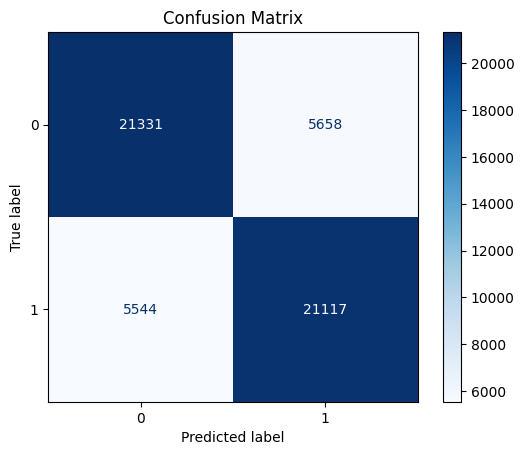

AUC: 0.8710938901964886


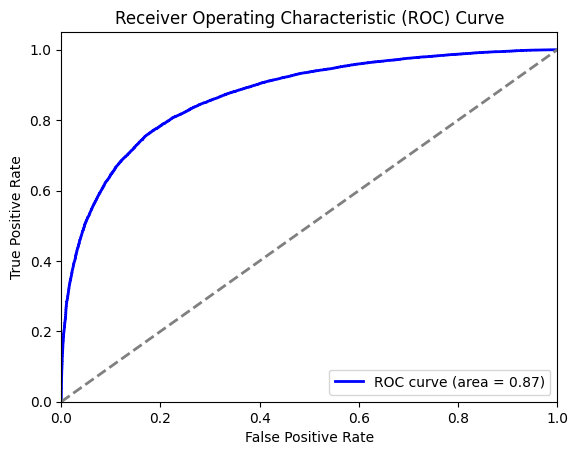

Positive Accuracy (Precision for positive class): 0.7886834733893557
Negative Accuracy (Precision for negative class): 0.7937116279069767
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 2


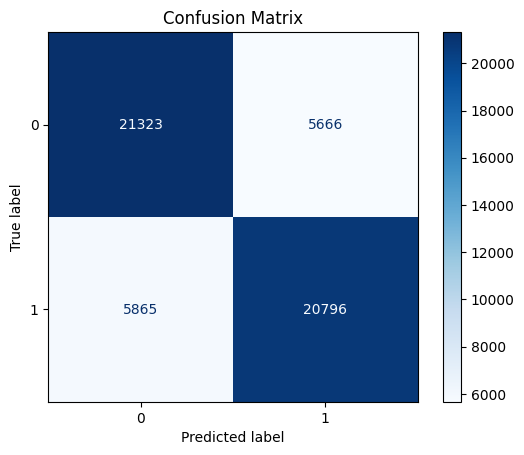

AUC: 0.8636992971514431


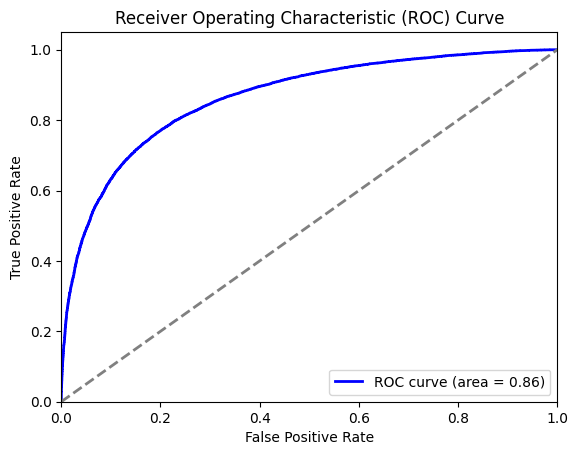

Positive Accuracy (Precision for positive class): 0.7858816415992744
Negative Accuracy (Precision for negative class): 0.784279829336472
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 3


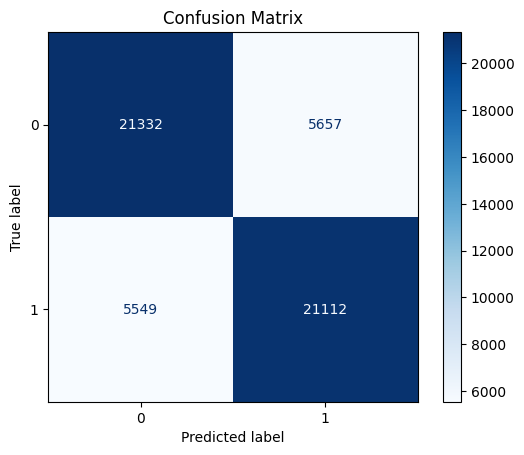

AUC: 0.8678651994033374


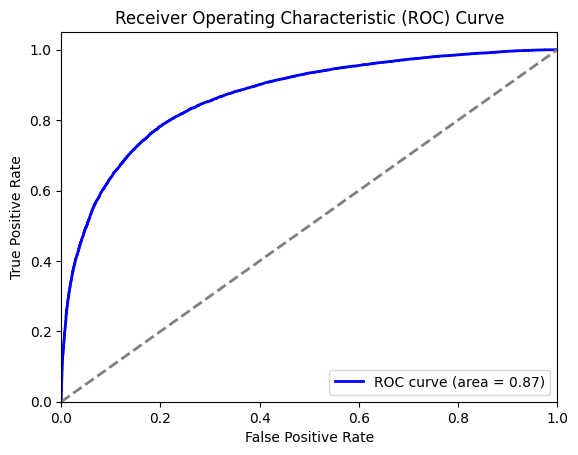

Positive Accuracy (Precision for positive class): 0.7886734655758527
Negative Accuracy (Precision for negative class): 0.7935716677206949


In [15]:
dir_path = config['model_output']['model_save_dir'] + config['date_string']+ '/' + 'test_log_'

for i in range(2,config['pathways_network']['n_hidden_layer']+2):
    print('-'*282)
    print(f'Number of Hidden Layers: {i-1}')
    result = pd.read_csv(f'{dir_path}{i}.csv',index_col=0)

    confusion_matrix_return(result)
    roc_curve_return(result)
    return_accuracy(result)

# Model Interpretation

In [16]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [31]:
test_x.iloc[0:2000,]

cell_id,GTTACAGAGTTCCAGT.28.2,CAATGACGTGGCCCAT.30.4,GGGACTCGTACTCGCG.31.11,GTAACACAGGAAGTAG.28.2,ATGTCCCAGCACTCGC.10.9,AGGCATTTCCTATTGT.1.5,TACGGTAGTTAAGGAT.28.2,TACCTCGGTCGTGCCA.10.9,ATTATCCCAACACACT.28.2,GTCTGTCTCCGAAGGA.28.2,...,CCGGTAGTCGCGTCGA.25.10,AGTTCGATCTCCTGTG.45.2,CATAAGCAGTGCAAAT.23.9,ACGCAGCGTCCGTTAA.37.1,AGCTCTCGTATATGGA.26.0,CCGGTAGCAGACTGCC.10.7,CACATGACAGGAGGAG.30.2,CGAACATTCAGTTTGG.20.0,ACGGAGATCATTTGGG.18.1,TATTGGGTCCCAAGCG.5.11
ENSG00000248643,1.208063,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,2.232956,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441701,0.000000,0.000000
ENSG00000288508,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,1.516599,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000066032,3.147573,0.000000,0.0,4.031494,0.0,0.0,4.086648,0.0,3.604895,3.597279,...,2.721328,3.998513,4.456396,4.078397,3.579941,4.895290,3.837604,3.509434,3.048950,4.646495
ENSG00000140740,1.208063,3.918796,0.0,0.000000,0.0,0.0,0.000000,0.0,1.516599,0.000000,...,0.764983,0.000000,1.059227,1.578547,1.674307,1.764110,0.946860,2.078556,1.215943,0.871185
ENSG00000088256,0.000000,0.000000,0.0,2.612991,0.0,0.0,1.584386,0.0,0.000000,0.000000,...,0.764983,0.000000,0.444955,0.000000,0.630326,1.136403,0.000000,0.000000,0.732454,0.352067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000152332,1.208063,0.000000,0.0,0.000000,0.0,0.0,1.584386,0.0,0.000000,0.000000,...,0.000000,1.998811,1.059227,0.000000,0.630326,1.136403,1.161499,0.779394,1.577436,0.634850
ENSG00000115053,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.444955,0.000000,0.630326,0.000000,0.388712,1.052843,0.732454,0.000000
ENSG00000172301,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.584386,0.0,1.516599,0.000000,...,0.000000,0.000000,0.444955,0.995191,0.000000,1.136403,0.694611,0.441701,0.000000,0.352067
ENSG00000143437,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,2.232956,...,0.000000,0.000000,1.059227,0.000000,0.630326,0.000000,0.000000,0.441701,0.732454,0.352067


In [30]:
train_x

cell_id,CTCAGAATCCCAATAG.8.11,CACACAACACCACGTG.19.1,TTTGACTTCCATTTGT.33.2,AGATAGATCGAGTCTA.11.2,TATCCTAAGGAAAGAC.15.2,TGGGCGTGTACCCGCA.7.6,CATACAGGTGACTCGC.32.11,GAACACTCAAGAATAC.28.2,TAGATCGTCCCTCATG.9.8,CATCCACTCATTTGGG.18.8,...,ATCAGGTGTCCCAAAT.25.7,TAGATCGGTAAGCGGT.10.9,CAGCCAGTCGTTCTCG.34.2,ACCTTTACACTTGGAT.35.1,GGGACCTAGGAGAATG.8.14,GTAACTGGTCATACTG.15.1,GTCACGGGTCCTCATC.13.11,TCGAACAGTCATATGC.28.2,GACTCAAGTTAATGAG.33.2,GTCAAGTGTCAAAGCG.35.1
ENSG00000248643,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.685711,0.835967,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
ENSG00000288508,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.258535,0.000000,0.0,0.226062,0.000000,0.000000,0.000000,0.000000,0.0
ENSG00000066032,3.631049,0.00000,0.000000,0.000000,0.000000,2.393281,0.0,3.914363,4.417285,0.0,...,4.148414,3.653006,4.280605,0.0,4.788331,4.563674,4.679202,4.059261,4.770832,0.0
ENSG00000140740,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.383217,0.986459,1.330689,0.0,0.747218,1.643068,0.685180,0.000000,0.000000,0.0
ENSG00000088256,0.000000,0.00000,0.000000,0.000000,0.000000,2.393281,0.0,0.000000,0.000000,0.0,...,0.685711,0.667928,0.000000,0.0,0.000000,0.000000,0.382890,0.000000,0.676022,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000284254,0.000000,0.00000,3.067901,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.685711,0.258535,0.589836,0.0,0.000000,0.000000,0.382890,1.565043,1.134522,0.0
ENSG00000004897,0.000000,0.00000,3.067901,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.148602,0.667928,1.468722,0.0,0.747218,0.772109,1.778886,1.565043,0.676022,0.0
ENSG00000277586,4.571619,3.62052,3.067901,4.444166,5.412106,3.248993,0.0,0.000000,0.000000,0.0,...,1.148602,2.049704,1.817779,0.0,0.593511,1.937742,0.685180,1.565043,0.676022,0.0
ENSG00000127947,0.000000,0.00000,0.000000,0.000000,0.000000,1.644666,0.0,2.509096,0.000000,0.0,...,0.383217,0.667928,0.589836,0.0,0.593511,0.772109,0.934972,0.000000,0.676022,0.0


In [36]:
.value_counts()

diagnosis
0            2025
1            1975
Name: count, dtype: int64

In [37]:
train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.iloc[0:2000,],y_test.iloc[0:4000,]) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)
'''
for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')
        '''

"\nfor j,i in model_dict_sparse.items():\n        \n        print(f'Hidden_Layers: {j}')\n        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)\n        print(f'Test Accuracy: {accuracy}')   \n        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)\n        print(f'Train Accuracy: {accuracy}')   \n        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)\n        print(f'Validation Accuracy: {accuracy}')\n        "

In [38]:
model_dict_sparse_2 = dict()
model_dict_sparse_2[2] = model_dict_sparse[2]

In [26]:
model_dict_sparse_2

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=3839, out_features=116, bias=False)
     (1): Linear(in_features=116, out_features=1, bias=True)
   )
 )}

In [39]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse_2, test_dataloader)

0it [00:00, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x53650 and 3839x116)

In [21]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        #accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        activations_list_dict[f'model_{i}_hidden_layers'], accuracy_list_dict[f'model_{i}_hidden_layers'], \
        predicted_list_dict[f'model_{i}_hidden_layers'], ground_truth_list_dict[f'model_{i}_hidden_layers'], \
        feature_list,x= attaching_hook(j, dataloader)
        print(f'{i} Layers: {accuracy_list_dict[f'model_{i}_hidden_layers']}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x

In [19]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [20]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_2_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))
    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])
layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))
    
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


NameError: name 'activations_list_dict' is not defined

In [ ]:
layer_0_df

In [25]:
last_layer_df

,last_layer
cell_id,
CACAACATCGTCCTTG.26.2,0.219095
AGCTTCCGTCTCTCTG.9.9,-0.219352
CGCCAGACAACAAGTA.17.11,-0.233183
GGGATGATCGTAACAC.7.4,0.532885
ACGTTCCGTATTCTCT.5.11,-0.003342
...,...
CATCAAGTCCTCGCAT.19.1,-1.132989
GTCAGCGGTCTGATAC.45.2,0.942101
CATGCTCAGTGTCATC.30.10,0.784364


In [26]:
layer_1_df

NameError: name 'layer_1_df' is not defined

In [27]:
last_layer_df

,last_layer
cell_id,
CACAACATCGTCCTTG.26.2,0.219095
AGCTTCCGTCTCTCTG.9.9,-0.219352
CGCCAGACAACAAGTA.17.11,-0.233183
GGGATGATCGTAACAC.7.4,0.532885
ACGTTCCGTATTCTCT.5.11,-0.003342
...,...
CATCAAGTCCTCGCAT.19.1,-1.132989
GTCAGCGGTCTGATAC.45.2,0.942101
CATGCTCAGTGTCATC.30.10,0.784364


In [28]:
y_test

,diagnosis
0,1
1,0
2,0
3,1
4,1
...,...
4691,1
4692,1
4693,1
4694,0


In [29]:
for i,j in predicted_list_dict.items():
    flattened_list = [item for sublist in list(predicted_list_dict[i]) for item in sublist]
    predicted_list_dict[i] = flattened_list
    

In [30]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [31]:
predicted_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

In [32]:
for i,j in ground_truth_list_dict.items():
    flattened_list = [item for sublist in list(ground_truth_list_dict[i]) for item in sublist]
    ground_truth_list_dict[i] = flattened_list
    

In [33]:
ground_truth_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [34]:
ground_truth_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [35]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [36]:
layer_1_df['predicted'] = predicted_list_dict['model_2_hidden_layers']
layer_1_df['ground_truth'] = ground_truth_list_dict['model_2_hidden_layers']
layer_1_df.head()

NameError: name 'layer_1_df' is not defined

In [37]:
correct_predicted_layer_1_df = layer_1_df[layer_1_df.predicted == layer_1_df.ground_truth]
correct_predicted_layer_1_df_AD = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 1]
correct_predicted_layer_1_df_Control = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 0]

NameError: name 'layer_1_df' is not defined

In [38]:
correct_predicted_layer_1_df_AD.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_AD.head()

NameError: name 'correct_predicted_layer_1_df_AD' is not defined

In [39]:
correct_predicted_layer_1_df_Control.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_Control

NameError: name 'correct_predicted_layer_1_df_Control' is not defined

In [40]:
from scipy import stats



# Perform a two-sample t-test





In [41]:
pathways_list = []
p_value_list = []

for i in correct_predicted_layer_1_df_Control.columns:
    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    plt.figure(figsize=(8, 6))
    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue'))
    
    # Add title and labels
    plt.title('Box Plot of Two Distributions')
    plt.ylabel('Values')
    pathways_list.append(i)
    p_value_list.append(p_value)
    # Display the plot
    plt.show()
    
    

NameError: name 'correct_predicted_layer_1_df_Control' is not defined

In [42]:
pd.DataFrame(pathways_list, p_value_list)

""


In [43]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_3_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 554142.80it/s]


In [44]:
layer_1_df

,R-HSA-417957,R-HSA-162592,R-HSA-5654689,R-HSA-75896,R-HSA-5654716,R-HSA-159231,R-HSA-5210891,R-HSA-113507,R-HSA-5339716,R-HSA-9034864,...,R-HSA-5655291_copy1,R-HSA-5654688,R-HSA-6783310_copy1,R-HSA-5675482,R-HSA-9027604,R-HSA-5661231,R-HSA-2979096,R-HSA-901042,R-HSA-9665348,R-HSA-77288
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.003275,0.009810,-0.015456,0.000000,0.001502,0.001915,0.009021,-0.010476,-0.006433,-0.000057,...,0.027487,0.000277,0.002091,-0.000094,0.000000,0.000000,0.012869,-0.000795,0.011302,-0.000602
AGCTTCCGTCTCTCTG.9.9,0.000000,0.012895,-0.005234,0.000000,-0.003001,0.000000,0.010151,-0.005489,-0.002985,0.000000,...,0.008764,0.000000,0.000000,0.000000,0.000000,0.000000,0.023016,0.000000,0.000332,0.000000
CGCCAGACAACAAGTA.17.11,0.000000,0.013725,-0.010916,0.000000,-0.001140,0.006392,0.008776,-0.012376,-0.004896,-0.000100,...,0.023170,-0.000132,0.005502,0.003574,-0.000662,0.000000,0.011449,-0.001674,0.009848,-0.000389
GGGATGATCGTAACAC.7.4,0.000000,0.007576,-0.009176,-0.003849,0.012905,0.000000,0.014573,0.000000,-0.005228,-0.000047,...,0.016054,0.000687,0.004162,-0.004238,0.000000,0.000000,0.016451,0.000013,0.015558,0.000000
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034737,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.012875,0.000000,0.000000,0.000000,0.000000,0.000000,0.006510,-0.006484,-0.003527,0.000000,...,0.000000,0.000000,0.009876,0.006180,0.000000,0.000000,0.003763,-0.004656,0.000000,-0.001288
GTCAGCGGTCTGATAC.45.2,0.000000,0.025255,-0.016036,0.000000,-0.005883,0.000000,0.013536,-0.007280,-0.001409,-0.000141,...,0.033405,-0.000373,-0.001616,-0.004335,0.000000,0.000069,0.016819,0.000014,0.011218,0.000000
CATGCTCAGTGTCATC.30.10,0.000000,0.020581,-0.013634,0.000000,-0.011415,0.000000,0.013967,-0.013448,-0.003815,-0.000052,...,0.025742,-0.000368,0.000013,-0.003372,0.000000,0.000000,0.008851,0.000011,0.001313,0.000000


In [45]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_4_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i)) 
layer_2_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 443773.69it/s]


In [46]:
layer_2_df

,R-HSA-5655332,R-HSA-5693537,R-HSA-5205647,R-HSA-881907,R-HSA-2660825,R-HSA-5654696,R-HSA-109704,R-HSA-198753,R-HSA-211976,R-HSA-5654687,...,R-HSA-389356,R-HSA-8979227,R-HSA-446353,R-HSA-196807,R-HSA-1181150,R-HSA-1839124,R-HSA-6804758,R-HSA-3371571,R-HSA-5260271,R-HSA-8963898
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.003298,-0.000165,-0.001825,-0.000286,0.001378,-0.003232,0.001074,-0.000682,0.000001,0.000799,...,0.000024,0.001375,0.000942,-0.000680,-0.000505,-0.000043,0.000042,-0.000133,0.002777,0.004619
AGCTTCCGTCTCTCTG.9.9,-0.001275,-0.000542,0.003747,0.000000,0.002781,-0.001038,0.000221,-0.000620,0.000007,0.000482,...,0.000059,0.000580,0.001331,-0.000299,-0.000403,-0.000027,0.000000,-0.000133,0.004294,0.001991
CGCCAGACAACAAGTA.17.11,-0.002072,-0.000194,-0.000583,0.000020,0.001338,-0.003624,0.000773,-0.000940,0.000005,0.000524,...,-0.000422,0.001126,0.001401,-0.000515,-0.000350,-0.000085,0.000048,-0.000117,0.003689,0.003816
GGGATGATCGTAACAC.7.4,-0.001756,-0.000536,0.001314,-0.000621,0.001628,-0.001184,0.001733,-0.000956,0.000010,-0.000068,...,0.000212,0.001284,0.001769,-0.000462,-0.000622,-0.000023,0.000000,-0.000158,0.002709,0.004330
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,-0.004301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000240,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.000000,-0.000968,-0.004846,0.000000,0.000000,0.000000,0.000000,-0.001352,0.000008,0.000000,...,0.000000,0.001268,0.001014,-0.000750,0.000000,-0.000026,0.000000,0.000000,0.003127,0.004278
GTCAGCGGTCTGATAC.45.2,-0.003111,0.000000,0.003738,0.000186,0.001664,-0.005484,0.000576,-0.001488,0.000012,0.000944,...,-0.000818,0.000000,0.000000,-0.000397,-0.000792,-0.000100,0.000000,-0.000109,0.002332,0.000000
CATGCTCAGTGTCATC.30.10,-0.003066,-0.000559,0.005367,0.000263,0.000776,-0.003960,0.001311,-0.000742,0.000011,0.001265,...,-0.000353,0.001623,0.001542,-0.000403,-0.000563,-0.000065,0.000028,-0.000110,0.000000,0.005398


# layer_2_df

# Plots

In [782]:
!pwd

/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network
